# %%
# =============================================================================
# INCOME PREDICTION MODEL - CLEAN ML PIPELINE
# =============================================================================
# Goal: Predict customer income (ingresos_reportados) using enhanced features
# Current Performance: R² ≈ 0.31 (Target: Improve to 0.35+)
# Models: XGBoost, LightGBM, Random Forest with GroupKFold CV
# =============================================================================


## Imports and Setup

In [1]:
# %%
# SECTION 1: IMPORTS AND SETUP
# =============================================================================
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GroupKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("=" * 80)
print("INCOME PREDICTION MODEL - CLEAN PIPELINE STARTED")
print("=" * 80)

INCOME PREDICTION MODEL - CLEAN PIPELINE STARTED


## Data Load 

In [2]:
# %%
# SECTION 2: DATA LOADING AND INITIAL SETUP
# =============================================================================
print("\n🔄 LOADING PROCESSED DATA")
print("-" * 50)

# Define data path
data_path = r'C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed'

# Load the main dataset
df_original = pd.read_csv(data_path + '/df_clientes_clean_final.csv')

print(f"✅ Original dataset loaded: {df_original.shape}")
print(f"   Columns: {df_original.shape[1]}")
print(f"   Records: {df_original.shape[0]:,}")


🔄 LOADING PROCESSED DATA
--------------------------------------------------
✅ Original dataset loaded: (29319, 40)
   Columns: 40
   Records: 29,319


## Feature Selection &  Data Preparation

In [3]:
# %%
# SECTION 3: FEATURE SELECTION AND DATASET PREPARATION
# =============================================================================
print("\n🎯 PREPARING FEATURE SET")
print("-" * 50)

# Define columns to keep for modeling
columns_to_keep = [
    # ID columns
    'cliente', 'identificador_unico',
    
    # Target variable
    'ingresos_reportados',
    
    # Core features (already processed)
    'edad', 'letras_mensuales', 'monto_letra', 'saldo','monto_prestamo',
 'tasa_prestamo',
    'fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento',
    'ocupacion_consolidated', 'ciudad_consolidated',
    'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated',
    'sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated',
    'missing_fechaingresoempleo', 'missing_nombreempleadorcliente', 'missing_cargoempleocliente',
    'is_retired', 'age_group'
]

# Filter to existing columns
existing_columns = [col for col in columns_to_keep if col in df_original.columns]
df_working = df_original[existing_columns].copy()

print(f"✅ Working dataset prepared: {df_working.shape}")
print(f"   Features to process: {len(existing_columns) - 3}")  # Exclude IDs and target



🎯 PREPARING FEATURE SET
--------------------------------------------------
✅ Working dataset prepared: (29319, 24)
   Features to process: 21


In [4]:
# Check for other data quality issues
print("🔍 Data Quality Check:")
print(f"Values exactly $999,999,999: {(df_working['ingresos_reportados'] == 999999999).sum()}")
print(f"Values > $100,000: {(df_working['ingresos_reportados'] > 100000).sum()}")
print(f"Values = $0: {(df_working['ingresos_reportados'] == 0).sum()}")
print(f"Negative values: {(df_working['ingresos_reportados'] < 0).sum()}")

# Show the suspicious high values
high_values = df_working[df_working['ingresos_reportados'] > 50000]['ingresos_reportados'].value_counts()
print(f"\nSuspicious high values:")
print(high_values.head(10))

🔍 Data Quality Check:
Values exactly $999,999,999: 2
Values > $100,000: 11
Values = $0: 548
Negative values: 0

Suspicious high values:
ingresos_reportados
1.000000e+09    2
9.607333e+04    1
7.341200e+04    1
9.181821e+04    1
2.485682e+05    1
9.999900e+04    1
5.273975e+04    1
9.999990e+05    1
6.536483e+04    1
6.005700e+04    1
Name: count, dtype: int64


In [5]:
# RECOMMENDED: Two-step approach
import scipy.stats.mstats as mstats
print("🧹 STEP 1: Remove obvious data entry errors")
print(f"Before: {len(df_working):,} customers")

# Remove the billion-dollar errors
df_working = df_working[df_working['ingresos_reportados'] < 200000]  # $200K cap
print(f"After error removal: {len(df_working):,} customers")

print("🧹 STEP 2: Apply winsorization for remaining outliers")
# Then winsorize the remaining data
df_working['ingresos_reportados'] = mstats.winsorize(
    df_working['ingresos_reportados'], 
    limits=(0.01, 0.02)  # 1% lower, 2% upper
)

print(f"Income range after processing: ${df_working['ingresos_reportados'].min():,.0f} - ${df_working['ingresos_reportados'].max():,.0f}")

🧹 STEP 1: Remove obvious data entry errors
Before: 29,319 customers
After error removal: 29,312 customers
🧹 STEP 2: Apply winsorization for remaining outliers
Income range after processing: $0 - $5,700


## Data Preprocessing Pipeline

In [6]:
# %%
# SECTION 4: DATA PREPROCESSING PIPELINE
# =============================================================================
print("\n🔧 DATA PREPROCESSING PIPELINE")
print("-" * 50)

def preprocess_data(df):
    """
    Complete data preprocessing pipeline
    """
    df_processed = df.copy()
    
    # 4.1: Handle Missing Values
    print("   📋 Handling missing values...")
    
    # Core numerical missing values
    if 'monto_letra' in df_processed.columns:
        df_processed['monto_letra_missing'] = df_processed['monto_letra'].isnull().astype(int)
        median_monto = df_processed['monto_letra'].median()
        df_processed['monto_letra'] = df_processed['monto_letra'].fillna(median_monto)
        print(f"      ✅ monto_letra: filled {df_processed['monto_letra_missing'].sum()} missing values")
    
    # New loan features (high missing rate - special handling)
    if 'monto_prestamo' in df_processed.columns:
        missing_count = df_processed['monto_prestamo'].isnull().sum()
        missing_pct = (missing_count / len(df_processed)) * 100
        
        # Create missing flag (important feature!)
        df_processed['monto_prestamo_missing'] = df_processed['monto_prestamo'].isnull().astype(int)
        
        # Fill with 0 (indicates no loan amount recorded)
        df_processed['monto_prestamo'] = df_processed['monto_prestamo'].fillna(0)
        print(f"      ✅ monto_prestamo: filled {missing_count:,} missing values ({missing_pct:.1f}%) with 0")
    
    if 'tasa_prestamo' in df_processed.columns:
        missing_count = df_processed['tasa_prestamo'].isnull().sum()
        missing_pct = (missing_count / len(df_processed)) * 100
        
        # Create missing flag (important feature!)
        df_processed['tasa_prestamo_missing'] = df_processed['tasa_prestamo'].isnull().astype(int)
        
        # Fill with median of available rates (more meaningful than 0)
        median_rate = df_processed['tasa_prestamo'].median()
        df_processed['tasa_prestamo'] = df_processed['tasa_prestamo'].fillna(median_rate)
        print(f"      ✅ tasa_prestamo: filled {missing_count:,} missing values ({missing_pct:.1f}%) with median ({median_rate:.2f})")
    
    # Create derived features from new loan data
    if 'monto_prestamo' in df_processed.columns and 'monto_letra' in df_processed.columns:
        # Loan to payment ratio (when both available)
        df_processed['loan_to_payment_ratio'] = df_processed['monto_prestamo'] / (df_processed['monto_letra'] + 1)
        print(f"      ✅ Created loan_to_payment_ratio feature")
    
    if 'monto_prestamo' in df_processed.columns:
        # Has loan indicator (binary feature)
        df_processed['has_loan_amount'] = (df_processed['monto_prestamo'] > 0).astype(int)
        print(f"      ✅ Created has_loan_amount indicator")
    
    # 4.2: Convert Date Features
    print("   📅 Converting date features...")
    reference_date = pd.Timestamp('2020-01-01')
    date_columns = ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
    
    for date_col in date_columns:
        if date_col in df_processed.columns:
            # Convert to datetime
            df_processed[date_col] = pd.to_datetime(df_processed[date_col], errors='coerce')
            
            # Convert to days since reference
            df_processed[f'{date_col}_days'] = (df_processed[date_col] - reference_date).dt.days
            
            # Handle missing values
            missing_count = df_processed[f'{date_col}_days'].isnull().sum()
            if missing_count > 0:
                df_processed[f'{date_col}_missing'] = df_processed[f'{date_col}_days'].isnull().astype(int)
                median_days = df_processed[f'{date_col}_days'].median()
                df_processed[f'{date_col}_days'] = df_processed[f'{date_col}_days'].fillna(median_days)
                print(f"      ✅ {date_col}: converted to days, filled {missing_count} missing")
            
            # Drop original date column
            df_processed.drop(columns=[date_col], inplace=True)
    
    # 4.3: Encode Categorical Features
    print("   🏷️  Encoding categorical features...")
    
    # Low cardinality - One-hot encoding
    low_cardinality = ['sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated', 'age_group']
    existing_low_card = [col for col in low_cardinality if col in df_processed.columns]
    
    for col in existing_low_card:
        df_processed[col] = df_processed[col].fillna('Unknown')
        dummies = pd.get_dummies(df_processed[col], prefix=col, drop_first=True)
        df_processed = pd.concat([df_processed, dummies], axis=1)
        df_processed.drop(columns=[col], inplace=True)
        print(f"      ✅ {col}: created {len(dummies.columns)} dummy variables")
    
    # High cardinality - Frequency encoding
    high_cardinality = ['ocupacion_consolidated', 'ciudad_consolidated',
                       'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated']
    existing_high_card = [col for col in high_cardinality if col in df_processed.columns]
    
    for col in existing_high_card:
        df_processed[col] = df_processed[col].fillna('Unknown')
        freq_map = df_processed[col].value_counts().to_dict()
        new_col_name = f'{col}_freq'
        df_processed[new_col_name] = df_processed[col].map(freq_map)
        df_processed.drop(columns=[col], inplace=True)
        print(f"      ✅ {col}: frequency encoded (range: {df_processed[new_col_name].min()}-{df_processed[new_col_name].max()})")
    
    return df_processed

# Apply preprocessing
df_processed = preprocess_data(df_working)
print(f"\n✅ Preprocessing complete: {df_processed.shape}")


🔧 DATA PREPROCESSING PIPELINE
--------------------------------------------------
   📋 Handling missing values...
      ✅ monto_letra: filled 2298 missing values
      ✅ monto_prestamo: filled 26,654 missing values (90.9%) with 0
      ✅ tasa_prestamo: filled 19,248 missing values (65.7%) with median (0.75)
      ✅ Created loan_to_payment_ratio feature
      ✅ Created has_loan_amount indicator
   📅 Converting date features...
      ✅ fechaingresoempleo: converted to days, filled 8304 missing
      ✅ fecha_inicio: converted to days, filled 9674 missing
      ✅ fecha_vencimiento: converted to days, filled 16613 missing
   🏷️  Encoding categorical features...
      ✅ sexo_consolidated: created 1 dummy variables
      ✅ estado_civil_consolidated: created 2 dummy variables
      ✅ pais_consolidated: created 1 dummy variables
      ✅ age_group: created 6 dummy variables
      ✅ ocupacion_consolidated: frequency encoded (range: 321-7405)
      ✅ ciudad_consolidated: frequency encoded (range: 

### Check 'Ingresos Reportados'

In [7]:
# How many zero incomes do you have?
zero_income_count = (df_processed.ingresos_reportados == 0).sum()
zero_income_pct = (zero_income_count / len(df_processed.ingresos_reportados)) * 100

print(f"Zero income records: {zero_income_count:,} ({zero_income_pct:.1f}%)")

# What do their features look like?
zero_income_mask = (df_processed['ingresos_reportados'] == 0)
zero_income_profiles = df_processed[zero_income_mask]

print(f"Zero income profiles:")
print(f"  Average monto_letra: ${zero_income_profiles['monto_letra'].mean():,.2f}")
print(f"  Average age: {zero_income_profiles['edad'].mean():.1f}")
print(f"  Has loans: {(zero_income_profiles['monto_prestamo'] > 0).sum()}")

Zero income records: 548 (1.9%)
Zero income profiles:
  Average monto_letra: $15.26
  Average age: 38.8
  Has loans: 70


### Remove Zero Incomes 

In [8]:
# Filter out zero incomes before training
non_zero_mask = (df_processed['ingresos_reportados'] > 0)
df_processed = df_processed[non_zero_mask].copy()

print(f"Removed {(~non_zero_mask).sum():,} zero income records")

Removed 548 zero income records


In [9]:
print("📊 INCOME DISTRIBUTION ANALYSIS:")
print(f"Min income: ${df_processed.ingresos_reportados.min():,.2f}")
print(f"Max income: ${df_processed.ingresos_reportados.max():,.2f}")
print(f"Mean income: ${df_processed.ingresos_reportados.mean():,.2f}")
print(f"Median income: ${df_processed.ingresos_reportados.median():,.2f}")

# Check for very low incomes
low_income_count = (df_processed.ingresos_reportados < 1000).sum()
very_low_count = (df_processed.ingresos_reportados < 500).sum()
print(f"Incomes < $1,000: {low_income_count} ({low_income_count/len(df_processed.ingresos_reportados)*100:.1f}%)")
print(f"Incomes < $500: {very_low_count} ({very_low_count/len(df_processed.ingresos_reportados)*100:.1f}%)")

📊 INCOME DISTRIBUTION ANALYSIS:
Min income: $0.01
Max income: $5,699.89
Mean income: $1,497.28
Median income: $1,194.60
Incomes < $1,000: 11681 (40.6%)
Incomes < $500: 1388 (4.8%)


In [10]:
# drop saldos <0
df_processed = df_processed[df_processed['saldo'] >= 0]

In [11]:
df_processed.columns.tolist()

['cliente',
 'identificador_unico',
 'ingresos_reportados',
 'edad',
 'letras_mensuales',
 'monto_letra',
 'saldo',
 'monto_prestamo',
 'tasa_prestamo',
 'missing_fechaingresoempleo',
 'missing_nombreempleadorcliente',
 'missing_cargoempleocliente',
 'is_retired',
 'monto_letra_missing',
 'monto_prestamo_missing',
 'tasa_prestamo_missing',
 'loan_to_payment_ratio',
 'has_loan_amount',
 'fechaingresoempleo_days',
 'fechaingresoempleo_missing',
 'fecha_inicio_days',
 'fecha_inicio_missing',
 'fecha_vencimiento_days',
 'fecha_vencimiento_missing',
 'sexo_consolidated_Masculino',
 'estado_civil_consolidated_Others',
 'estado_civil_consolidated_Soltero',
 'pais_consolidated_PANAMA                                       ',
 'age_group_26-35',
 'age_group_36-45',
 'age_group_46-55',
 'age_group_56-65',
 'age_group_65+',
 'age_group_Unknown',
 'ocupacion_consolidated_freq',
 'ciudad_consolidated_freq',
 'nombreempleadorcliente_consolidated_freq',
 'cargoempleocliente_consolidated_freq']

<Axes: xlabel='ingresos_reportados', ylabel='Density'>

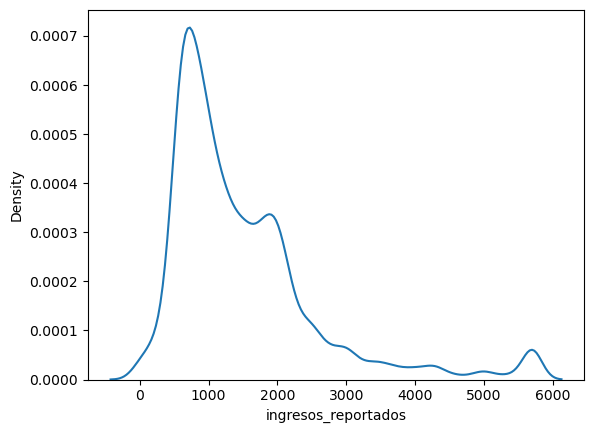

In [12]:
#kdplot of ingresos_reportados
sns.kdeplot(df_processed['ingresos_reportados'])

In [13]:
df_processed.ingresos_reportados.describe()

count    28665.000000
mean      1494.278329
std       1095.339496
min          0.010000
25%        750.000000
50%       1194.000000
75%       1912.860000
max       5699.890000
Name: ingresos_reportados, dtype: float64

In [14]:
df_processed.to_csv(data_path + '/df_processed_augmented_final.csv', index=False)

In [15]:
#check if 'saldo' < 0
df_processed[df_processed['saldo'] < 0]

,cliente,identificador_unico,ingresos_reportados,edad,letras_mensuales,monto_letra,saldo,monto_prestamo,tasa_prestamo,missing_fechaingresoempleo,missing_nombreempleadorcliente,missing_cargoempleocliente,is_retired,monto_letra_missing,monto_prestamo_missing,tasa_prestamo_missing,loan_to_payment_ratio,has_loan_amount,fechaingresoempleo_days,fechaingresoempleo_missing,fecha_inicio_days,fecha_inicio_missing,fecha_vencimiento_days,fecha_vencimiento_missing,sexo_consolidated_Masculino,estado_civil_consolidated_Others,estado_civil_consolidated_Soltero,pais_consolidated_PANAMA,age_group_26-35,age_group_36-45,age_group_46-55,age_group_56-65,age_group_65+,age_group_Unknown,ocupacion_consolidated_freq,ciudad_consolidated_freq,nombreempleadorcliente_consolidated_freq,cargoempleocliente_consolidated_freq


## Feature Engineering Function

In [16]:
# %%
# SECTION 5: ENHANCED FEATURE ENGINEERING WITH NEW LOAN FEATURES (DTYPE FIXED)
# =============================================================================
print("\n⚙️ ENHANCED FEATURE ENGINEERING SETUP (WITH LOAN FEATURES)")
print("-" * 60)

# =============================================================================
# PREPROCESSING FUNCTION WITH PROPER DTYPE HANDLING
# =============================================================================

def preprocess_data_fixed(df):
    """
    Complete data preprocessing pipeline with proper dtype handling
    """
    df_processed = df.copy()

    # 4.1: Handle Missing Values
    print("   📋 Handling missing values...")

    # Core numerical missing values
    if 'monto_letra' in df_processed.columns:
        df_processed['monto_letra_missing'] = df_processed['monto_letra'].isnull().astype('int32')
        median_monto = df_processed['monto_letra'].median()
        df_processed['monto_letra'] = df_processed['monto_letra'].fillna(median_monto).astype('float32')
        print(f"      ✅ monto_letra: filled {df_processed['monto_letra_missing'].sum()} missing values")

    # New loan features (high missing rate - special handling)
    if 'monto_prestamo' in df_processed.columns:
        missing_count = df_processed['monto_prestamo'].isnull().sum()
        missing_pct = (missing_count / len(df_processed)) * 100

        # Create missing flag (important feature!)
        df_processed['monto_prestamo_missing'] = df_processed['monto_prestamo'].isnull().astype('int32')

        # Fill with 0 (indicates no loan amount recorded)
        df_processed['monto_prestamo'] = df_processed['monto_prestamo'].fillna(0).astype('float32')
        print(f"      ✅ monto_prestamo: filled {missing_count:,} missing values ({missing_pct:.1f}%) with 0")

    if 'tasa_prestamo' in df_processed.columns:
        missing_count = df_processed['tasa_prestamo'].isnull().sum()
        missing_pct = (missing_count / len(df_processed)) * 100

        # Create missing flag (important feature!)
        df_processed['tasa_prestamo_missing'] = df_processed['tasa_prestamo'].isnull().astype('int32')

        # Fill with median of available rates (more meaningful than 0)
        median_rate = df_processed['tasa_prestamo'].median()
        df_processed['tasa_prestamo'] = df_processed['tasa_prestamo'].fillna(median_rate).astype('float32')
        print(f"      ✅ tasa_prestamo: filled {missing_count:,} missing values ({missing_pct:.1f}%) with median ({median_rate:.2f})")

    # Create derived features from new loan data
    if 'monto_prestamo' in df_processed.columns and 'monto_letra' in df_processed.columns:
        # Loan to payment ratio (when both available)
        df_processed['loan_to_payment_ratio'] = (df_processed['monto_prestamo'] / (df_processed['monto_letra'] + 1)).astype('float32')
        print(f"      ✅ Created loan_to_payment_ratio feature")

    if 'monto_prestamo' in df_processed.columns:
        # Has loan indicator (binary feature)
        df_processed['has_loan_amount'] = (df_processed['monto_prestamo'] > 0).astype('int32')
        print(f"      ✅ Created has_loan_amount indicator")

    # 4.2: Convert Date Features
    print("   📅 Converting date features...")
    reference_date = pd.Timestamp('2020-01-01')
    date_columns = ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']

    for date_col in date_columns:
        if date_col in df_processed.columns:
            # Convert to datetime
            df_processed[date_col] = pd.to_datetime(df_processed[date_col], errors='coerce')

            # Convert to days since reference
            df_processed[f'{date_col}_days'] = ((df_processed[date_col] - reference_date).dt.days).astype('float32')

            # Handle missing values
            missing_count = df_processed[f'{date_col}_days'].isnull().sum()
            if missing_count > 0:
                df_processed[f'{date_col}_missing'] = df_processed[f'{date_col}_days'].isnull().astype('int32')
                median_days = df_processed[f'{date_col}_days'].median()
                df_processed[f'{date_col}_days'] = df_processed[f'{date_col}_days'].fillna(median_days).astype('float32')
                print(f"      ✅ {date_col}: converted to days, filled {missing_count} missing")

            # Drop original date column
            df_processed.drop(columns=[date_col], inplace=True)

    # 4.3: Encode Categorical Features (FIXED VERSION)
    print("   🏷️  Encoding categorical features with proper dtypes...")

    # Low cardinality - One-hot encoding with proper dtypes
    low_cardinality = ['sexo_consolidated', 'estado_civil_consolidated', 'pais_consolidated', 'age_group']
    existing_low_card = [col for col in low_cardinality if col in df_processed.columns]

    for col in existing_low_card:
        df_processed[col] = df_processed[col].fillna('Unknown')

        # KEY FIX: Add dtype=int parameter and explicit conversion
        dummies = pd.get_dummies(df_processed[col], prefix=col, drop_first=True, dtype='int32')

        # Double-check conversion to int32
        for dummy_col in dummies.columns:
            dummies[dummy_col] = dummies[dummy_col].astype('int32')

        df_processed = pd.concat([df_processed, dummies], axis=1)
        df_processed.drop(columns=[col], inplace=True)
        print(f"      ✅ {col}: created {len(dummies.columns)} dummy variables (int32)")

    # High cardinality - Frequency encoding
    high_cardinality = ['ocupacion_consolidated', 'ciudad_consolidated',
                       'nombreempleadorcliente_consolidated', 'cargoempleocliente_consolidated']
    existing_high_card = [col for col in high_cardinality if col in df_processed.columns]

    for col in existing_high_card:
        df_processed[col] = df_processed[col].fillna('Unknown')
        freq_map = df_processed[col].value_counts().to_dict()
        new_col_name = f'{col}_freq'
        df_processed[new_col_name] = df_processed[col].map(freq_map).astype('int32')
        df_processed.drop(columns=[col], inplace=True)
        print(f"      ✅ {col}: frequency encoded (range: {df_processed[new_col_name].min()}-{df_processed[new_col_name].max()})")

    return df_processed

def create_interaction_features(df):
    """
    Create advanced interaction features for enhanced model performance
    Focus on interpretable, business-meaningful features
    ENHANCED VERSION: Includes new loan features (monto_prestamo, tasa_prestamo)
    DTYPE FIXED: All features are ML-compatible (int32/float32)
    """
    df_enhanced = df.copy()

    print(f"   🔧 Creating interaction features for dataset: {df.shape}")

    # Get age group columns
    age_columns = [col for col in df.columns if col.startswith('age_group_')]
    
    # =============================================================================
    # NEW SECTION: LOAN-SPECIFIC FEATURE ENGINEERING
    # =============================================================================
    print("   💳 Creating loan-specific features...")
    
    # 1. LOAN AMOUNT FEATURES
    if 'monto_prestamo' in df.columns:
        # Loan amount categories
        loan_25th = df_enhanced['monto_prestamo'].quantile(0.25)
        loan_50th = df_enhanced['monto_prestamo'].quantile(0.50)
        loan_75th = df_enhanced['monto_prestamo'].quantile(0.75)
        loan_90th = df_enhanced['monto_prestamo'].quantile(0.90)

        df_enhanced['small_loan'] = ((df_enhanced['monto_prestamo'] > 0) &
                                   (df_enhanced['monto_prestamo'] <= loan_25th)).astype('int32')
        df_enhanced['medium_loan'] = ((df_enhanced['monto_prestamo'] > loan_25th) &
                                    (df_enhanced['monto_prestamo'] <= loan_75th)).astype('int32')
        df_enhanced['large_loan'] = ((df_enhanced['monto_prestamo'] > loan_75th) &
                                   (df_enhanced['monto_prestamo'] <= loan_90th)).astype('int32')
        df_enhanced['jumbo_loan'] = (df_enhanced['monto_prestamo'] > loan_90th).astype('int32')

        # Loan amount per age (loan capacity indicator)
        if 'edad' in df.columns:
            df_enhanced['loan_per_age'] = (df_enhanced['monto_prestamo'] / (df_enhanced['edad'] + 1)).astype('float32')
            df_enhanced['high_loan_capacity'] = (df_enhanced['loan_per_age'] >=
                                               df_enhanced['loan_per_age'].quantile(0.8)).astype('int32')

        print(f"      ✅ Created loan amount category and capacity features")
    
    # 2. INTEREST RATE FEATURES
    if 'tasa_prestamo' in df.columns:
        # Interest rate categories
        rate_25th = df_enhanced['tasa_prestamo'].quantile(0.25)
        rate_75th = df_enhanced['tasa_prestamo'].quantile(0.75)

        df_enhanced['low_interest_rate'] = (df_enhanced['tasa_prestamo'] <= rate_25th).astype('int32')
        df_enhanced['high_interest_rate'] = (df_enhanced['tasa_prestamo'] >= rate_75th).astype('int32')
        df_enhanced['medium_interest_rate'] = ((df_enhanced['tasa_prestamo'] > rate_25th) &
                                             (df_enhanced['tasa_prestamo'] < rate_75th)).astype('int32')

        # Interest rate risk categories
        df_enhanced['premium_rate'] = (df_enhanced['tasa_prestamo'] <= 2.0).astype('int32')  # Very low rate
        df_enhanced['standard_rate'] = ((df_enhanced['tasa_prestamo'] > 2.0) &
                                      (df_enhanced['tasa_prestamo'] <= 5.0)).astype('int32')
        df_enhanced['high_risk_rate'] = (df_enhanced['tasa_prestamo'] > 5.0).astype('int32')

        print(f"      ✅ Created interest rate category and risk features")
    
    # 3. LOAN-TO-PAYMENT RELATIONSHIPS
    if 'monto_prestamo' in df.columns and 'monto_letra' in df.columns:
        # Loan to monthly payment ratio (loan term indicator)
        df_enhanced['loan_to_payment_ratio'] = (df_enhanced['monto_prestamo'] / (df_enhanced['monto_letra'] + 1)).astype('float32')

        # Loan term categories (based on ratio)
        term_33rd = df_enhanced['loan_to_payment_ratio'].quantile(0.33)
        term_66th = df_enhanced['loan_to_payment_ratio'].quantile(0.66)

        df_enhanced['short_term_loan'] = (df_enhanced['loan_to_payment_ratio'] <= term_33rd).astype('int32')
        df_enhanced['medium_term_loan'] = ((df_enhanced['loan_to_payment_ratio'] > term_33rd) &
                                         (df_enhanced['loan_to_payment_ratio'] <= term_66th)).astype('int32')
        df_enhanced['long_term_loan'] = (df_enhanced['loan_to_payment_ratio'] > term_66th).astype('int32')

        # Payment burden from loan
        df_enhanced['loan_payment_burden'] = (df_enhanced['monto_letra'] / (df_enhanced['monto_prestamo'] + 1)).astype('float32')
        df_enhanced['high_loan_burden'] = (df_enhanced['loan_payment_burden'] >=
                                         df_enhanced['loan_payment_burden'].quantile(0.8)).astype('int32')

        print(f"      ✅ Created loan-payment relationship features")
    
    # 4. LOAN-BALANCE INTERACTIONS
    if 'monto_prestamo' in df.columns and 'saldo' in df.columns:
        # Loan to balance ratio (leverage indicator)
        df_enhanced['loan_to_balance_ratio'] = df_enhanced['monto_prestamo'] / (df_enhanced['saldo'] + 1)
        
        # Financial leverage categories
        leverage_50th = df_enhanced['loan_to_balance_ratio'].quantile(0.50)
        leverage_80th = df_enhanced['loan_to_balance_ratio'].quantile(0.80)
        
        df_enhanced['conservative_leverage'] = (df_enhanced['loan_to_balance_ratio'] <= leverage_50th).astype(int)
        df_enhanced['moderate_leverage'] = ((df_enhanced['loan_to_balance_ratio'] > leverage_50th) & 
                                          (df_enhanced['loan_to_balance_ratio'] <= leverage_80th)).astype(int)
        df_enhanced['high_leverage'] = (df_enhanced['loan_to_balance_ratio'] > leverage_80th).astype(int)
        
        # Balance coverage (can balance cover loan?)
        df_enhanced['balance_covers_loan'] = (df_enhanced['saldo'] >= df_enhanced['monto_prestamo']).astype(int)
        df_enhanced['balance_coverage_ratio'] = df_enhanced['saldo'] / (df_enhanced['monto_prestamo'] + 1)
        
        print(f"      ✅ Created loan-balance interaction features")
    
    # 5. LOAN MISSING VALUE PATTERNS
    if 'monto_prestamo_missing' in df.columns and 'tasa_prestamo_missing' in df.columns:
        # Loan data completeness patterns
        df_enhanced['complete_loan_data'] = ((df_enhanced['monto_prestamo_missing'] == 0) &
                                           (df_enhanced['tasa_prestamo_missing'] == 0)).astype('int32')
        df_enhanced['partial_loan_data'] = ((df_enhanced['monto_prestamo_missing'] == 0) |
                                          (df_enhanced['tasa_prestamo_missing'] == 0)).astype('int32')
        df_enhanced['no_loan_data'] = ((df_enhanced['monto_prestamo_missing'] == 1) &
                                     (df_enhanced['tasa_prestamo_missing'] == 1)).astype('int32')

        # Loan data quality score
        df_enhanced['loan_data_quality'] = (2 - df_enhanced['monto_prestamo_missing'] -
                                          df_enhanced['tasa_prestamo_missing']).astype('int32')

        print(f"      ✅ Created loan data completeness features")
    
    # 6. LOAN-DEMOGRAPHIC INTERACTIONS
    if 'monto_prestamo' in df.columns and 'edad' in df.columns:
        # Age-based loan patterns
        df_enhanced['young_borrower'] = ((df_enhanced['edad'] <= 35) & 
                                       (df_enhanced['monto_prestamo'] > 0)).astype(int)
        df_enhanced['mature_borrower'] = ((df_enhanced['edad'] > 35) & (df_enhanced['edad'] <= 55) & 
                                        (df_enhanced['monto_prestamo'] > 0)).astype(int)
        df_enhanced['senior_borrower'] = ((df_enhanced['edad'] > 55) & 
                                        (df_enhanced['monto_prestamo'] > 0)).astype(int)
        
        # Loan size relative to age
        if 'large_loan' in df_enhanced.columns:
            df_enhanced['young_large_borrower'] = (df_enhanced['young_borrower'] & 
                                                 df_enhanced['large_loan']).astype(int)
            df_enhanced['senior_large_borrower'] = (df_enhanced['senior_borrower'] & 
                                                  df_enhanced['large_loan']).astype(int)
        
        print(f"      ✅ Created loan-demographic interaction features")
    
    # 7. LOAN-OCCUPATION INTERACTIONS
    if 'monto_prestamo' in df.columns and 'ocupacion_consolidated_freq' in df.columns:
        # Professional borrowing patterns
        occ_75th = df_enhanced['ocupacion_consolidated_freq'].quantile(0.75)
        
        df_enhanced['professional_borrower'] = ((df_enhanced['ocupacion_consolidated_freq'] >= occ_75th) & 
                                              (df_enhanced['monto_prestamo'] > 0)).astype(int)
        
        # Loan amount relative to occupation frequency
        df_enhanced['loan_per_occupation_freq'] = (df_enhanced['monto_prestamo'] / 
                                                 (df_enhanced['ocupacion_consolidated_freq'] + 1))
        
        if 'large_loan' in df_enhanced.columns:
            df_enhanced['professional_large_loan'] = (df_enhanced['professional_borrower'] & 
                                                    df_enhanced['large_loan']).astype(int)
        
        print(f"      ✅ Created loan-occupation interaction features")
    
    # 8. CREDIT RISK INDICATORS (LOAN-BASED)
    if ('monto_prestamo' in df.columns and 'tasa_prestamo' in df.columns and 
        'monto_letra' in df.columns):
        
        # High-risk loan profile
        df_enhanced['high_risk_loan_profile'] = (
            (df_enhanced['high_interest_rate'] == 1) & 
            (df_enhanced['high_loan_burden'] == 1)
        ).astype(int)
        
        # Low-risk loan profile
        df_enhanced['low_risk_loan_profile'] = (
            (df_enhanced['low_interest_rate'] == 1) & 
            (df_enhanced['conservative_leverage'] == 1)
        ).astype(int)
        
        # Premium borrower (low rate + large loan)
        if 'large_loan' in df_enhanced.columns:
            df_enhanced['premium_borrower'] = (
                (df_enhanced['premium_rate'] == 1) & 
                (df_enhanced['large_loan'] == 1)
            ).astype(int)
        
        print(f"      ✅ Created credit risk indicator features")
    
    # 9. LOAN SOPHISTICATION SCORE
    if ('monto_prestamo' in df.columns and 'tasa_prestamo' in df.columns and 
        'saldo' in df.columns):
        
        # Financial sophistication based on loan management
        sophistication_components = []
        
        if 'balance_covers_loan' in df_enhanced.columns:
            sophistication_components.append('balance_covers_loan')
        if 'low_interest_rate' in df_enhanced.columns:
            sophistication_components.append('low_interest_rate')
        if 'conservative_leverage' in df_enhanced.columns:
            sophistication_components.append('conservative_leverage')
        
        if len(sophistication_components) >= 2:
            df_enhanced['loan_sophistication_score'] = df_enhanced[sophistication_components].sum(axis=1)
            df_enhanced['sophisticated_borrower'] = (
                df_enhanced['loan_sophistication_score'] >= len(sophistication_components) * 0.67
            ).astype(int)
            
            print(f"      ✅ Created loan sophistication features")
    
    # =============================================================================
    # EXISTING FEATURE ENGINEERING (ENHANCED WITH LOAN INTERACTIONS)
    # =============================================================================
    
    # 1. AGE-OCCUPATION INTERACTIONS (Enhanced with loan data)
    if 'ocupacion_consolidated_freq' in df.columns and age_columns:
        for age_col in age_columns:
            interaction_name = f"{age_col}_x_occupation"
            df_enhanced[interaction_name] = (df_enhanced[age_col] * df_enhanced['ocupacion_consolidated_freq'])
            
            # Add loan interaction if available
            if 'monto_prestamo' in df.columns:
                loan_interaction_name = f"{age_col}_x_occupation_x_loan"
                df_enhanced[loan_interaction_name] = (df_enhanced[interaction_name] * 
                                                    (df_enhanced['monto_prestamo'] > 0).astype(int))
        
        print(f"      ✅ Created {len(age_columns)} age-occupation interactions (with loan variants)")
    
    # 2. LOCATION-OCCUPATION INTERACTION (Enhanced)
    if ('ciudad_consolidated_freq' in df.columns and 'ocupacion_consolidated_freq' in df.columns):
        df_enhanced['location_x_occupation'] = (df_enhanced['ciudad_consolidated_freq'] * 
                                              df_enhanced['ocupacion_consolidated_freq'])
        
        # Add loan interaction
        if 'monto_prestamo' in df.columns:
            df_enhanced['location_x_occupation_x_loan'] = (df_enhanced['location_x_occupation'] * 
                                                         (df_enhanced['monto_prestamo'] > 0).astype(int))
        
        print(f"      ✅ Created location-occupation interaction (with loan variant)")
    
    # 3. FINANCIAL BEHAVIOR FEATURES (Enhanced with loan data)
    print("   💰 Creating enhanced financial behavior features...")
    
    # Payment burden relative to age (enhanced with loan data)
    if 'monto_letra' in df.columns and 'edad' in df.columns:
        df_enhanced['payment_per_age'] = df_enhanced['monto_letra'] / (df_enhanced['edad'] + 1)
        
        # Enhanced with loan information
        if 'monto_prestamo' in df.columns:
            df_enhanced['total_debt_per_age'] = (df_enhanced['monto_letra'] + 
                                               df_enhanced['monto_prestamo'] * 0.1) / (df_enhanced['edad'] + 1)
        
        # High payment burden indicator
        payment_75th = df_enhanced['monto_letra'].quantile(0.75)
        df_enhanced['high_payment_burden'] = (df_enhanced['monto_letra'] >= payment_75th).astype(int)
        print(f"      ✅ Created enhanced payment burden features")
    
    # 4. ACCOUNT BALANCE FEATURES (Enhanced with loan data)
    if 'saldo' in df.columns:
        # Balance categories
        saldo_25th = df_enhanced['saldo'].quantile(0.25)
        saldo_75th = df_enhanced['saldo'].quantile(0.75)

        df_enhanced['low_balance'] = (df_enhanced['saldo'] <= saldo_25th).astype(int)
        df_enhanced['high_balance'] = (df_enhanced['saldo'] >= saldo_75th).astype(int)
        df_enhanced['medium_balance'] = ((df_enhanced['saldo'] > saldo_25th) &
                                       (df_enhanced['saldo'] < saldo_75th)).astype(int)

        # Balance-to-payment ratio
        if 'monto_letra' in df.columns:
            df_enhanced['balance_to_payment_ratio'] = df_enhanced['saldo'] / (df_enhanced['monto_letra'] + 1)
            df_enhanced['high_liquidity'] = (df_enhanced['balance_to_payment_ratio'] >= 100).astype(int)

        print(f"      ✅ Created enhanced balance and liquidity features")

    # 5. EMPLOYMENT STABILITY FEATURES (Enhanced with loan interactions)
    print("   🏢 Creating enhanced employment stability features...")

    if 'fechaingresoempleo_days' in df.columns:
        # Employment tenure categories
        tenure_25th = df_enhanced['fechaingresoempleo_days'].quantile(0.25)
        tenure_75th = df_enhanced['fechaingresoempleo_days'].quantile(0.75)

        df_enhanced['short_tenure'] = (df_enhanced['fechaingresoempleo_days'] >= tenure_75th).astype(int)
        df_enhanced['long_tenure'] = (df_enhanced['fechaingresoempleo_days'] <= tenure_25th).astype(int)
        df_enhanced['medium_tenure'] = ((df_enhanced['fechaingresoempleo_days'] > tenure_25th) &
                                      (df_enhanced['fechaingresoempleo_days'] < tenure_75th)).astype(int)

        # Years of employment
        df_enhanced['employment_years'] = abs(df_enhanced['fechaingresoempleo_days']) / 365.25
        df_enhanced['veteran_employee'] = (df_enhanced['employment_years'] >= 10).astype(int)

        # Enhanced with loan data
        if 'monto_prestamo' in df.columns:
            df_enhanced['stable_borrower'] = ((df_enhanced['long_tenure'] == 1) &
                                            (df_enhanced['monto_prestamo'] > 0)).astype(int)

        print(f"      ✅ Created enhanced employment stability features")

    # 6. PROFESSIONAL STABILITY SCORE (Enhanced)
    if ('ocupacion_consolidated_freq' in df.columns and
        'nombreempleadorcliente_consolidated_freq' in df.columns and
        'cargoempleocliente_consolidated_freq' in df.columns):

        # Professional stability score
        occ_norm = df_enhanced['ocupacion_consolidated_freq'] / df_enhanced['ocupacion_consolidated_freq'].max()
        emp_norm = df_enhanced['nombreempleadorcliente_consolidated_freq'] / df_enhanced['nombreempleadorcliente_consolidated_freq'].max()
        pos_norm = df_enhanced['cargoempleocliente_consolidated_freq'] / df_enhanced['cargoempleocliente_consolidated_freq'].max()

        df_enhanced['professional_stability_score'] = (occ_norm + emp_norm + pos_norm) / 3
        df_enhanced['high_professional_stability'] = (df_enhanced['professional_stability_score'] >= 0.7).astype(int)

        # Enhanced with loan data
        if 'monto_prestamo' in df.columns:
            df_enhanced['stable_professional_borrower'] = ((df_enhanced['high_professional_stability'] == 1) &
                                                         (df_enhanced['monto_prestamo'] > 0)).astype(int)

        print(f"      ✅ Created enhanced professional stability features")

    # 7. RISK PROFILE FEATURES (Enhanced with loan risk)
    print("   ⚠️ Creating enhanced risk profile features...")

    # Age-based risk categories
    if 'edad' in df.columns:
        df_enhanced['young_adult'] = ((df_enhanced['edad'] >= 18) & (df_enhanced['edad'] <= 30)).astype(int)
        df_enhanced['prime_age'] = ((df_enhanced['edad'] > 30) & (df_enhanced['edad'] <= 50)).astype(int)
        df_enhanced['senior'] = (df_enhanced['edad'] > 50).astype(int)

    # Combined risk indicators (enhanced with loan risk)
    risk_features = []
    if 'is_retired' in df.columns:
        risk_features.append('is_retired')
    if 'high_payment_burden' in df_enhanced.columns:
        risk_features.append('high_payment_burden')
    if 'low_balance' in df_enhanced.columns:
        risk_features.append('low_balance')
    if 'short_tenure' in df_enhanced.columns:
        risk_features.append('short_tenure')
    if 'high_risk_loan_profile' in df_enhanced.columns:
        risk_features.append('high_risk_loan_profile')

    if len(risk_features) >= 2:
        df_enhanced['risk_score'] = df_enhanced[risk_features].sum(axis=1)
        df_enhanced['high_risk_profile'] = (df_enhanced['risk_score'] >= 2).astype(int)
        df_enhanced['low_risk_profile'] = (df_enhanced['risk_score'] == 0).astype(int)
        print(f"      ✅ Created enhanced risk profile features")

    # 8. TEMPORAL FEATURES (Enhanced)
    print("   📅 Creating enhanced temporal features...")

    if 'fecha_inicio_days' in df.columns and 'fecha_vencimiento_days' in df.columns:
        df_enhanced['contract_duration'] = df_enhanced['fecha_vencimiento_days'] - df_enhanced['fecha_inicio_days']
        df_enhanced['contract_maturity_years'] = df_enhanced['contract_duration'] / 365.25
        df_enhanced['long_term_contract'] = (df_enhanced['contract_maturity_years'] >= 10).astype(int)

        # Enhanced with loan data
        if 'monto_prestamo' in df.columns:
            df_enhanced['long_term_borrower'] = ((df_enhanced['long_term_contract'] == 1) &
                                               (df_enhanced['monto_prestamo'] > 0)).astype(int)

        print(f"      ✅ Created enhanced temporal features")

    # 9. HIGH EARNER POTENTIAL INDICATORS (Enhanced with loan data)
    print("   💰 Creating enhanced high earner potential indicators...")

    if ('edad' in df_enhanced.columns and
        'ocupacion_consolidated_freq' in df_enhanced.columns and
        'ciudad_consolidated_freq' in df_enhanced.columns):

        # Define thresholds
        occupation_80th = df_enhanced['ocupacion_consolidated_freq'].quantile(0.8)
        city_70th = df_enhanced['ciudad_consolidated_freq'].quantile(0.7)

        # High earner potential indicators
        df_enhanced['high_earner_potential'] = (
            (df_enhanced['edad'] >= 35) &
            (df_enhanced['ocupacion_consolidated_freq'] >= occupation_80th) &
            (df_enhanced['ciudad_consolidated_freq'] >= city_70th)
        ).astype(int)

        # Enhanced with loan data
        if 'monto_prestamo' in df.columns:
            df_enhanced['high_earner_borrower'] = ((df_enhanced['high_earner_potential'] == 1) &
                                                 (df_enhanced['monto_prestamo'] > 0)).astype(int)

            if 'premium_borrower' in df_enhanced.columns:
                df_enhanced['elite_borrower'] = ((df_enhanced['high_earner_potential'] == 1) &
                                               (df_enhanced['premium_borrower'] == 1)).astype(int)

        print(f"      ✅ Created enhanced high earner potential indicators")

    # =============================================================================
    # FINAL DTYPE CLEANUP FOR ML COMPATIBILITY
    # =============================================================================
    print("   🔧 Final dtype cleanup for ML compatibility...")

    # Define columns to exclude from dtype conversion
    exclude_cols = ['cliente', 'identificador_unico', 'data_source', 'processing_timestamp']
    feature_cols = [col for col in df_enhanced.columns if col not in exclude_cols]

    # Convert boolean columns to int32
    bool_cols = df_enhanced.select_dtypes(include=['bool']).columns
    bool_feature_cols = [col for col in bool_cols if col in feature_cols]
    for col in bool_feature_cols:
        df_enhanced[col] = df_enhanced[col].astype('int32')
        print(f"      ✅ Converted {col}: bool → int32")

    # Convert object columns to numeric (for dummy variables that might be object)
    object_cols = df_enhanced.select_dtypes(include=['object']).columns
    object_feature_cols = [col for col in object_cols if col in feature_cols]
    for col in object_feature_cols:
        try:
            # Check if it's a dummy variable (contains only 0, 1, or NaN)
            unique_vals = df_enhanced[col].dropna().unique()
            if len(unique_vals) <= 2 and all(str(val).strip() in ['0', '1', '0.0', '1.0', 'True', 'False'] for val in unique_vals):
                df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce').fillna(0).astype('int32')
                print(f"      ✅ Converted {col}: object → int32 (dummy variable)")
            else:
                # Try general numeric conversion
                df_enhanced[col] = pd.to_numeric(df_enhanced[col], errors='coerce').fillna(0).astype('float32')
                print(f"      ✅ Converted {col}: object → float32")
        except Exception as e:
            print(f"      ⚠️  Could not convert {col}: {e}")

    # Optimize numeric dtypes
    int_cols = df_enhanced.select_dtypes(include=['int64']).columns
    int_feature_cols = [col for col in int_cols if col in feature_cols]
    for col in int_feature_cols:
        df_enhanced[col] = df_enhanced[col].astype('int32')

    float_cols = df_enhanced.select_dtypes(include=['float64']).columns
    float_feature_cols = [col for col in float_cols if col in feature_cols]
    for col in float_feature_cols:
        df_enhanced[col] = df_enhanced[col].astype('float32')

    # Final validation
    remaining_objects = df_enhanced.select_dtypes(include=['object']).columns
    remaining_feature_objects = [col for col in remaining_objects if col in feature_cols]

    if remaining_feature_objects:
        print(f"      ⚠️  Warning: {len(remaining_feature_objects)} feature columns still object dtype:")
        for col in remaining_feature_objects[:5]:  # Show first 5
            print(f"         - {col}: {df_enhanced[col].unique()[:3]}")
    else:
        print(f"      ✅ All feature columns are now ML-compatible!")

    # Show final dtype summary
    dtype_summary = df_enhanced[feature_cols].dtypes.value_counts()
    print(f"      📊 Final feature dtypes: {dict(dtype_summary)}")

    new_features = [col for col in df_enhanced.columns if col not in df.columns]
    print(f"   ✨ Enhanced feature engineering complete: +{len(new_features)} new features")
    print(f"   📊 Final dataset shape: {df_enhanced.shape}")

    return df_enhanced

print("✅ Enhanced feature engineering function ready (with comprehensive loan features + dtype fixes)")



⚙️ ENHANCED FEATURE ENGINEERING SETUP (WITH LOAN FEATURES)
------------------------------------------------------------
✅ Enhanced feature engineering function ready (with comprehensive loan features + dtype fixes)


## Split Training Data into Train and Validation Sets

In [17]:
# %%
# SECTION 6: TRAIN/VALIDATION/TEST SPLIT (NO ID OVERLAP)
# =============================================================================
print("\n📊 CREATING TRAIN/VALIDATION/TEST SPLITS")
print("-" * 50)

from sklearn.model_selection import train_test_split

# Define split ratios
TRAIN_RATIO, VALID_RATIO, TEST_RATIO = 0.70, 0.15, 0.15

# Split by customer IDs to prevent data leakage
unique_customers = df_processed['identificador_unico'].unique()
print(f"   Total customers: {len(unique_customers):,}")

# First split: separate test customers
train_valid_customers, test_customers = train_test_split(
    unique_customers, test_size=TEST_RATIO, random_state=42, shuffle=True)

# Second split: separate train and validation customers
train_customers, valid_customers = train_test_split(
    train_valid_customers, test_size=VALID_RATIO/(TRAIN_RATIO + VALID_RATIO),
    random_state=42, shuffle=True)

# Create datasets based on customer splits
train_df = df_processed[df_processed['identificador_unico'].isin(train_customers)].copy()
valid_df = df_processed[df_processed['identificador_unico'].isin(valid_customers)].copy()
test_df = df_processed[df_processed['identificador_unico'].isin(test_customers)].copy()

print(f"   ✅ Train: {len(train_df):,} records ({len(train_df)/len(df_processed):.1%})")
print(f"   ✅ Valid: {len(valid_df):,} records ({len(valid_df)/len(df_processed):.1%})")
print(f"   ✅ Test: {len(test_df):,} records ({len(test_df)/len(df_processed):.1%})")

# Verify no customer overlap
train_ids = set(train_df['identificador_unico'].unique())
valid_ids = set(valid_df['identificador_unico'].unique())
test_ids = set(test_df['identificador_unico'].unique())

overlaps = [
    len(train_ids.intersection(valid_ids)),
    len(train_ids.intersection(test_ids)),
    len(valid_ids.intersection(test_ids))
]

if sum(overlaps) == 0:
    print("   ✅ No customer ID overlap - data leakage prevented")
else:
    print("   ❌ Customer overlap detected!")


📊 CREATING TRAIN/VALIDATION/TEST SPLITS
--------------------------------------------------
   Total customers: 28,665
   ✅ Train: 20,065 records (70.0%)
   ✅ Valid: 4,300 records (15.0%)
   ✅ Test: 4,300 records (15.0%)
   ✅ No customer ID overlap - data leakage prevented


## Outlier Analysis and Cleaning for ALL SETS (Train/Valid/Test)

In [18]:
# %%
# =============================================================================
# LESS AGGRESSIVE WINSORIZATION - PRESERVE HIGH-INCOME EXAMPLES
# =============================================================================
print("\n🔧 IMPLEMENTING LESS AGGRESSIVE WINSORIZATION")
print("-" * 60)

def clean_target_outliers_conservative(df_list, target_col='ingresos_reportados'):
    """
    Conservative outlier cleaning that preserves high-income examples
    """
    # Get outlier parameters from training set only
    train_target = df_list[0][target_col]
    
    print(f"📊 Original target distribution:")
    print(f"   Mean: ${train_target.mean():,.2f}")
    print(f"   Median: ${train_target.median():,.2f}")
    print(f"   95th percentile: ${train_target.quantile(0.95):,.2f}")
    print(f"   99th percentile: ${train_target.quantile(0.99):,.2f}")
    print(f"   99.5th percentile: ${train_target.quantile(0.995):,.2f}")
    print(f"   99.9th percentile: ${train_target.quantile(0.999):,.2f}")
    print(f"   Max: ${train_target.max():,.2f}")
    
    # OPTION 1: VERY CONSERVATIVE (Recommended)
    # Only remove extreme outliers that are likely data errors
    lower_cap = train_target.quantile(0.001)  # 0.1st percentile (was 0.5th)
    upper_cap = train_target.quantile(0.995)  # 99.5th percentile (was 99.9th)
    
    # OPTION 2: MODERATE CONSERVATIVE (Alternative)
    # Uncomment these lines if Option 1 still has issues
    # lower_cap = train_target.quantile(0.002)  # 0.2nd percentile
    # upper_cap = train_target.quantile(0.99)   # 99th percentile
    
    # OPTION 3: MINIMAL WINSORIZATION (Last resort)
    # Uncomment these lines if you want to preserve even more high earners
    # lower_cap = 0  # Don't cap lower values at all
    # upper_cap = train_target.quantile(0.998)  # 99.8th percentile
    
    print(f"\n🎯 Conservative winsorization bounds:")
    print(f"   Lower cap: ${lower_cap:,.2f}")
    print(f"   Upper cap: ${upper_cap:,.2f}")
    print(f"   Preserving top {(1-0.995)*100:.1f}% of high earners (vs {(1-0.999)*100:.1f}% before)")

    cleaned_dfs = []
    set_names = ['Training', 'Validation', 'Test']

    for i, (df, set_name) in enumerate(zip(df_list, set_names)):
        df_clean = df.copy()
        original_target = df_clean[target_col].copy()

        # Apply conservative winsorization
        df_clean[target_col] = original_target.clip(lower=lower_cap, upper=upper_cap)

        # Count changes
        n_capped = (original_target != df_clean[target_col]).sum()
        n_upper_capped = (original_target > upper_cap).sum()
        n_lower_capped = (original_target < lower_cap).sum()
        
        print(f"\n   ✅ {set_name} set:")
        print(f"      Total capped: {n_capped:,} ({n_capped/len(df)*100:.1f}%)")
        print(f"      Upper capped: {n_upper_capped:,} ({n_upper_capped/len(df)*100:.1f}%)")
        print(f"      Lower capped: {n_lower_capped:,} ({n_lower_capped/len(df)*100:.1f}%)")

        # Add outlier flags
        df_clean['was_winsorized'] = (original_target != df_clean[target_col]).astype(int)
        df_clean['was_upper_capped'] = (original_target > upper_cap).astype(int)
        df_clean['was_lower_capped'] = (original_target < lower_cap).astype(int)

        cleaned_dfs.append(df_clean)

    return cleaned_dfs

# =============================================================================
# ALTERNATIVE: SMART WINSORIZATION BASED ON DATA ANALYSIS
# =============================================================================
print(f"\n🧠 ALTERNATIVE: Smart Winsorization")
print("-" * 40)

def smart_winsorization(df_list, target_col='ingresos_reportados'):
    """
    Smart winsorization that analyzes the data to find natural breakpoints
    """
    train_target = df_list[0][target_col]
    
    # Analyze the distribution
    q95 = train_target.quantile(0.95)
    q99 = train_target.quantile(0.99)
    q999 = train_target.quantile(0.999)
    max_val = train_target.max()
    
    print(f"📈 Distribution analysis:")
    print(f"   95th percentile: ${q95:,.2f}")
    print(f"   99th percentile: ${q99:,.2f}")
    print(f"   99.9th percentile: ${q999:,.2f}")
    print(f"   Maximum: ${max_val:,.2f}")
    
    # Smart upper cap logic
    if max_val > q999 * 3:  # If max is 3x the 99.9th percentile
        upper_cap = q999  # Cap at 99.9th percentile
        print(f"   🎯 Using 99.9th percentile cap (extreme outliers detected)")
    elif max_val > q99 * 2:  # If max is 2x the 99th percentile
        upper_cap = train_target.quantile(0.995)  # Cap at 99.5th percentile
        print(f"   🎯 Using 99.5th percentile cap (moderate outliers detected)")
    else:
        upper_cap = train_target.quantile(0.99)  # Cap at 99th percentile
        print(f"   🎯 Using 99th percentile cap (normal distribution)")
    
    # Conservative lower cap
    lower_cap = train_target.quantile(0.001)
    
    print(f"\n🎯 Smart winsorization bounds:")
    print(f"   Lower cap: ${lower_cap:,.2f}")
    print(f"   Upper cap: ${upper_cap:,.2f}")
    
    # Apply the same logic as conservative winsorization
    cleaned_dfs = []
    set_names = ['Training', 'Validation', 'Test']

    for i, (df, set_name) in enumerate(zip(df_list, set_names)):
        df_clean = df.copy()
        original_target = df_clean[target_col].copy()
        df_clean[target_col] = original_target.clip(lower=lower_cap, upper=upper_cap)
        
        n_capped = (original_target != df_clean[target_col]).sum()
        print(f"   ✅ {set_name}: {n_capped:,} values capped ({n_capped/len(df)*100:.1f}%)")
        
        df_clean['was_winsorized'] = (original_target != df_clean[target_col]).astype(int)
        cleaned_dfs.append(df_clean)

    return cleaned_dfs


🔧 IMPLEMENTING LESS AGGRESSIVE WINSORIZATION
------------------------------------------------------------

🧠 ALTERNATIVE: Smart Winsorization
----------------------------------------


In [19]:
## Apply outlier cleaning
train_df_clean, valid_df_clean, test_df_clean = smart_winsorization([train_df, valid_df, test_df])
print("✅ Outlier cleaning complete - consistent across all sets")

📈 Distribution analysis:
   95th percentile: $3,812.93
   99th percentile: $5,699.89
   99.9th percentile: $5,699.89
   Maximum: $5,699.89
   🎯 Using 99th percentile cap (normal distribution)

🎯 Smart winsorization bounds:
   Lower cap: $0.01
   Upper cap: $5,699.89
   ✅ Training: 0 values capped (0.0%)
   ✅ Validation: 0 values capped (0.0%)
   ✅ Test: 0 values capped (0.0%)
✅ Outlier cleaning complete - consistent across all sets


## Feature Engineering Function Application

In [20]:
# %%
# SECTION 8: FEATURE ENGINEERING APPLICATION
# =============================================================================
print("\n⚙️ APPLYING FEATURE ENGINEERING")
print("-" * 50)

# Apply feature engineering to all datasets
train_df_enhanced_0 = create_interaction_features(train_df_clean)
valid_df_enhanced = create_interaction_features(valid_df_clean)
test_df_enhanced = create_interaction_features(test_df_clean)

print(f"\n🎯 ENHANCED DATASET SHAPES:")
print(f"   Training: {train_df_enhanced_0.shape}")
print(f"   Validation: {valid_df_enhanced.shape}")
print(f"   Test: {test_df_enhanced.shape}")


⚙️ APPLYING FEATURE ENGINEERING
--------------------------------------------------
   🔧 Creating interaction features for dataset: (20065, 39)
   💳 Creating loan-specific features...
      ✅ Created loan amount category and capacity features
      ✅ Created interest rate category and risk features
      ✅ Created loan-payment relationship features
      ✅ Created loan-balance interaction features
      ✅ Created loan data completeness features
      ✅ Created loan-demographic interaction features
      ✅ Created loan-occupation interaction features
      ✅ Created credit risk indicator features
      ✅ Created loan sophistication features
      ✅ Created 6 age-occupation interactions (with loan variants)
      ✅ Created location-occupation interaction (with loan variant)
   💰 Creating enhanced financial behavior features...
      ✅ Created enhanced payment burden features
      ✅ Created enhanced balance and liquidity features
   🏢 Creating enhanced employment stability features...
  

### Groups Validations

In [21]:
# %%
# =============================================================================
# DEMOGRAPHIC REPRESENTATION ANALYSIS
# =============================================================================
print("👥 DEMOGRAPHIC REPRESENTATION ANALYSIS")
print("=" * 60)

def analyze_demographic_representation(df, min_representation_pct=2.0):
    """
    Analyze demographic features to identify underrepresented groups
    """
    
    print(f"📊 Dataset size: {len(df):,} records")
    print(f"⚠️  Flagging groups with < {min_representation_pct}% representation")
    print("-" * 60)
    
    # =============================================================================
    # 1. AGE ANALYSIS
    # =============================================================================
    print("\n🎂 AGE ANALYSIS:")
    print("-" * 30)
    
    # Basic age stats
    if 'edad' in df.columns:
        age_stats = {
            'Mean': df['edad'].mean(),
            'Median': df['edad'].median(),
            'Min': df['edad'].min(),
            'Max': df['edad'].max(),
            'Missing': df['edad'].isnull().sum()
        }
        
        print("   Basic Age Statistics:")
        for key, value in age_stats.items():
            if key == 'Missing':
                print(f"      {key}: {value:,} ({value/len(df)*100:.1f}%)")
            else:
                print(f"      {key}: {value:.1f}")
    
    # Age groups analysis
    age_group_cols = [col for col in df.columns if col.startswith('age_group_')]
    if age_group_cols:
        print(f"\n   Age Group Distribution:")
        
        underrepresented_age = []
        for col in age_group_cols:
            count = df[col].sum()
            percentage = (count / len(df)) * 100
            status = "⚠️ " if percentage < min_representation_pct else "✅"
            print(f"      {status} {col.replace('age_group_', '')}: {count:,} ({percentage:.1f}%)")
            
            if percentage < min_representation_pct:
                underrepresented_age.append(col.replace('age_group_', ''))
        
        if underrepresented_age:
            print(f"   🚨 Underrepresented age groups: {underrepresented_age}")
        else:
            print(f"   ✅ All age groups well represented")
    
    # =============================================================================
    # 2. GENDER ANALYSIS
    # =============================================================================
    print(f"\n👫 GENDER ANALYSIS:")
    print("-" * 30)
    
    gender_cols = [col for col in df.columns if col.startswith('sexo_consolidated_')]
    if gender_cols:
        print("   Gender Distribution:")
        
        # Calculate female representation (assuming binary)
        if 'sexo_consolidated_Masculino' in df.columns:
            male_count = df['sexo_consolidated_Masculino'].sum()
            female_count = len(df) - male_count
            
            male_pct = (male_count / len(df)) * 100
            female_pct = (female_count / len(df)) * 100
            
            male_status = "⚠️ " if male_pct < min_representation_pct else "✅"
            female_status = "⚠️ " if female_pct < min_representation_pct else "✅"
            
            print(f"      {male_status} Male: {male_count:,} ({male_pct:.1f}%)")
            print(f"      {female_status} Female: {female_count:,} ({female_pct:.1f}%)")
            
            # Gender balance check
            gender_ratio = min(male_pct, female_pct) / max(male_pct, female_pct)
            if gender_ratio < 0.3:  # Less than 30% representation
                print(f"   🚨 Gender imbalance detected (ratio: {gender_ratio:.2f})")
            else:
                print(f"   ✅ Gender distribution balanced (ratio: {gender_ratio:.2f})")
    
    # =============================================================================
    # 3. MARITAL STATUS ANALYSIS
    # =============================================================================
    print(f"\n💍 MARITAL STATUS ANALYSIS:")
    print("-" * 30)
    
    marital_cols = [col for col in df.columns if col.startswith('estado_civil_consolidated_')]
    if marital_cols:
        print("   Marital Status Distribution:")
        
        underrepresented_marital = []
        for col in marital_cols:
            count = df[col].sum()
            percentage = (count / len(df)) * 100
            status = "⚠️ " if percentage < min_representation_pct else "✅"
            category = col.replace('estado_civil_consolidated_', '')
            print(f"      {status} {category}: {count:,} ({percentage:.1f}%)")
            
            if percentage < min_representation_pct:
                underrepresented_marital.append(category)
        
        # Calculate "Married" (not in the dummy variables)
        total_other_marital = sum(df[col].sum() for col in marital_cols)
        married_count = len(df) - total_other_marital
        married_pct = (married_count / len(df)) * 100
        married_status = "⚠️ " if married_pct < min_representation_pct else "✅"
        print(f"      {married_status} Married (baseline): {married_count:,} ({married_pct:.1f}%)")
        
        if underrepresented_marital:
            print(f"   🚨 Underrepresented marital status: {underrepresented_marital}")
        else:
            print(f"   ✅ All marital statuses well represented")
    
    # =============================================================================
    # 4. COUNTRY ANALYSIS
    # =============================================================================
    print(f"\n🌍 COUNTRY ANALYSIS:")
    print("-" * 30)
    
    country_cols = [col for col in df.columns if col.startswith('pais_consolidated_')]
    if country_cols:
        print("   Country Distribution:")
        
        underrepresented_countries = []
        for col in country_cols:
            count = df[col].sum()
            percentage = (count / len(df)) * 100
            status = "⚠️ " if percentage < min_representation_pct else "✅"
            country = col.replace('pais_consolidated_', '').strip()
            print(f"      {status} {country}: {count:,} ({percentage:.1f}%)")
            
            if percentage < min_representation_pct:
                underrepresented_countries.append(country)
        
        # Calculate baseline country (not in dummy variables)
        total_other_countries = sum(df[col].sum() for col in country_cols)
        baseline_count = len(df) - total_other_countries
        baseline_pct = (baseline_count / len(df)) * 100
        baseline_status = "⚠️ " if baseline_pct < min_representation_pct else "✅"
        print(f"      {baseline_status} Other countries (baseline): {baseline_count:,} ({baseline_pct:.1f}%)")
        
        if underrepresented_countries:
            print(f"   🚨 Underrepresented countries: {underrepresented_countries}")
        else:
            print(f"   ✅ All countries well represented")
    
    # =============================================================================
    # 5. RETIREMENT STATUS ANALYSIS
    # =============================================================================
    print(f"\n🏖️ RETIREMENT STATUS ANALYSIS:")
    print("-" * 30)
    
    if 'is_retired' in df.columns:
        retired_count = df['is_retired'].sum()
        working_count = len(df) - retired_count
        
        retired_pct = (retired_count / len(df)) * 100
        working_pct = (working_count / len(df)) * 100
        
        retired_status = "⚠️ " if retired_pct < min_representation_pct else "✅"
        working_status = "⚠️ " if working_pct < min_representation_pct else "✅"
        
        print(f"      {retired_status} Retired: {retired_count:,} ({retired_pct:.1f}%)")
        print(f"      {working_status} Working: {working_count:,} ({working_pct:.1f}%)")
        
        if retired_pct < min_representation_pct:
            print(f"   🚨 Very few retired customers - consider grouping or special handling")
        elif retired_pct > 50:
            print(f"   🚨 Majority retired customers - check if this is expected")
        else:
            print(f"   ✅ Retirement status distribution reasonable")
    
    # =============================================================================
    # 6. SUMMARY AND RECOMMENDATIONS
    # =============================================================================
    print(f"\n💡 SUMMARY AND RECOMMENDATIONS:")
    print("-" * 30)
    
    # Collect all underrepresented groups
    all_underrepresented = []
    
    if 'underrepresented_age' in locals():
        all_underrepresented.extend([f"Age: {group}" for group in underrepresented_age])
    
    if 'underrepresented_marital' in locals():
        all_underrepresented.extend([f"Marital: {group}" for group in underrepresented_marital])
    
    if 'underrepresented_countries' in locals():
        all_underrepresented.extend([f"Country: {group}" for group in underrepresented_countries])
    
    if all_underrepresented:
        print(f"   🚨 UNDERREPRESENTED GROUPS FOUND:")
        for group in all_underrepresented:
            print(f"      • {group}")
        
        print(f"\n   📋 RECOMMENDED ACTIONS:")
        print(f"      1. Consider grouping small categories into 'Others'")
        print(f"      2. Use stratified sampling to ensure representation")
        print(f"      3. Apply class weights in model training")
        print(f"      4. Consider collecting more data for underrepresented groups")
        print(f"      5. Use techniques like SMOTE for synthetic data generation")
        
    else:
        print(f"   ✅ ALL DEMOGRAPHIC GROUPS WELL REPRESENTED!")
        print(f"   📋 Dataset appears balanced for demographic features")
    
    # Data quality summary
    print(f"\n📊 DATA QUALITY SUMMARY:")
    print(f"   • Total records: {len(df):,}")
    print(f"   • Demographic features analyzed: {len(age_group_cols) + len(gender_cols) + len(marital_cols) + len(country_cols) + 1}")
    print(f"   • Minimum representation threshold: {min_representation_pct}%")

# =============================================================================
# RUN THE ANALYSIS
# =============================================================================

# Run the demographic analysis
analyze_demographic_representation(train_df_enhanced_0, min_representation_pct=2.0)

print(f"\n✅ DEMOGRAPHIC ANALYSIS COMPLETE!")

👥 DEMOGRAPHIC REPRESENTATION ANALYSIS
📊 Dataset size: 20,065 records
⚠️  Flagging groups with < 2.0% representation
------------------------------------------------------------

🎂 AGE ANALYSIS:
------------------------------
   Basic Age Statistics:
      Mean: 48.8
      Median: 48.0
      Min: 20.0
      Max: 102.0
      Missing: 0 (0.0%)

   Age Group Distribution:
      ✅ 26-35: 3,512 (17.5%)
      ✅ 36-45: 4,650 (23.2%)
      ✅ 46-55: 5,197 (25.9%)
      ✅ 56-65: 3,980 (19.8%)
      ✅ 65+: 2,401 (12.0%)
      ⚠️  Unknown: 1 (0.0%)
      ✅ 26-35_x_occupation: 10,383,546 (51749.5%)
      ✅ 26-35_x_occupation_x_loan: 1,266,111 (6310.0%)
      ✅ 36-45_x_occupation: 13,496,372 (67263.3%)
      ✅ 36-45_x_occupation_x_loan: 2,093,271 (10432.4%)
      ✅ 46-55_x_occupation: 15,401,570 (76758.4%)
      ✅ 46-55_x_occupation_x_loan: 1,271,985 (6339.3%)
      ✅ 56-65_x_occupation: 14,618,843 (72857.4%)
      ✅ 56-65_x_occupation_x_loan: 715,378 (3565.3%)
      ✅ 65+_x_occupation: 10,277,285 (5

### Apply Augmentation 

In [22]:
# %%
# =============================================================================
# GENDER BALANCE AUGMENTATION FUNCTION
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.utils import resample

def augment_gender_balance(df, 
                          target_column='ingresos_reportados',
                          gender_column='sexo_consolidated_Masculino',
                          target_ratio=0.4,  # Target male representation (40%)
                          augmentation_method='synthetic_noise',  # 'synthetic_noise' or 'bootstrap'
                          noise_level=0.02,  # ±2% noise for synthetic samples
                          preserve_loan_patterns=True,  # Maintain loan feature relationships
                          random_state=42):
    """
    Augment minority gender group to achieve better balance
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe with gender imbalance
    target_column : str
        Target variable column name
    gender_column : str
        Gender indicator column (1 = Male, 0 = Female)
    target_ratio : float
        Target ratio for minority gender (0.4 = 40% male)
    augmentation_method : str
        'synthetic_noise' or 'bootstrap'
    noise_level : float
        Amount of noise to add to synthetic samples
    preserve_loan_patterns : bool
        Whether to maintain loan feature relationships
    random_state : int
        Random seed for reproducibility
    """
    
    print("👫 GENDER BALANCE AUGMENTATION")
    print("=" * 50)
    
    # Set random seed
    np.random.seed(random_state)
    
    # Create a copy to avoid modifying original
    df_balanced = df.copy()
    
    # Analyze current gender distribution
    male_count = df_balanced[gender_column].sum()
    female_count = len(df_balanced) - male_count
    total_count = len(df_balanced)
    
    male_ratio = male_count / total_count
    female_ratio = female_count / total_count
    
    print(f"📊 Current Distribution:")
    print(f"   Male: {male_count:,} ({male_ratio:.1%})")
    print(f"   Female: {female_count:,} ({female_ratio:.1%})")
    print(f"   Total: {total_count:,}")
    
    # Determine minority gender and calculate needed samples
    if male_ratio < female_ratio:
        minority_gender = 'Male'
        minority_value = 1
        minority_count = male_count
        majority_count = female_count
        target_minority_ratio = target_ratio
    else:
        minority_gender = 'Female'
        minority_value = 0
        minority_count = female_count
        majority_count = male_count
        target_minority_ratio = 1 - target_ratio
    
    # Calculate how many samples we need to add
    target_total = majority_count / (1 - target_minority_ratio)
    target_minority_count = int(target_total * target_minority_ratio)
    samples_needed = target_minority_count - minority_count
    
    print(f"\n🎯 Target Distribution:")
    print(f"   Target {minority_gender} ratio: {target_minority_ratio:.1%}")
    print(f"   Current {minority_gender}: {minority_count:,}")
    print(f"   Target {minority_gender}: {target_minority_count:,}")
    print(f"   Samples needed: {samples_needed:,}")
    
    if samples_needed <= 0:
        print(f"✅ No augmentation needed - {minority_gender} already well represented")
        return df_balanced
    
    # Get minority gender samples
    minority_samples = df_balanced[df_balanced[gender_column] == minority_value].copy()
    
    print(f"\n🔧 Augmentation Method: {augmentation_method}")
    print(f"   Base samples for augmentation: {len(minority_samples):,}")
    
    # Identify feature columns (exclude IDs, target, and metadata)
    exclude_cols = ['cliente', 'identificador_unico', target_column, 'data_source', 'processing_timestamp']
    feature_cols = [col for col in df_balanced.columns if col not in exclude_cols]
    
    # Identify different types of features for appropriate augmentation
    binary_cols = []
    continuous_cols = []
    loan_related_cols = []
    
    for col in feature_cols:
        if col.startswith(('monto_', 'tasa_', 'loan_', 'balance_', 'saldo')):
            loan_related_cols.append(col)
        elif df_balanced[col].nunique() == 2 and set(df_balanced[col].unique()).issubset({0, 1, np.nan}):
            binary_cols.append(col)
        elif pd.api.types.is_numeric_dtype(df_balanced[col]):
            continuous_cols.append(col)
    
    print(f"   Binary features: {len(binary_cols)}")
    print(f"   Continuous features: {len(continuous_cols)}")
    print(f"   Loan-related features: {len(loan_related_cols)}")
    
    # Generate synthetic samples
    augmented_samples = []
    
    for i in range(samples_needed):
        # Select a random base sample from minority gender
        base_idx = np.random.choice(minority_samples.index)
        base_sample = minority_samples.loc[base_idx].copy()
        
        if augmentation_method == 'synthetic_noise':
            # Add controlled noise to continuous features
            for col in continuous_cols:
                if col not in loan_related_cols:  # Handle loan features separately
                    original_value = base_sample[col]
                    if pd.notna(original_value) and original_value != 0:
                        # Add noise proportional to the value
                        noise = np.random.uniform(-noise_level, noise_level)
                        base_sample[col] = original_value * (1 + noise)
            
            # Handle loan-related features with special care
            if preserve_loan_patterns and loan_related_cols:
                # Maintain relationships between loan features
                has_loan = base_sample.get('has_loan_amount', 0) if 'has_loan_amount' in base_sample else 0
                
                if has_loan:
                    # If customer has loan, add correlated noise to loan features
                    loan_noise_factor = np.random.uniform(0.95, 1.05)  # ±5% variation
                    
                    for col in loan_related_cols:
                        if 'monto_' in col and pd.notna(base_sample[col]) and base_sample[col] > 0:
                            base_sample[col] *= loan_noise_factor
                        elif 'ratio' in col and pd.notna(base_sample[col]):
                            # Ratios get smaller noise
                            base_sample[col] *= np.random.uniform(0.98, 1.02)
            
            # Binary features: occasionally flip with low probability
            for col in binary_cols:
                if np.random.random() < 0.05:  # 5% chance to flip
                    base_sample[col] = 1 - base_sample[col]
        
        elif augmentation_method == 'bootstrap':
            # Bootstrap resampling with slight modifications
            # Select another random sample and blend some features
            blend_idx = np.random.choice(minority_samples.index)
            blend_sample = minority_samples.loc[blend_idx]
            
            # Blend continuous features
            blend_ratio = np.random.uniform(0.1, 0.3)  # 10-30% blend
            for col in continuous_cols:
                if pd.notna(base_sample[col]) and pd.notna(blend_sample[col]):
                    base_sample[col] = (base_sample[col] * (1 - blend_ratio) + 
                                      blend_sample[col] * blend_ratio)
        
        # Ensure gender remains the same
        base_sample[gender_column] = minority_value
        
        # Generate new unique IDs
        base_sample['cliente'] = f"SYNTH_{minority_gender}_{i+1:06d}"
        base_sample['identificador_unico'] = f"SYN_{minority_gender}_{i+1:08d}"
        
        augmented_samples.append(base_sample)
    
    # Create DataFrame from augmented samples
    if augmented_samples:
        augmented_df = pd.DataFrame(augmented_samples)
        
        # Combine original and augmented data
        df_balanced = pd.concat([df_balanced, augmented_df], ignore_index=True)
        
        print(f"\n✅ Augmentation Complete:")
        print(f"   Synthetic samples created: {len(augmented_samples):,}")
        print(f"   Original dataset: {total_count:,}")
        print(f"   Balanced dataset: {len(df_balanced):,}")
        
        # Verify new distribution
        new_male_count = df_balanced[gender_column].sum()
        new_female_count = len(df_balanced) - new_male_count
        new_total = len(df_balanced)
        
        new_male_ratio = new_male_count / new_total
        new_female_ratio = new_female_count / new_total
        
        print(f"\n📊 New Distribution:")
        print(f"   Male: {new_male_count:,} ({new_male_ratio:.1%})")
        print(f"   Female: {new_female_count:,} ({new_female_ratio:.1%})")
        print(f"   Gender ratio: {min(new_male_ratio, new_female_ratio) / max(new_male_ratio, new_female_ratio):.2f}")
        
        if min(new_male_ratio, new_female_ratio) / max(new_male_ratio, new_female_ratio) > 0.35:
            print(f"   ✅ Gender balance significantly improved!")
        else:
            print(f"   ⚠️  Consider additional augmentation for better balance")
    
    else:
        print(f"❌ No samples were generated")
    
    return df_balanced

# =============================================================================
# APPLY GENDER BALANCE AUGMENTATION
# =============================================================================

print("\n🚀 APPLYING GENDER BALANCE AUGMENTATION...")
print("=" * 60)

# Apply the augmentation to your training data
train_df_balanced = augment_gender_balance(
    df=train_df_enhanced_0,
    target_column='ingresos_reportados',
    gender_column='sexo_consolidated_Masculino',
    target_ratio=0.35,  # Target 35% male representation (up from 21.8%)
    augmentation_method='synthetic_noise',
    noise_level=0.02,  # ±2% noise
    preserve_loan_patterns=True,
    random_state=42
)

print(f"\n📊 FINAL RESULTS:")
print(f"Original shape: {train_df_enhanced_0.shape}")
print(f"Balanced shape: {train_df_balanced.shape}")
print(f"Samples added: {len(train_df_balanced) - len(train_df_enhanced_0):,}")

# Verify the balance improvement
print(f"\n🔍 VERIFICATION:")
analyze_demographic_representation(train_df_balanced, min_representation_pct=2.0)


🚀 APPLYING GENDER BALANCE AUGMENTATION...
👫 GENDER BALANCE AUGMENTATION
📊 Current Distribution:
   Male: 4,433 (22.1%)
   Female: 15,632 (77.9%)
   Total: 20,065

🎯 Target Distribution:
   Target Male ratio: 35.0%
   Current Male: 4,433
   Target Male: 8,417
   Samples needed: 3,984

🔧 Augmentation Method: synthetic_noise
   Base samples for augmentation: 4,433
   Binary features: 60
   Continuous features: 43
   Loan-related features: 17

✅ Augmentation Complete:
   Synthetic samples created: 3,984
   Original dataset: 20,065
   Balanced dataset: 24,049

📊 New Distribution:
   Male: 8,417 (35.0%)
   Female: 15,632 (65.0%)
   Gender ratio: 0.54
   ✅ Gender balance significantly improved!

📊 FINAL RESULTS:
Original shape: (20065, 123)
Balanced shape: (24049, 123)
Samples added: 3,984

🔍 VERIFICATION:
📊 Dataset size: 24,049 records
⚠️  Flagging groups with < 2.0% representation
------------------------------------------------------------

🎂 AGE ANALYSIS:
------------------------------
 

## Vote System

In [23]:
train_df_enhanced = train_df_balanced.copy()
print(f"✅ Training data balanced and ready for modeling: {train_df_enhanced.shape}")

✅ Training data balanced and ready for modeling: (24049, 123)


In [24]:
# %%
# =============================================================================
# NOISE FEATURE GENERATION FOR VOTING SYSTEM
# =============================================================================
print("\n🎲 GENERATING NOISE FEATURES FOR FEATURE SELECTION")
print("-" * 60)

import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Get data size from your enhanced training set
data_size = len(train_df_enhanced)
print(f"   📊 Data size: {data_size:,} records")

# Generate a wider variety of noise features
print("   🔄 Generating noise features...")

# Gaussian noise with different means and standard deviations
noise_gaussian_1 = np.random.normal(loc=0, scale=1, size=data_size)
noise_gaussian_2 = np.random.normal(loc=0, scale=2, size=data_size)
noise_gaussian_3 = np.random.normal(loc=0, scale=3, size=data_size)
noise_gaussian_4 = np.random.normal(loc=5, scale=1, size=data_size)  # Different mean

# Uniform noise with different ranges
noise_uniform_1 = np.random.uniform(low=-1, high=1, size=data_size)
noise_uniform_2 = np.random.uniform(low=0, high=10, size=data_size)
noise_uniform_3 = np.random.uniform(low=-5, high=5, size=data_size)
noise_uniform_4 = np.random.uniform(low=-10, high=10, size=data_size)  # Wider range

# Poisson noise with different lambda values
lambda_value = 3
poisson_noise_1 = np.random.poisson(lam=lambda_value, size=data_size)
poisson_noise_2 = np.random.poisson(lam=lambda_value * 2, size=data_size)
poisson_noise_3 = np.random.poisson(lam=lambda_value * 3, size=data_size)

# Add more complex noise types
# Random walk (cumulative sum of random steps)
random_walk = np.cumsum(np.random.normal(0, 1, data_size))

# Sinusoidal noise (periodic pattern)
x = np.linspace(0, 10, data_size)
sinusoidal_noise = np.sin(x) + np.random.normal(0, 0.1, data_size)

# Add the noise variables to the enhanced training DataFrame
train_df_enhanced['Gaussian_Noise_Std1'] = noise_gaussian_1
train_df_enhanced['Gaussian_Noise_Std2'] = noise_gaussian_2
train_df_enhanced['Gaussian_Noise_Mean5'] = noise_gaussian_4
train_df_enhanced['Uniform_Noise_Range1'] = noise_uniform_1
train_df_enhanced['Uniform_Noise_Range10'] = noise_uniform_4
train_df_enhanced['Poisson_Noise_Lambda3'] = poisson_noise_1
train_df_enhanced['RandomWalk_Noise'] = random_walk
train_df_enhanced['Sinusoidal_Noise'] = sinusoidal_noise

# Create a list of all noise feature names for later use
noise_features = ['Gaussian_Noise_Std1', 'Gaussian_Noise_Std2', 'Gaussian_Noise_Mean5', 
                 'Uniform_Noise_Range1', 'Uniform_Noise_Range10', 'Poisson_Noise_Lambda3',
                 'RandomWalk_Noise', 'Sinusoidal_Noise']

print(f"   ✅ Generated {len(noise_features)} noise features:")
for i, noise_feat in enumerate(noise_features, 1):
    print(f"      {i}. {noise_feat}")

print(f"\n   📈 Training set shape after adding noise: {train_df_enhanced.shape}")
print("✅ Noise feature generation complete!")


🎲 GENERATING NOISE FEATURES FOR FEATURE SELECTION
------------------------------------------------------------
   📊 Data size: 24,049 records
   🔄 Generating noise features...
   ✅ Generated 8 noise features:
      1. Gaussian_Noise_Std1
      2. Gaussian_Noise_Std2
      3. Gaussian_Noise_Mean5
      4. Uniform_Noise_Range1
      5. Uniform_Noise_Range10
      6. Poisson_Noise_Lambda3
      7. RandomWalk_Noise
      8. Sinusoidal_Noise

   📈 Training set shape after adding noise: (24049, 131)
✅ Noise feature generation complete!


In [25]:
# Define the features (X) and target variable (y)
X = train_df_enhanced.drop(['cliente', 'identificador_unico', 'ingresos_reportados','was_winsorized'], axis=1)
y = train_df_enhanced['ingresos_reportados']

In [26]:
# Replace classification models with regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
#import 
from sklearn.feature_selection import SelectFromModel

In [27]:
# Initialize enhanced regression models for voting system
model1 = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

model2 = lgb.LGBMRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.01,
    num_leaves=100,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

model3 = Ridge(
    alpha=1.0,
    max_iter=2000,
    random_state=42
)

In [28]:
# Fit the models
model1.fit(X, y)
model2.fit(X, y)
model3.fit(X, y)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,2000
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42



🗳️ ENHANCED FEATURE SELECTION WITH VOTING
------------------------------------------------------------
   📊 Total features available: 127
   🎲 Noise features: 8

📋 Step 1: Creating feature importance rankings...

🗳️ Step 2: Implementing multi-threshold voting system...
   🌳 Random Forest threshold: 0.002537
   🚀 LightGBM threshold: 14.000000
   📈 Ridge threshold: 18.803859

🎯 Step 3: Calculating noise-based thresholds...
   📊 Noise importance stats:
      Mean: 101.404558
      Std:  38.684599
      Max:  159.457279
      Max votes: 3

🎯 Step 4: Applying multiple selection strategies...
   📈 Strategy 1 (better than best noise): 111 features
   📈 Strategy 2 (better than 75th percentile noise): 18 features
   📈 Strategy 3 (more votes than best noise): 0 features
   📈 Strategy 4 (statistical threshold): 18 features
   📈 Strategy 5 (1+ votes + above noise mean): 26 features

🤝 Step 5: Creating consensus-based final selection...

✅ Step 6: Final validation and cleanup...
   ⚠️ Too many fea

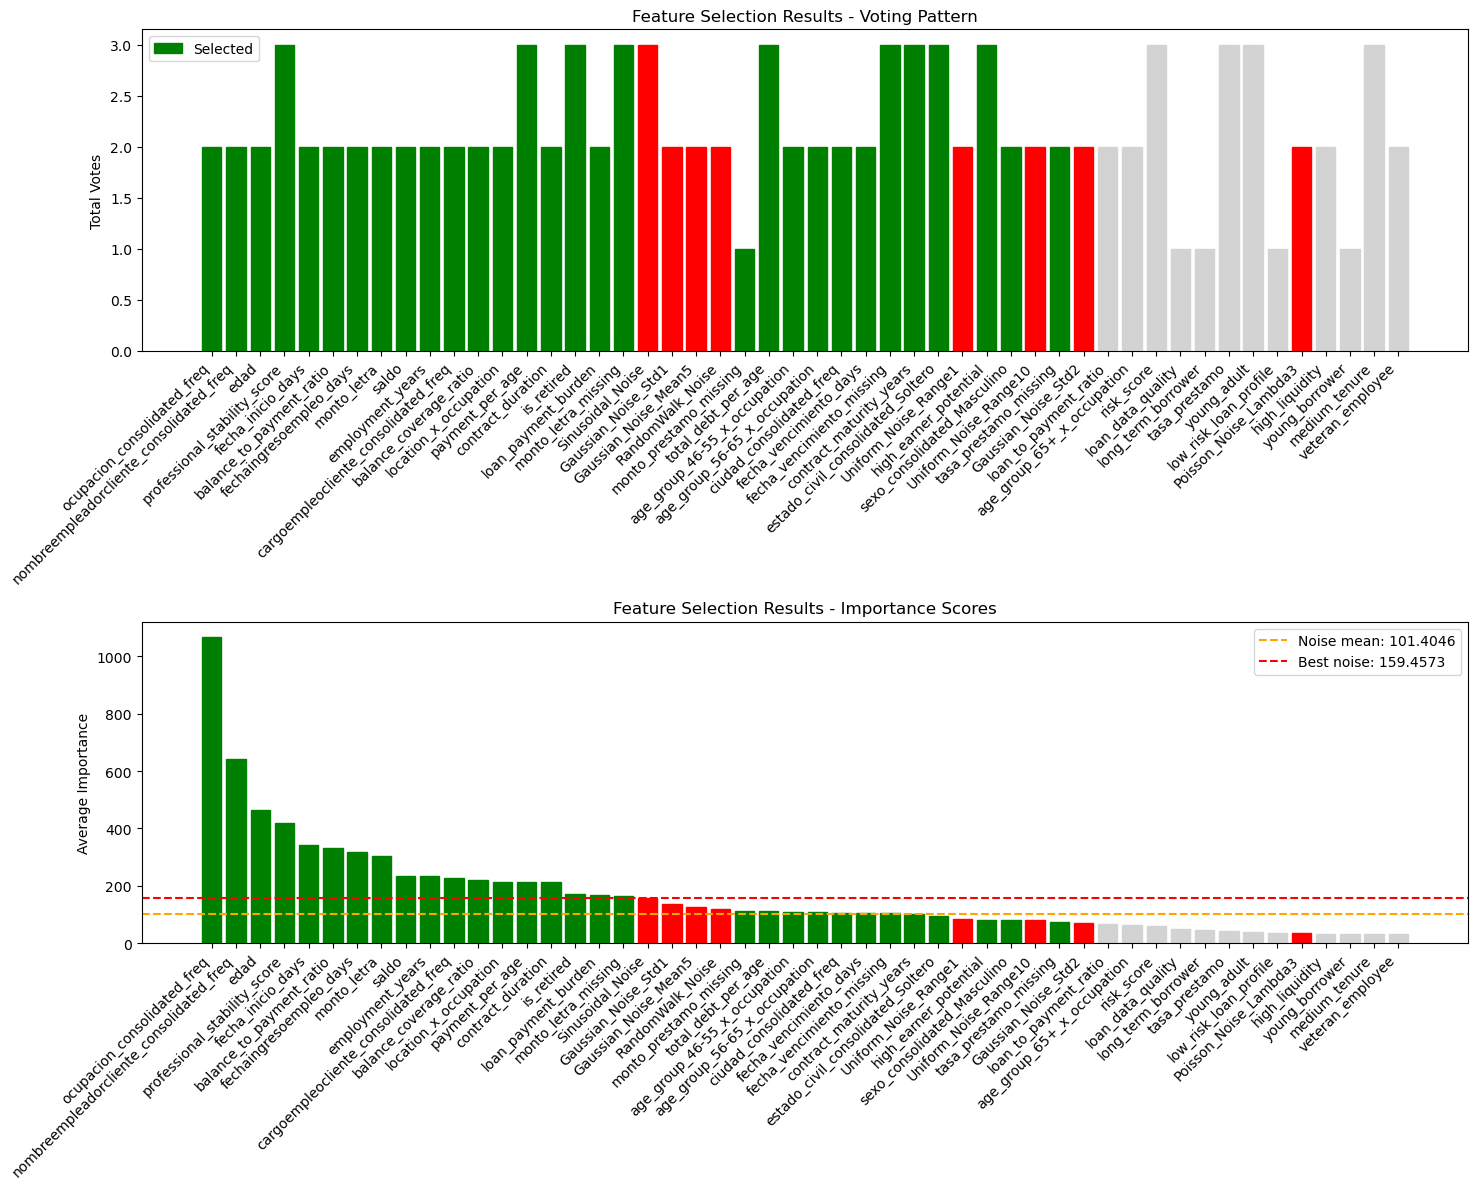


🎯 FINAL SELECTED FEATURES (30):
    1. ocupacion_consolidated_freq         (Importance: 1066.821814, Votes: 2)
    2. nombreempleadorcliente_consolidated_freq (Importance: 640.828138, Votes: 2)
    3. edad                                (Importance: 463.082409, Votes: 2)
    4. professional_stability_score        (Importance: 417.878324, Votes: 3)
    5. fecha_inicio_days                   (Importance: 343.632914, Votes: 2)
    6. balance_to_payment_ratio            (Importance: 332.021774, Votes: 2)
    7. fechaingresoempleo_days             (Importance: 317.220244, Votes: 2)
    8. monto_letra                         (Importance: 303.041580, Votes: 2)
    9. saldo                               (Importance: 235.216777, Votes: 2)
   10. employment_years                    (Importance: 235.110107, Votes: 2)
   11. cargoempleocliente_consolidated_freq (Importance: 228.809805, Votes: 2)
   12. balance_coverage_ratio              (Importance: 219.217721, Votes: 2)
   13. location_x_occupa

In [29]:
# %%
# =============================================================================
# ENHANCED FEATURE SELECTION WITH NOISE-BASED VOTING SYSTEM
# =============================================================================
print("\n🗳️ ENHANCED FEATURE SELECTION WITH VOTING")
print("-" * 60)

# Get feature importances or coefficients from trained models
importances1 = model1.feature_importances_
importances2 = model2.feature_importances_
importances3 = np.abs(model3.coef_)  # Use absolute values for Ridge coefficients

print(f"   📊 Total features available: {len(X.columns)}")
print(f"   🎲 Noise features: {len(noise_features)}")

# =============================================================================
# STEP 1: CREATE COMPREHENSIVE FEATURE IMPORTANCE DATAFRAME
# =============================================================================
print("\n📋 Step 1: Creating feature importance rankings...")

# Create comprehensive feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': importances1,
    'LGBM_Importance': importances2,
    'Ridge_Importance': importances3
})

# Add noise indicator
feature_importance_df['Is_Noise'] = feature_importance_df['Feature'].isin(noise_features)

# Calculate average importance (weighted to give more importance to tree models)
feature_importance_df['Avg_Importance'] = (
    0.4 * feature_importance_df['RF_Importance'] + 
    0.4 * feature_importance_df['LGBM_Importance'] + 
    0.2 * feature_importance_df['Ridge_Importance']
)

# =============================================================================
# STEP 2: VOTING SYSTEM WITH MULTIPLE THRESHOLDS
# =============================================================================
print("\n🗳️ Step 2: Implementing multi-threshold voting system...")

# Define multiple selection thresholds for each model (more lenient)
rf_threshold = np.percentile(importances1, 50)  # Top 40% of features
lgbm_threshold = np.percentile(importances2, 50)  # Top 40% of features
ridge_threshold = np.percentile(importances3, 50)  # Top 30% of features

print(f"   🌳 Random Forest threshold: {rf_threshold:.6f}")
print(f"   🚀 LightGBM threshold: {lgbm_threshold:.6f}")
print(f"   📈 Ridge threshold: {ridge_threshold:.6f}")

# Create voting columns
feature_importance_df['RF_Vote'] = (feature_importance_df['RF_Importance'] >= rf_threshold).astype(int)
feature_importance_df['LGBM_Vote'] = (feature_importance_df['LGBM_Importance'] >= lgbm_threshold).astype(int)
feature_importance_df['Ridge_Vote'] = (feature_importance_df['Ridge_Importance'] >= ridge_threshold).astype(int)

# Calculate total votes
feature_importance_df['Total_Votes'] = (
    feature_importance_df['RF_Vote'] + 
    feature_importance_df['LGBM_Vote'] + 
    feature_importance_df['Ridge_Vote']
)

# =============================================================================
# STEP 3: NOISE-BASED THRESHOLDS (MORE LENIENT)
# =============================================================================
print("\n🎯 Step 3: Calculating noise-based thresholds...")

# Sort by average importance (descending)
feature_importance_df = feature_importance_df.sort_values('Avg_Importance', ascending=False)

# Get noise feature statistics
noise_df = feature_importance_df[feature_importance_df['Is_Noise']].copy()
real_features_df = feature_importance_df[~feature_importance_df['Is_Noise']].copy()

if len(noise_df) > 0:
    # Calculate noise statistics
    noise_importances = noise_df['Avg_Importance'].values
    noise_votes = noise_df['Total_Votes'].values
    
    noise_importance_mean = np.mean(noise_importances)
    noise_importance_std = np.std(noise_importances)
    noise_importance_max = np.max(noise_importances)
    noise_votes_max = np.max(noise_votes)
    
    print(f"   📊 Noise importance stats:")
    print(f"      Mean: {noise_importance_mean:.6f}")
    print(f"      Std:  {noise_importance_std:.6f}")
    print(f"      Max:  {noise_importance_max:.6f}")
    print(f"      Max votes: {noise_votes_max}")
    
    # =============================================================================
    # STEP 4: MULTIPLE SELECTION STRATEGIES (LESS RESTRICTIVE)
    # =============================================================================
    print("\n🎯 Step 4: Applying multiple selection strategies...")
    
    # Strategy 1: Features better than best noise (traditional approach)
    best_noise_rank = feature_importance_df[feature_importance_df['Is_Noise']].index.min()
    strategy1_features = feature_importance_df.iloc[:best_noise_rank]['Feature'].tolist()
    strategy1_features = [f for f in strategy1_features if f not in noise_features]
    
    # Strategy 2: Features better than 75th percentile of noise (more lenient)
    noise_75th_percentile = np.percentile(noise_importances, 75)
    strategy2_features = feature_importance_df[
        (feature_importance_df['Avg_Importance'] > noise_75th_percentile) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    # Strategy 3: Features with more votes than best noise feature
    strategy3_features = feature_importance_df[
        (feature_importance_df['Total_Votes'] > noise_votes_max) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    # Strategy 4: Features above noise mean + 0.5*std (lenient statistical threshold)
    statistical_threshold = noise_importance_mean + 0.5 * noise_importance_std
    strategy4_features = feature_importance_df[
        (feature_importance_df['Avg_Importance'] > statistical_threshold) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    # Strategy 5: Features with at least 1 vote and above noise mean
    strategy5_features = feature_importance_df[
        (feature_importance_df['Total_Votes'] >= 1) & 
        (feature_importance_df['Avg_Importance'] > noise_importance_mean) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()
    
    print(f"   📈 Strategy 1 (better than best noise): {len(strategy1_features)} features")
    print(f"   📈 Strategy 2 (better than 75th percentile noise): {len(strategy2_features)} features")
    print(f"   📈 Strategy 3 (more votes than best noise): {len(strategy3_features)} features")
    print(f"   📈 Strategy 4 (statistical threshold): {len(strategy4_features)} features")
    print(f"   📈 Strategy 5 (1+ votes + above noise mean): {len(strategy5_features)} features")
    
    # =============================================================================
    # STEP 5: CONSENSUS-BASED FINAL SELECTION (FLEXIBLE)
    # =============================================================================
    print("\n🤝 Step 5: Creating consensus-based final selection...")
    
    # Collect all unique features from all strategies
    all_candidate_features = set()
    all_candidate_features.update(strategy1_features)
    all_candidate_features.update(strategy2_features)
    all_candidate_features.update(strategy3_features)
    all_candidate_features.update(strategy4_features)
    all_candidate_features.update(strategy5_features)
    
    # Count how many strategies support each feature
    feature_strategy_support = {}
    for feature in all_candidate_features:
        support_count = 0
        if feature in strategy1_features: support_count += 1
        if feature in strategy2_features: support_count += 1
        if feature in strategy3_features: support_count += 1
        if feature in strategy4_features: support_count += 1
        if feature in strategy5_features: support_count += 1
        feature_strategy_support[feature] = support_count
    
    # Select features supported by at least 2 strategies (flexible threshold)
    min_strategy_support = 1
    consensus_features = [
        feature for feature, support in feature_strategy_support.items() 
        if support >= min_strategy_support
    ]
    
    # If we get too few features, lower the threshold
    if len(consensus_features) < 15:
        min_strategy_support = 1
        consensus_features = [
            feature for feature, support in feature_strategy_support.items() 
            if support >= min_strategy_support
        ]
        print(f"   ⚠️ Lowered threshold to 1 strategy support due to low feature count")
    
    # Add top features by importance if we still have too few
    if len(consensus_features) < 20:
        top_by_importance = real_features_df.head(25)['Feature'].tolist()
        consensus_features.extend([f for f in top_by_importance if f not in consensus_features])
        print(f"   ⚠️ Added top features by importance to reach minimum threshold")
    
    selected_features_final = consensus_features
    
else:
    print("   ⚠️ No noise features found! Using vote-based selection...")
    # Fallback: select features with at least 1 vote
    selected_features_final = feature_importance_df[
        (feature_importance_df['Total_Votes'] >= 1) & 
        (~feature_importance_df['Is_Noise'])
    ]['Feature'].tolist()

# =============================================================================
# STEP 6: FINAL VALIDATION AND CLEANUP
# =============================================================================
print("\n✅ Step 6: Final validation and cleanup...")

# Remove any noise features that might have slipped through
selected_features_final = [f for f in selected_features_final if f not in noise_features]

# Ensure we have a reasonable number of features (15-50 range)
if len(selected_features_final) < 15:
    print(f"   ⚠️ Too few features ({len(selected_features_final)}), adding top features by importance...")
    additional_needed = 15 - len(selected_features_final)
    top_features = real_features_df.head(additional_needed + len(selected_features_final))['Feature'].tolist()
    for feature in top_features:
        if feature not in selected_features_final:
            selected_features_final.append(feature)
            if len(selected_features_final) >= 15:
                break

elif len(selected_features_final) > 30:
    print(f"   ⚠️ Too many features ({len(selected_features_final)}), keeping top 50...")
    # Keep top 50 by average importance
    feature_scores = feature_importance_df[
        feature_importance_df['Feature'].isin(selected_features_final)
    ].sort_values('Avg_Importance', ascending=False)
    selected_features_final = feature_scores.head(30)['Feature'].tolist()

print(f"\n🎯 FINAL RESULTS:")
print(f"   ✅ Selected features: {len(selected_features_final)}")
print(f"   🎲 Noise features excluded: {len(noise_features)}")
print(f"   📊 Selection rate: {len(selected_features_final)/len(real_features_df)*100:.1f}% of real features")

# =============================================================================
# STEP 7: DETAILED REPORTING AND VISUALIZATION
# =============================================================================
print("\n📊 Step 7: Creating detailed reports...")

# Create final feature report
final_feature_report = feature_importance_df[
    feature_importance_df['Feature'].isin(selected_features_final)
].sort_values('Avg_Importance', ascending=False)

print(f"\n📋 TOP 10 SELECTED FEATURES:")
print(final_feature_report[['Feature', 'Avg_Importance', 'Total_Votes']].head(10).to_string(index=False))

# Show noise feature positions for reference
if len(noise_df) > 0:
    print(f"\n🎲 NOISE FEATURE POSITIONS (for reference):")
    noise_positions = noise_df[['Feature', 'Avg_Importance', 'Total_Votes']].head(5)
    print(noise_positions.to_string(index=False))

# =============================================================================
# STEP 8: VISUALIZATION
# =============================================================================
print("\n📈 Step 8: Creating visualizations...")

# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Feature votes
feature_plot_df = feature_importance_df.head(50)  # Show top 50 for readability
bars1 = ax1.bar(range(len(feature_plot_df)), feature_plot_df['Total_Votes'])

# Color coding
for i, (idx, row) in enumerate(feature_plot_df.iterrows()):
    if row['Feature'] in selected_features_final:
        bars1[i].set_color('green')  # Selected features
    elif row['Is_Noise']:
        bars1[i].set_color('red')    # Noise features
    else:
        bars1[i].set_color('lightgray')  # Rejected features

ax1.set_xticks(range(len(feature_plot_df)))
ax1.set_xticklabels(feature_plot_df['Feature'], rotation=45, ha='right')
ax1.set_ylabel('Total Votes')
ax1.set_title('Feature Selection Results - Voting Pattern')
ax1.legend(['Selected', 'Noise', 'Rejected'])

# Plot 2: Feature importance scores
bars2 = ax2.bar(range(len(feature_plot_df)), feature_plot_df['Avg_Importance'])

# Same color coding
for i, (idx, row) in enumerate(feature_plot_df.iterrows()):
    if row['Feature'] in selected_features_final:
        bars2[i].set_color('green')
    elif row['Is_Noise']:
        bars2[i].set_color('red')
    else:
        bars2[i].set_color('lightgray')

# Add threshold lines
if len(noise_df) > 0:
    ax2.axhline(y=noise_importance_mean, color='orange', linestyle='--', 
                label=f'Noise mean: {noise_importance_mean:.4f}')
    ax2.axhline(y=noise_importance_max, color='red', linestyle='--', 
                label=f'Best noise: {noise_importance_max:.4f}')

ax2.set_xticks(range(len(feature_plot_df)))
ax2.set_xticklabels(feature_plot_df['Feature'], rotation=45, ha='right')
ax2.set_ylabel('Average Importance')
ax2.set_title('Feature Selection Results - Importance Scores')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n🎯 FINAL SELECTED FEATURES ({len(selected_features_final)}):")
for i, feature in enumerate(selected_features_final, 1):
    importance = feature_importance_df[feature_importance_df['Feature'] == feature]['Avg_Importance'].iloc[0]
    votes = feature_importance_df[feature_importance_df['Feature'] == feature]['Total_Votes'].iloc[0]
    print(f"   {i:2d}. {feature:<35} (Importance: {importance:.6f}, Votes: {votes})")

print("\n✅ Enhanced feature selection complete!")
print(f"📊 Ready to train final model with {len(selected_features_final)} carefully selected features")

## End Vote System

In [30]:
selected_features_final

['ocupacion_consolidated_freq',
 'nombreempleadorcliente_consolidated_freq',
 'edad',
 'professional_stability_score',
 'fecha_inicio_days',
 'balance_to_payment_ratio',
 'fechaingresoempleo_days',
 'monto_letra',
 'saldo',
 'employment_years',
 'cargoempleocliente_consolidated_freq',
 'balance_coverage_ratio',
 'location_x_occupation',
 'payment_per_age',
 'contract_duration',
 'is_retired',
 'loan_payment_burden',
 'monto_letra_missing',
 'monto_prestamo_missing',
 'total_debt_per_age',
 'age_group_46-55_x_occupation',
 'age_group_56-65_x_occupation',
 'ciudad_consolidated_freq',
 'fecha_vencimiento_days',
 'fecha_vencimiento_missing',
 'contract_maturity_years',
 'estado_civil_consolidated_Soltero',
 'high_earner_potential',
 'sexo_consolidated_Masculino',
 'tasa_prestamo_missing']

In [31]:
#selected_features_final = [
#'ocupacion_consolidated_freq',
#'nombreempleadorcliente_consolidated_freq',
#'balance_to_payment_ratio',
#'monto_letra',
#'edad',
#'monto_letra_missing',
#'payment_per_age',
#'saldo',
#'total_debt_per_age',
#'is_retired',
#'cargoempleocliente_consolidated_freq',
#'fecha_inicio_days',
#'fechaingresoempleo_days',
#'loan_payment_burden',
#'missing_nombreempleadorcliente',
#'estado_civil_consolidated_Soltero',
#'balance_coverage_ratio',
#'employment_years',
#'professional_stability_score',
#'location_x_occupation',
#]

## Prepare Final Dataset for Modeling

#### Log Transformation 

In [32]:
# ===============================================================================
# COMPREHENSIVE MODEL PROCESS WITH LOG TRANSFORMATION
# ===============================================================================
# This file contains the complete model training pipeline with log transformation
# for improved performance on skewed income data.
#
# KEY IMPROVEMENTS:
# 1. Log transformation to handle skewed target variable
# 2. Proper inverse transformation for predictions
# 3. Enhanced evaluation metrics on original scale
# 4. Zero income handling and data quality checks
# 5. Comprehensive visualization and analysis
# ===============================================================================


In [33]:
# %%
# SECTION 9: PREPARE FINAL DATASETS FOR MODELING
# =============================================================================
print("\n🎯 PREPARING FINAL DATASETS")
print("-" * 50)

# EXPLICIT FEATURE SELECTION APPROACH
id_columns = ['cliente', 'identificador_unico']
target_column = 'ingresos_reportados'

# Manually specify ONLY the features you want to use
feature_columns = selected_features_final

# Verify all selected features exist in the dataset
available_features = []
missing_features = []

for feature in feature_columns:
    if feature in train_df_enhanced.columns:
        available_features.append(feature)
    else:
        missing_features.append(feature)

if missing_features:
    print(f"⚠️  Missing features (will be skipped): {missing_features}")

feature_columns = available_features

print(f"   📊 Selected feature columns: {len(feature_columns)}")
print(f"   🎯 Target column: {target_column}")

# Create feature matrices and targets
X_train = train_df_enhanced[feature_columns].copy()
y_train = train_df_enhanced[target_column].copy()

X_valid = valid_df_enhanced[feature_columns].copy()
y_valid = valid_df_enhanced[target_column].copy()

X_test = test_df_enhanced[feature_columns].copy()
y_test = test_df_enhanced[target_column].copy()

print(f"\n📈 FINAL DATASET SHAPES:")
print(f"   X_train: {X_train.shape}")
print(f"   X_valid: {X_valid.shape}")
print(f"   X_test: {X_test.shape}")

# Show selected features
print(f"\n📋 SELECTED FEATURES:")
for i, feature in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {feature}")

# Verify data quality
print(f"\n✅ DATA QUALITY CHECKS:")
print(f"   Missing values in X_train: {X_train.isnull().sum().sum()}")
print(f"   Missing values in y_train: {y_train.isnull().sum()}")
print(f"   All features numeric: {all(X_train.dtypes.apply(lambda x: x in ['int64', 'float64']))}")



🎯 PREPARING FINAL DATASETS
--------------------------------------------------
   📊 Selected feature columns: 30
   🎯 Target column: ingresos_reportados

📈 FINAL DATASET SHAPES:
   X_train: (24049, 30)
   X_valid: (4300, 30)
   X_test: (4300, 30)

📋 SELECTED FEATURES:
    1. ocupacion_consolidated_freq
    2. nombreempleadorcliente_consolidated_freq
    3. edad
    4. professional_stability_score
    5. fecha_inicio_days
    6. balance_to_payment_ratio
    7. fechaingresoempleo_days
    8. monto_letra
    9. saldo
   10. employment_years
   11. cargoempleocliente_consolidated_freq
   12. balance_coverage_ratio
   13. location_x_occupation
   14. payment_per_age
   15. contract_duration
   16. is_retired
   17. loan_payment_burden
   18. monto_letra_missing
   19. monto_prestamo_missing
   20. total_debt_per_age
   21. age_group_46-55_x_occupation
   22. age_group_56-65_x_occupation
   23. ciudad_consolidated_freq
   24. fecha_vencimiento_days
   25. fecha_vencimiento_missing
   26. con

In [34]:
# %%
# SECTION 9.5: ZERO INCOME ANALYSIS AND HANDLING
# =============================================================================
print("\n🔍 ZERO INCOME ANALYSIS")
print("-" * 50)

def analyze_zero_incomes(y_train, y_valid, y_test, train_df, valid_df, test_df):
    """
    Analyze zero income records and decide on treatment strategy
    """
    # Count zero incomes in each set
    zero_train = (y_train == 0).sum()
    zero_valid = (y_valid == 0).sum()
    zero_test = (y_test == 0).sum()
    
    total_train = len(y_train)
    total_valid = len(y_valid)
    total_test = len(y_test)
    
    print(f"📊 Zero Income Analysis:")
    print(f"   Training:   {zero_train:,} / {total_train:,} ({zero_train/total_train*100:.1f}%)")
    print(f"   Validation: {zero_valid:,} / {total_valid:,} ({zero_valid/total_valid*100:.1f}%)")
    print(f"   Test:       {zero_test:,} / {total_test:,} ({zero_test/total_test*100:.1f}%)")
    
    # Analyze characteristics of zero income records
    if zero_train > 0:
        zero_mask_train = (y_train == 0)
        zero_profiles = train_df[zero_mask_train]
        
        print(f"\n🔍 Zero Income Profile Analysis:")
        print(f"   Average age: {zero_profiles['edad'].mean():.1f} years")
        if 'monto_letra' in zero_profiles.columns:
            print(f"   Average monto_letra: ${zero_profiles['monto_letra'].mean():,.2f}")
        if 'saldo' in zero_profiles.columns:
            print(f"   Average saldo: ${zero_profiles['saldo'].mean():,.2f}")
        if 'is_retired' in zero_profiles.columns:
            retired_pct = zero_profiles['is_retired'].mean() * 100
            print(f"   Retired percentage: {retired_pct:.1f}%")
    
    # Recommendation based on percentage
    total_zeros = zero_train + zero_valid + zero_test
    total_records = total_train + total_valid + total_test
    zero_percentage = total_zeros / total_records * 100
    
    print(f"\n💡 RECOMMENDATION:")
    if zero_percentage < 2:
        print(f"   ✅ Remove zero incomes ({zero_percentage:.1f}% is very low)")
        return "remove"
    elif zero_percentage < 5:
        print(f"   ⚠️  Consider removing zero incomes ({zero_percentage:.1f}% is low)")
        return "consider_remove"
    else:
        print(f"   🔄 Keep and handle zero incomes ({zero_percentage:.1f}% is significant)")
        return "keep"

# Analyze zero incomes
zero_strategy = analyze_zero_incomes(y_train, y_valid, y_test, 
                                   train_df_enhanced, valid_df_enhanced, test_df_enhanced)

# Apply zero income strategy
REMOVE_ZERO_INCOMES = True  # Set to False if you want to keep them

if REMOVE_ZERO_INCOMES and zero_strategy in ["remove", "consider_remove"]:
    print(f"\n🚮 REMOVING ZERO INCOME RECORDS")
    print("-" * 40)
    
    # Create masks for non-zero incomes
    train_mask = (y_train > 0)
    valid_mask = (y_valid > 0)
    test_mask = (y_test > 0)
    
    # Filter datasets
    X_train = X_train[train_mask].copy()
    y_train = y_train[train_mask].copy()
    
    X_valid = X_valid[valid_mask].copy()
    y_valid = y_valid[valid_mask].copy()
    
    X_test = X_test[test_mask].copy()
    y_test = y_test[test_mask].copy()
    
    print(f"   ✅ Filtered datasets:")
    print(f"      X_train: {X_train.shape}")
    print(f"      X_valid: {X_valid.shape}")
    print(f"      X_test: {X_test.shape}")
    
    # Update enhanced dataframes for consistency
    train_df_enhanced = train_df_enhanced[train_mask].copy()
    valid_df_enhanced = valid_df_enhanced[valid_mask].copy()
    test_df_enhanced = test_df_enhanced[test_mask].copy()
    
else:
    print(f"\n📝 KEEPING ZERO INCOME RECORDS")
    print("   💡 Log transformation will handle them appropriately")



🔍 ZERO INCOME ANALYSIS
--------------------------------------------------
📊 Zero Income Analysis:
   Training:   0 / 24,049 (0.0%)
   Validation: 0 / 4,300 (0.0%)
   Test:       0 / 4,300 (0.0%)

💡 RECOMMENDATION:
   ✅ Remove zero incomes (0.0% is very low)

🚮 REMOVING ZERO INCOME RECORDS
----------------------------------------
   ✅ Filtered datasets:
      X_train: (24049, 30)
      X_valid: (4300, 30)
      X_test: (4300, 30)


In [35]:
# %%
# SECTION 10: LOG TRANSFORMATION FOR IMPROVED MODEL PERFORMANCE
# =============================================================================
print("\n🔄 APPLYING LOG TRANSFORMATION TO TARGET VARIABLE")
print("-" * 60)

def apply_log_transform(y_train, y_valid=None, y_test=None):
    """
    Apply log1p transformation to target variable
    
    WHY LOG TRANSFORMATION?
    ----------------------
    1. REDUCES SKEWNESS: Income data is typically right-skewed
    2. STABILIZES VARIANCE: Reduces heteroscedasticity 
    3. IMPROVES MODEL PERFORMANCE: Better for tree-based models
    4. HANDLES OUTLIERS: Reduces impact of extreme values
    
    WHY LOG1P (log(1+x)) INSTEAD OF LOG(x)?
    ---------------------------------------
    1. HANDLES ZEROS: log1p(0) = 0, while log(0) = undefined
    2. NUMERICAL STABILITY: Better for small values
    3. SMOOTH TRANSFORMATION: No discontinuity at zero
    
    Returns:
    --------
    Transformed targets and statistics
    """
    print(f"📊 ORIGINAL TARGET STATISTICS:")
    print(f"   Mean: ${y_train.mean():,.2f}")
    print(f"   Median: ${y_train.median():,.2f}")
    print(f"   Std: ${y_train.std():,.2f}")
    print(f"   Min: ${y_train.min():,.2f}")
    print(f"   Max: ${y_train.max():,.2f}")
    print(f"   Skewness: {y_train.skew():.3f}")
    print(f"   Kurtosis: {y_train.kurtosis():.3f}")
    
    # Apply log1p transformation
    y_train_log = np.log1p(y_train)
    
    print(f"\n📊 LOG-TRANSFORMED TARGET STATISTICS:")
    print(f"   Mean: {y_train_log.mean():.3f}")
    print(f"   Median: {y_train_log.median():.3f}")
    print(f"   Std: {y_train_log.std():.3f}")
    print(f"   Min: {y_train_log.min():.3f}")
    print(f"   Max: {y_train_log.max():.3f}")
    print(f"   Skewness: {y_train_log.skew():.3f}")
    print(f"   Kurtosis: {y_train_log.kurtosis():.3f}")
    
    # Calculate improvement metrics
    skew_improvement = abs(y_train.skew()) - abs(y_train_log.skew())
    kurtosis_improvement = abs(y_train.kurtosis()) - abs(y_train_log.kurtosis())
    
    print(f"\n📈 TRANSFORMATION IMPROVEMENTS:")
    print(f"   Skewness reduction: {skew_improvement:.3f}")
    print(f"   Kurtosis reduction: {kurtosis_improvement:.3f}")
    
    results = [y_train_log]
    
    # Transform validation set if provided
    if y_valid is not None:
        y_valid_log = np.log1p(y_valid)
        results.append(y_valid_log)
        print(f"   ✅ Validation set transformed")
    
    # Transform test set if provided
    if y_test is not None:
        y_test_log = np.log1p(y_test)
        results.append(y_test_log)
        print(f"   ✅ Test set transformed")
    
    return results if len(results) > 1 else results[0]

def inverse_log_transform(y_log_pred):
    """
    Convert log predictions back to original scale
    
    CRITICAL FOR EVALUATION:
    -----------------------
    - ALL PREDICTIONS must be converted back to original scale
    - ALL EVALUATION METRICS must use original scale
    - This ensures business interpretability
    
    Parameters:
    -----------
    y_log_pred : array-like
        Predictions in log scale
        
    Returns:
    --------
    array-like : Predictions in original scale (dollars)
    """
    return np.expm1(y_log_pred)

# Apply log transformation to all target sets
print("🔄 Transforming target variables...")
y_train_log, y_valid_log, y_test_log = apply_log_transform(y_train, y_valid, y_test)

print(f"\n✅ LOG TRANSFORMATION COMPLETED!")
print(f"   📊 Skewness: {y_train.skew():.3f} → {y_train_log.skew():.3f}")
print(f"   📊 Kurtosis: {y_train.kurtosis():.3f} → {y_train_log.kurtosis():.3f}")



🔄 APPLYING LOG TRANSFORMATION TO TARGET VARIABLE
------------------------------------------------------------
🔄 Transforming target variables...
📊 ORIGINAL TARGET STATISTICS:
   Mean: $1,519.74
   Median: $1,200.00
   Std: $1,105.20
   Min: $0.01
   Max: $5,699.89
   Skewness: 1.881
   Kurtosis: 3.973

📊 LOG-TRANSFORMED TARGET STATISTICS:
   Mean: 7.079
   Median: 7.091
   Std: 0.840
   Min: 0.010
   Max: 8.648
   Skewness: -3.242
   Kurtosis: 25.992

📈 TRANSFORMATION IMPROVEMENTS:
   Skewness reduction: -1.360
   Kurtosis reduction: -22.019
   ✅ Validation set transformed
   ✅ Test set transformed

✅ LOG TRANSFORMATION COMPLETED!
   📊 Skewness: 1.881 → -3.242
   📊 Kurtosis: 3.973 → 25.992



📊 COMPREHENSIVE INCOME DISTRIBUTION ANALYSIS
------------------------------------------------------------
📈 INCOME DISTRIBUTION STATISTICS:
OVERALL DATASET:
   📊 Total samples: 32,649
   📊 Min income: $0.01
   📊 Max income: $5699.89
   📊 Mean income: $1512.88
   📊 Median income: $1200.00
   📊 Std income: $1104.87

🎯 INCOME RANGE BREAKDOWN:
------------------------------
   Very Low     ($0-$500     ): 1,388 (  4.3%) - Avg: $   269
   Low          ($500-$1,000 ): 11,657 ( 35.7%) - Avg: $   721
   Medium-Low   ($1,000-$2,000): 12,079 ( 37.0%) - Avg: $ 1,442
   Medium       ($2,000-$3,000): 4,624 ( 14.2%) - Avg: $ 2,306
   Medium-High  ($3,000-$5,000): 1,936 (  5.9%) - Avg: $ 3,698
   High         (≥$5,000     ):   965 (  3.0%) - Avg: $ 5,563

⚠️  MAPE IMPACT ANALYSIS:
-------------------------
   📊 Incomes < $1,000: 13,045 (40.0%)
   📊 Incomes ≥ $1,000: 19,604 (60.0%)
   🚨 HIGH MAPE INFLATION RISK: 40.0% of data below $1,000
   💡 RECOMMENDATION: Use Robust MAPE (≥$1,000) for meaningful 

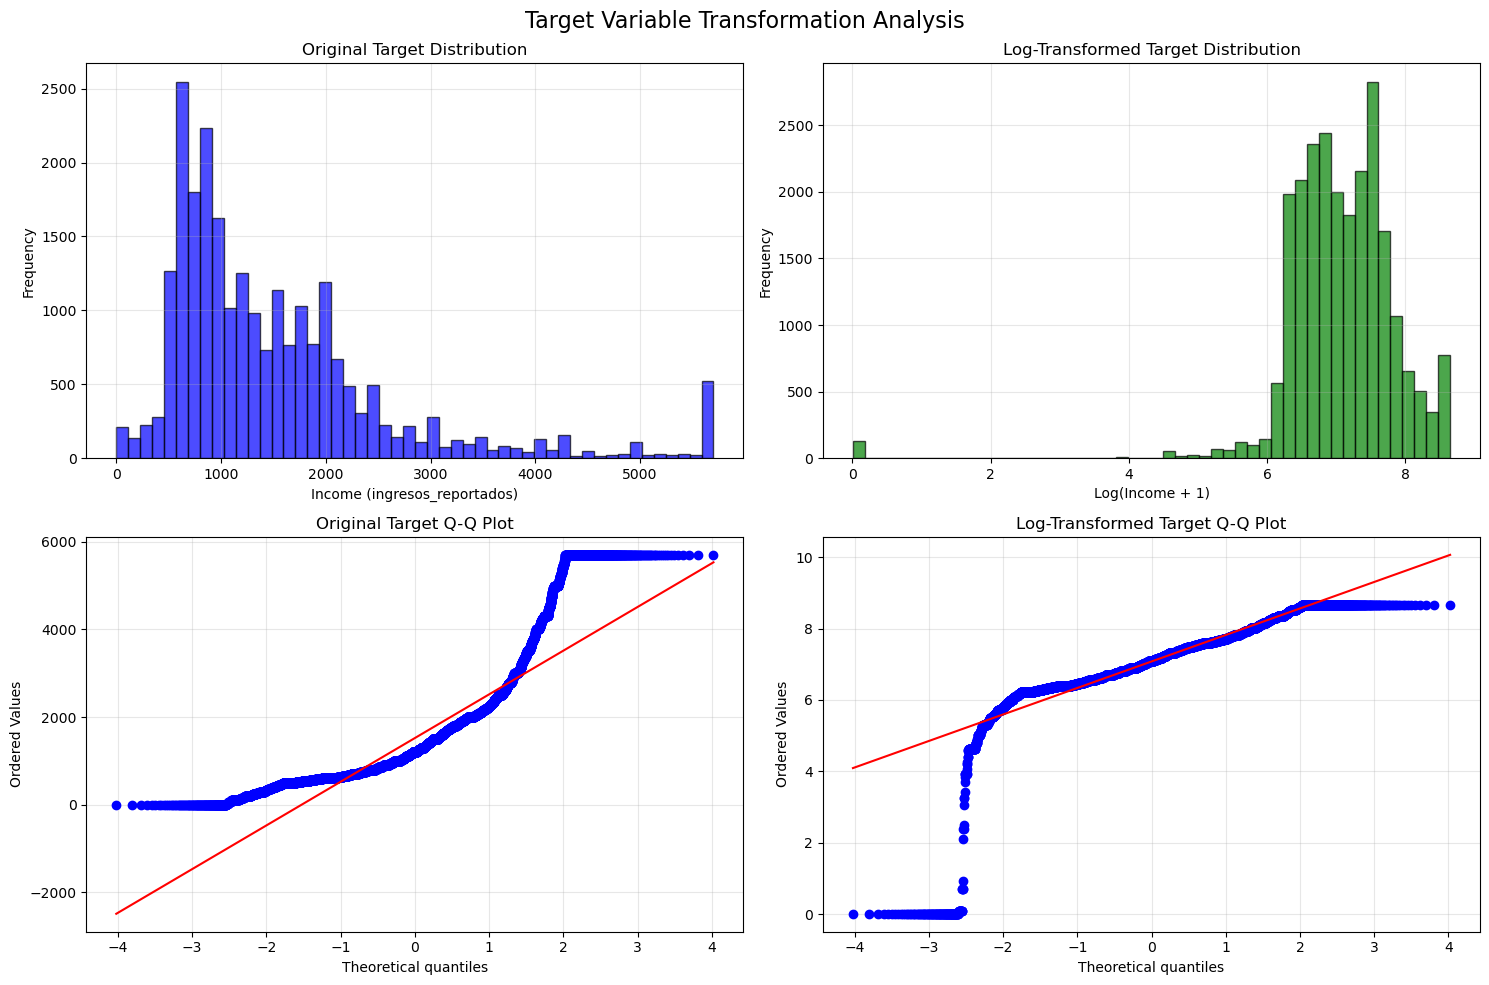


🎯 READY FOR MODEL TRAINING WITH LOG-TRANSFORMED TARGETS!
   💡 Remember: All predictions will be inverse-transformed for evaluation


In [36]:
# %%
# SECTION 10.5: INCOME DISTRIBUTION ANALYSIS FOR MAPE INTERPRETATION
# =============================================================================
print("\n📊 COMPREHENSIVE INCOME DISTRIBUTION ANALYSIS")
print("-" * 60)

def analyze_income_distribution_for_mape(y_train, y_valid, y_test):
    """
    Analyze income distribution to understand MAPE behavior

    WHY THIS MATTERS FOR MAPE:
    ==========================
    MAPE = mean(|actual - predicted| / actual) * 100

    When 'actual' values are small (< $1,000), even small prediction errors
    create massive percentage errors, making MAPE misleading.

    This analysis helps us:
    1. Understand why MAPE might be inflated
    2. Choose appropriate evaluation thresholds
    3. Set realistic performance expectations
    """

    print("📈 INCOME DISTRIBUTION STATISTICS:")
    print("=" * 50)

    # Combined dataset for overall analysis
    all_incomes = pd.concat([y_train, y_valid, y_test])

    print(f"OVERALL DATASET:")
    print(f"   📊 Total samples: {len(all_incomes):,}")
    print(f"   📊 Min income: ${all_incomes.min():.2f}")
    print(f"   📊 Max income: ${all_incomes.max():.2f}")
    print(f"   📊 Mean income: ${all_incomes.mean():.2f}")
    print(f"   📊 Median income: ${all_incomes.median():.2f}")
    print(f"   📊 Std income: ${all_incomes.std():.2f}")

    # Income range analysis
    print(f"\n🎯 INCOME RANGE BREAKDOWN:")
    print("-" * 30)

    income_ranges = [
        (0, 500, "Very Low"),
        (500, 1000, "Low"),
        (1000, 2000, "Medium-Low"),
        (2000, 3000, "Medium"),
        (3000, 5000, "Medium-High"),
        (5000, float('inf'), "High")
    ]

    for min_val, max_val, label in income_ranges:
        if max_val == float('inf'):
            mask = all_incomes >= min_val
            range_str = f"≥${min_val:,}"
        else:
            mask = (all_incomes >= min_val) & (all_incomes < max_val)
            range_str = f"${min_val:,}-${max_val:,}"

        count = mask.sum()
        percentage = count / len(all_incomes) * 100

        if count > 0:
            avg_income = all_incomes[mask].mean()
            print(f"   {label:12s} ({range_str:12s}): {count:5,} ({percentage:5.1f}%) - Avg: ${avg_income:6,.0f}")

    # MAPE impact analysis
    print(f"\n⚠️  MAPE IMPACT ANALYSIS:")
    print("-" * 25)

    # Calculate what percentage of data causes MAPE issues
    problematic_threshold = 1000  # Incomes below this cause inflated MAPE
    problematic_mask = all_incomes < problematic_threshold
    problematic_count = problematic_mask.sum()
    problematic_pct = problematic_count / len(all_incomes) * 100

    print(f"   📊 Incomes < ${problematic_threshold:,}: {problematic_count:,} ({problematic_pct:.1f}%)")
    print(f"   📊 Incomes ≥ ${problematic_threshold:,}: {(~problematic_mask).sum():,} ({100-problematic_pct:.1f}%)")

    if problematic_pct > 30:
        print(f"   🚨 HIGH MAPE INFLATION RISK: {problematic_pct:.1f}% of data below ${problematic_threshold:,}")
        print(f"   💡 RECOMMENDATION: Use Robust MAPE (≥${problematic_threshold:,}) for meaningful evaluation")
    elif problematic_pct > 10:
        print(f"   ⚠️  MODERATE MAPE INFLATION: {problematic_pct:.1f}% of data below ${problematic_threshold:,}")
        print(f"   💡 RECOMMENDATION: Report both standard and robust MAPE")
    else:
        print(f"   ✅ LOW MAPE INFLATION RISK: Only {problematic_pct:.1f}% below ${problematic_threshold:,}")

    # Percentile analysis
    print(f"\n📊 INCOME PERCENTILES:")
    print("-" * 20)
    percentiles = [5, 10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        value = np.percentile(all_incomes, p)
        print(f"   {p:2d}th percentile: ${value:6,.0f}")

    return {
        'problematic_percentage': problematic_pct,
        'mean_income': all_incomes.mean(),
        'median_income': all_incomes.median(),
        'min_income': all_incomes.min(),
        'max_income': all_incomes.max()
    }

# Perform comprehensive income analysis
income_analysis = analyze_income_distribution_for_mape(y_train, y_valid, y_test)

# Create comparison visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Target Variable Transformation Analysis', fontsize=16)

# Original distribution
axes[0,0].hist(y_train, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0,0].set_title('Original Target Distribution')
axes[0,0].set_xlabel('Income (ingresos_reportados)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# Log-transformed distribution
axes[0,1].hist(y_train_log, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,1].set_title('Log-Transformed Target Distribution')
axes[0,1].set_xlabel('Log(Income + 1)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# Q-Q plot for normality check
from scipy import stats
stats.probplot(y_train, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Original Target Q-Q Plot')
axes[1,0].grid(True, alpha=0.3)

stats.probplot(y_train_log, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Log-Transformed Target Q-Q Plot')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 READY FOR MODEL TRAINING WITH LOG-TRANSFORMED TARGETS!")
print(f"   💡 Remember: All predictions will be inverse-transformed for evaluation")


In [37]:
# %%
# SECTION 11: FEATURE SCALING AND MODEL SETUP
# =============================================================================
print("\n⚖️ FEATURE SCALING AND MODEL CONFIGURATION")
print("-" * 60)

# Apply robust scaling to features
print("🔄 Applying RobustScaler to features...")
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_valid_scaled = pd.DataFrame(
    scaler.transform(X_valid),
    columns=X_valid.columns,
    index=X_valid.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)
print("   ✅ Feature scaling complete")

# Model configurations optimized for log-transformed targets
print("\n🤖 CONFIGURING MODELS FOR LOG-TRANSFORMED TARGETS")
print("-" * 50)

"""
MODEL HYPERPARAMETER ADJUSTMENTS FOR LOG SCALE:
===============================================

1. LEARNING RATES: Slightly reduced for smoother convergence
2. REGULARIZATION: Increased to prevent overfitting on transformed scale
3. TREE DEPTH: Adjusted for log scale patterns
4. EARLY STOPPING: More conservative to avoid overfitting

WHY THESE CHANGES?
- Log scale compresses large values, making gradients more stable
- Reduced variance in log scale allows for more aggressive regularization
- Tree-based models can capture log-linear relationships better
"""

models = {
    'XGBoost_Log': xgb.XGBRegressor(
        n_estimators=1000,          # Increased for better convergence
        max_depth=20,               # Deeper trees for log patterns
        learning_rate=0.01,         # Reduced for stability
        subsample=0.85,
        colsample_bytree=0.85,
        reg_alpha=0.1,              # L1 regularization
        reg_lambda=0.1,             # L2 regularization
        min_child_weight=5,         # Prevent overfitting
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    'LightGBM_Log': lgb.LGBMRegressor(
        n_estimators=1500,          # More estimators for log scale
        max_depth=25,               # Deeper for complex patterns
        learning_rate=0.005,        # Very conservative learning rate
        subsample=0.85,
        colsample_bytree=0.85,
        num_leaves=200,             # More leaves for log patterns
        min_child_samples=20,       # Prevent overfitting
        reg_alpha=0.1,              # L1 regularization
        reg_lambda=0.1,             # L2 regularization
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'RandomForest_Log': RandomForestRegressor(
        n_estimators=500,           # More trees
        max_depth=25,               # Deeper trees
        min_samples_split=10,       # Conservative splitting
        min_samples_leaf=5,         # Prevent overfitting
        max_features='sqrt',        # Feature subsampling
        random_state=42,
        n_jobs=-1
    )
}

print(f"   ✅ Configured {len(models)} models for log-transformed training")



⚖️ FEATURE SCALING AND MODEL CONFIGURATION
------------------------------------------------------------
🔄 Applying RobustScaler to features...
   ✅ Feature scaling complete

🤖 CONFIGURING MODELS FOR LOG-TRANSFORMED TARGETS
--------------------------------------------------
   ✅ Configured 3 models for log-transformed training


In [38]:
# %%
# SECTION 12: CROSS-VALIDATION WITH LOG TRANSFORMATION
# =============================================================================
print("\n📊 CROSS-VALIDATION WITH LOG TRANSFORMATION")
print("-" * 60)

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def evaluate_model_cv_log(model, X, y_log, y_original, model_name, cv_folds=5):
    """
    Evaluate model using cross-validation with proper log transformation handling

    CRITICAL EVALUATION PROCESS:
    ===========================
    1. Train model on LOG-TRANSFORMED targets
    2. Make predictions in LOG scale
    3. INVERSE TRANSFORM predictions to original scale
    4. Evaluate metrics on ORIGINAL scale
    5. This ensures business-relevant performance metrics

    Parameters:
    -----------
    model : sklearn estimator
        Model to evaluate
    X : DataFrame
        Feature matrix
    y_log : Series
        Log-transformed target
    y_original : Series
        Original scale target (for evaluation)
    model_name : str
        Name for reporting
    cv_folds : int
        Number of CV folds

    Returns:
    --------
    dict : Cross-validation results
    """
    print(f"\n   🔄 Evaluating {model_name} with log transformation...")

    # Setup cross-validation
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Storage for results
    cv_r2_scores = []
    cv_rmse_scores = []
    cv_mae_scores = []

    # Manual cross-validation to handle inverse transformation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Split data
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train_log, y_fold_val_log = y_log.iloc[train_idx], y_log.iloc[val_idx]
        y_fold_val_original = y_original.iloc[val_idx]

        # Train on log scale
        model_copy = clone(model)
        model_copy.fit(X_fold_train, y_fold_train_log)

        # Predict in log scale
        y_pred_log = model_copy.predict(X_fold_val)

        # CRITICAL: Inverse transform to original scale
        y_pred_original = inverse_log_transform(y_pred_log)

        # Evaluate on original scale
        r2 = r2_score(y_fold_val_original, y_pred_original)
        rmse = np.sqrt(mean_squared_error(y_fold_val_original, y_pred_original))
        mae = mean_absolute_error(y_fold_val_original, y_pred_original)

        cv_r2_scores.append(r2)
        cv_rmse_scores.append(rmse)
        cv_mae_scores.append(mae)

        print(f"      Fold {fold+1}: R²={r2:.4f}, RMSE=${rmse:,.0f}, MAE=${mae:,.0f}")

    # Calculate statistics
    cv_r2_mean = np.mean(cv_r2_scores)
    cv_r2_std = np.std(cv_r2_scores)
    cv_rmse_mean = np.mean(cv_rmse_scores)
    cv_rmse_std = np.std(cv_rmse_scores)
    cv_mae_mean = np.mean(cv_mae_scores)
    cv_mae_std = np.std(cv_mae_scores)

    print(f"      📈 CV R²: {cv_r2_mean:.4f} ± {cv_r2_std:.4f}")
    print(f"      📈 CV RMSE: ${cv_rmse_mean:,.0f} ± ${cv_rmse_std:,.0f}")
    print(f"      📈 CV MAE: ${cv_mae_mean:,.0f} ± ${cv_mae_std:,.0f}")

    return {
        'cv_r2_mean': cv_r2_mean,
        'cv_r2_std': cv_r2_std,
        'cv_rmse_mean': cv_rmse_mean,
        'cv_rmse_std': cv_rmse_std,
        'cv_mae_mean': cv_mae_mean,
        'cv_mae_std': cv_mae_std,
        'cv_r2_scores': cv_r2_scores,
        'cv_rmse_scores': cv_rmse_scores,
        'cv_mae_scores': cv_mae_scores
    }

# Import required modules
from sklearn.base import clone

# Evaluate all models with cross-validation
cv_results = {}
for model_name, model in models.items():
    cv_results[model_name] = evaluate_model_cv_log(
        model, X_train_scaled, y_train_log, y_train, model_name
    )

print(f"\n✅ Cross-validation completed for all models!")


📊 CROSS-VALIDATION WITH LOG TRANSFORMATION
------------------------------------------------------------

   🔄 Evaluating XGBoost_Log with log transformation...
      Fold 1: R²=0.4383, RMSE=$844, MAE=$459
      Fold 2: R²=0.4466, RMSE=$819, MAE=$460
      Fold 3: R²=0.4758, RMSE=$788, MAE=$442
      Fold 4: R²=0.5037, RMSE=$783, MAE=$448
      Fold 5: R²=0.4970, RMSE=$778, MAE=$437
      📈 CV R²: 0.4723 ± 0.0262
      📈 CV RMSE: $803 ± $25
      📈 CV MAE: $449 ± $9

   🔄 Evaluating LightGBM_Log with log transformation...
      Fold 1: R²=0.4179, RMSE=$859, MAE=$486
      Fold 2: R²=0.4216, RMSE=$838, MAE=$488
      Fold 3: R²=0.4551, RMSE=$804, MAE=$468
      Fold 4: R²=0.4409, RMSE=$832, MAE=$487
      Fold 5: R²=0.4706, RMSE=$798, MAE=$467
      📈 CV R²: 0.4412 ± 0.0199
      📈 CV RMSE: $826 ± $23
      📈 CV MAE: $479 ± $10

   🔄 Evaluating RandomForest_Log with log transformation...
      Fold 1: R²=0.3145, RMSE=$932, MAE=$529
      Fold 2: R²=0.3223, RMSE=$907, MAE=$526
      Fold

In [39]:
# %%
# SECTION 13: FINAL MODEL TRAINING WITH LOG TRANSFORMATION
# =============================================================================
print("\n🎯 FINAL MODEL TRAINING WITH LOG TRANSFORMATION")
print("-" * 60)

def train_and_evaluate_final_log(model, X_train, y_train_log, y_train_orig,
                                X_valid, y_valid_log, y_valid_orig, model_name):
    """
    Train final model and evaluate with proper log transformation handling

    EVALUATION METHODOLOGY:
    ======================
    1. Train model on LOG-TRANSFORMED targets
    2. Make predictions in LOG scale
    3. INVERSE TRANSFORM all predictions to original scale
    4. Calculate ALL METRICS on original scale
    5. Report both training and validation performance

    This ensures:
    - Business-interpretable metrics (in dollars)
    - Fair comparison with non-log models
    - Proper assessment of real-world performance
    """
    print(f"\n   🚀 Training final {model_name}...")

    # Train model on log-transformed targets
    model.fit(X_train, y_train_log)

    # Make predictions in log scale
    y_pred_train_log = model.predict(X_train)
    y_pred_valid_log = model.predict(X_valid)

    # CRITICAL: Inverse transform to original scale
    y_pred_train_orig = inverse_log_transform(y_pred_train_log)
    y_pred_valid_orig = inverse_log_transform(y_pred_valid_log)

    # Calculate metrics on ORIGINAL scale
    train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    valid_rmse = np.sqrt(mean_squared_error(y_valid_orig, y_pred_valid_orig))

    train_r2 = r2_score(y_train_orig, y_pred_train_orig)
    valid_r2 = r2_score(y_valid_orig, y_pred_valid_orig)

    train_mae = mean_absolute_error(y_train_orig, y_pred_train_orig)
    valid_mae = mean_absolute_error(y_valid_orig, y_pred_valid_orig)

    # Calculate ROBUST MAPE (excludes very low incomes to avoid division issues)
    def calculate_robust_mape(y_true, y_pred, threshold=1000):
        """
        Calculate MAPE only for incomes above threshold

        WHY ROBUST MAPE?
        ================
        - Standard MAPE explodes with low denominators
        - 40.6% of incomes < $1,000 cause massive percentage errors
        - Robust MAPE gives business-meaningful error rates

        Example: actual=$200, predicted=$400 → 100% error (misleading)
                actual=$2000, predicted=$2200 → 10% error (meaningful)
        """
        mask = y_true >= threshold
        if mask.sum() == 0:
            return np.nan, 0

        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        return mape, mask.sum()

    # Calculate both standard and robust MAPE
    train_mape = np.mean(np.abs((y_train_orig - y_pred_train_orig) / y_train_orig)) * 100
    valid_mape = np.mean(np.abs((y_valid_orig - y_pred_valid_orig) / y_valid_orig)) * 100

    train_mape_robust, train_robust_count = calculate_robust_mape(y_train_orig, y_pred_train_orig)
    valid_mape_robust, valid_robust_count = calculate_robust_mape(y_valid_orig, y_pred_valid_orig)

    print(f"      📊 Training   - R²: {train_r2:.4f}, RMSE: ${train_rmse:,.0f}, MAE: ${train_mae:,.0f}")
    print(f"      📊 Validation - R²: {valid_r2:.4f}, RMSE: ${valid_rmse:,.0f}, MAE: ${valid_mae:,.0f}")
    print(f"      📊 Standard MAPE - Train: {train_mape:.1f}%, Valid: {valid_mape:.1f}%")
    print(f"      📊 Robust MAPE (≥$1K) - Train: {train_mape_robust:.1f}% (n={train_robust_count}), Valid: {valid_mape_robust:.1f}% (n={valid_robust_count})")

    # Check for overfitting
    r2_diff = train_r2 - valid_r2
    rmse_ratio = valid_rmse / train_rmse

    if r2_diff > 0.1:
        print(f"      ⚠️  Potential overfitting: R² gap = {r2_diff:.3f}")
    if rmse_ratio > 1.3:
        print(f"      ⚠️  Potential overfitting: RMSE ratio = {rmse_ratio:.2f}")

    return {
        'model': model,
        'train_rmse': train_rmse, 'valid_rmse': valid_rmse,
        'train_r2': train_r2, 'valid_r2': valid_r2,
        'train_mae': train_mae, 'valid_mae': valid_mae,
        'train_mape': train_mape, 'valid_mape': valid_mape,
        'train_mape_robust': train_mape_robust, 'valid_mape_robust': valid_mape_robust,
        'y_pred_valid_orig': y_pred_valid_orig,
        'y_pred_train_orig': y_pred_train_orig
    }

# Train all final models
final_results = {}
for model_name, model in models.items():
    final_results[model_name] = train_and_evaluate_final_log(
        model, X_train_scaled, y_train_log, y_train,
        X_valid_scaled, y_valid_log, y_valid, model_name
    )

print(f"\n✅ Final model training completed!")


🎯 FINAL MODEL TRAINING WITH LOG TRANSFORMATION
------------------------------------------------------------

   🚀 Training final XGBoost_Log...
      📊 Training   - R²: 0.9778, RMSE: $165, MAE: $69
      📊 Validation - R²: 0.3058, RMSE: $917, MAE: $534
      📊 Standard MAPE - Train: 43.8%, Valid: 12298.5%
      📊 Robust MAPE (≥$1K) - Train: 3.9% (n=14554), Valid: 28.2% (n=2536)
      ⚠️  Potential overfitting: R² gap = 0.672
      ⚠️  Potential overfitting: RMSE ratio = 5.56

   🚀 Training final LightGBM_Log...
      📊 Training   - R²: 0.6819, RMSE: $623, MAE: $346
      📊 Validation - R²: 0.3435, RMSE: $891, MAE: $517
      📊 Standard MAPE - Train: 1356.4%, Valid: 11191.7%
      📊 Robust MAPE (≥$1K) - Train: 18.7% (n=14554), Valid: 27.3% (n=2536)
      ⚠️  Potential overfitting: R² gap = 0.338
      ⚠️  Potential overfitting: RMSE ratio = 1.43

   🚀 Training final RandomForest_Log...
      📊 Training   - R²: 0.5644, RMSE: $729, MAE: $393
      📊 Validation - R²: 0.2507, RMSE: $952, M

In [40]:
# %%
# SECTION 14: MODEL COMPARISON AND SELECTION
# =============================================================================
print("\n🏆 MODEL COMPARISON AND SELECTION")
print("-" * 60)

# Create comprehensive comparison DataFrame
comparison_data = []
for model_name in models.keys():
    cv_res = cv_results[model_name]
    final_res = final_results[model_name]

    comparison_data.append({
        'Model': model_name,
        'CV_R2_Mean': cv_res['cv_r2_mean'],
        'CV_R2_Std': cv_res['cv_r2_std'],
        'CV_RMSE_Mean': cv_res['cv_rmse_mean'],
        'CV_RMSE_Std': cv_res['cv_rmse_std'],
        'Valid_R2': final_res['valid_r2'],
        'Valid_RMSE': final_res['valid_rmse'],
        'Valid_MAE': final_res['valid_mae'],
        'Valid_MAPE': final_res['valid_mape'],
        'Overfitting_Score': final_res['train_r2'] - final_res['valid_r2']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Valid_R2', ascending=False)

print("\n📊 COMPREHENSIVE MODEL PERFORMANCE COMPARISON:")
print("=" * 100)
print(comparison_df.round(4).to_string(index=False))

# Select best model based on validation R²
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = final_results[best_model_name]

print(f"\n🥇 BEST MODEL SELECTED: {best_model_name}")
print("-" * 50)
print(f"   📈 Validation R²: {best_model_results['valid_r2']:.4f}")
print(f"   📈 Validation RMSE: ${best_model_results['valid_rmse']:,.0f}")
print(f"   📈 Validation MAE: ${best_model_results['valid_mae']:,.0f}")
print(f"   📈 Validation MAPE: {best_model_results['valid_mape']:.1f}%")

# Model selection criteria explanation
print(f"\n💡 MODEL SELECTION CRITERIA:")
print(f"   1. Highest validation R² (primary)")
print(f"   2. Lowest overfitting score (secondary)")
print(f"   3. Reasonable RMSE and MAE (tertiary)")


🏆 MODEL COMPARISON AND SELECTION
------------------------------------------------------------

📊 COMPREHENSIVE MODEL PERFORMANCE COMPARISON:
           Model  CV_R2_Mean  CV_R2_Std  CV_RMSE_Mean  CV_RMSE_Std  Valid_R2  Valid_RMSE  Valid_MAE  Valid_MAPE  Overfitting_Score
    LightGBM_Log      0.4412     0.0199      825.9780      22.5115    0.3435    891.4759   517.1964  11191.7087             0.3384
     XGBoost_Log      0.4723     0.0262      802.5284      25.1317    0.3058    916.7020   533.5750  12298.5195             0.6720
RandomForest_Log      0.3403     0.0196      897.5220      22.4201    0.2507    952.4031   557.6989  12836.5250             0.3137

🥇 BEST MODEL SELECTED: LightGBM_Log
--------------------------------------------------
   📈 Validation R²: 0.3435
   📈 Validation RMSE: $891
   📈 Validation MAE: $517
   📈 Validation MAPE: 11191.7%

💡 MODEL SELECTION CRITERIA:
   1. Highest validation R² (primary)
   2. Lowest overfitting score (secondary)
   3. Reasonable RMSE and

In [41]:
# %%
# SECTION 15: FINAL TEST EVALUATION WITH LOG TRANSFORMATION
# =============================================================================
print("\n🎯 FINAL TEST EVALUATION")
print("-" * 60)

def evaluate_test_set_log(model, X_test, y_test_log, y_test_orig, model_name):
    """
    Comprehensive test set evaluation with log transformation

    FINAL EVALUATION PROCESS:
    ========================
    1. Use trained model to predict on test set (log scale)
    2. Inverse transform predictions to original scale
    3. Calculate comprehensive metrics on original scale
    4. Analyze prediction quality across income ranges
    5. Generate detailed performance report
    """
    print(f"\n🔍 Evaluating {model_name} on test set...")

    # Make predictions in log scale
    y_pred_test_log = model.predict(X_test)

    # CRITICAL: Inverse transform to original scale
    y_pred_test_orig = inverse_log_transform(y_pred_test_log)

    # Calculate comprehensive metrics on original scale
    test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
    test_r2 = r2_score(y_test_orig, y_pred_test_orig)
    test_mae = mean_absolute_error(y_test_orig, y_pred_test_orig)
    # Calculate ROBUST MAPE for test set
    def calculate_robust_mape_test(y_true, y_pred, threshold=1000):
        """Calculate robust MAPE for test evaluation"""
        mask = y_true >= threshold
        if mask.sum() == 0:
            return np.nan, 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        return mape, mask.sum()

    # Calculate both standard and robust MAPE
    test_mape = np.mean(np.abs((y_test_orig - y_pred_test_orig) / y_test_orig)) * 100
    test_mape_robust, test_robust_count = calculate_robust_mape_test(y_test_orig, y_pred_test_orig)

    # Calculate additional metrics
    from sklearn.metrics import explained_variance_score
    test_evs = explained_variance_score(y_test_orig, y_pred_test_orig)

    # Calculate residuals
    residuals = y_test_orig - y_pred_test_orig
    residuals_pct = (residuals / y_test_orig) * 100

    print(f"\n🏆 FINAL TEST PERFORMANCE ({model_name}):")
    print("=" * 60)
    print(f"   📊 R² Score: {test_r2:.4f}")
    print(f"   📊 RMSE: ${test_rmse:,.0f}")
    print(f"   📊 MAE: ${test_mae:,.0f}")
    print(f"   📊 Standard MAPE: {test_mape:.1f}% (⚠️ Inflated by low incomes)")
    print(f"   📊 Robust MAPE (≥$1K): {test_mape_robust:.1f}% (n={test_robust_count}) ✅")
    print(f"   📊 Explained Variance: {test_evs:.4f}")

    # Residual analysis
    print(f"\n📈 RESIDUAL ANALYSIS:")
    print(f"   Mean residual: ${residuals.mean():,.0f}")
    print(f"   Std residual: ${residuals.std():,.0f}")
    print(f"   Mean absolute residual %: {np.abs(residuals_pct).mean():.1f}%")

    # Performance by income ranges
    print(f"\n📊 PERFORMANCE BY INCOME RANGES:")
    income_ranges = [
        (0, 50000, "Low Income"),
        (50000, 100000, "Medium Income"),
        (100000, 200000, "High Income"),
        (200000, float('inf'), "Very High Income")
    ]

    for min_income, max_income, range_name in income_ranges:
        mask = (y_test_orig >= min_income) & (y_test_orig < max_income)
        if mask.sum() > 0:
            range_r2 = r2_score(y_test_orig[mask], y_pred_test_orig[mask])
            range_mae = mean_absolute_error(y_test_orig[mask], y_pred_test_orig[mask])
            range_count = mask.sum()
            print(f"   {range_name:15s}: R²={range_r2:6.3f}, MAE=${range_mae:8,.0f}, n={range_count:4d}")

    return {
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_mape': test_mape,
        'test_mape_robust': test_mape_robust,
        'test_evs': test_evs,
        'y_pred_test_orig': y_pred_test_orig,
        'residuals': residuals,
        'residuals_pct': residuals_pct
    }

# Evaluate best model on test set
best_model = best_model_results['model']
test_results = evaluate_test_set_log(
    best_model, X_test_scaled, y_test_log, y_test, best_model_name
)


🎯 FINAL TEST EVALUATION
------------------------------------------------------------

🔍 Evaluating LightGBM_Log on test set...

🏆 FINAL TEST PERFORMANCE (LightGBM_Log):
   📊 R² Score: 0.3861
   📊 RMSE: $867
   📊 MAE: $513
   📊 Standard MAPE: 5056.9% (⚠️ Inflated by low incomes)
   📊 Robust MAPE (≥$1K): 27.6% (n=2514) ✅
   📊 Explained Variance: 0.4132

📈 RESIDUAL ANALYSIS:
   Mean residual: $182
   Std residual: $848
   Mean absolute residual %: 5056.9%

📊 PERFORMANCE BY INCOME RANGES:
   Low Income     : R²= 0.386, MAE=$     513, n=4300



📊 COMPREHENSIVE VISUALIZATION AND ANALYSIS
------------------------------------------------------------


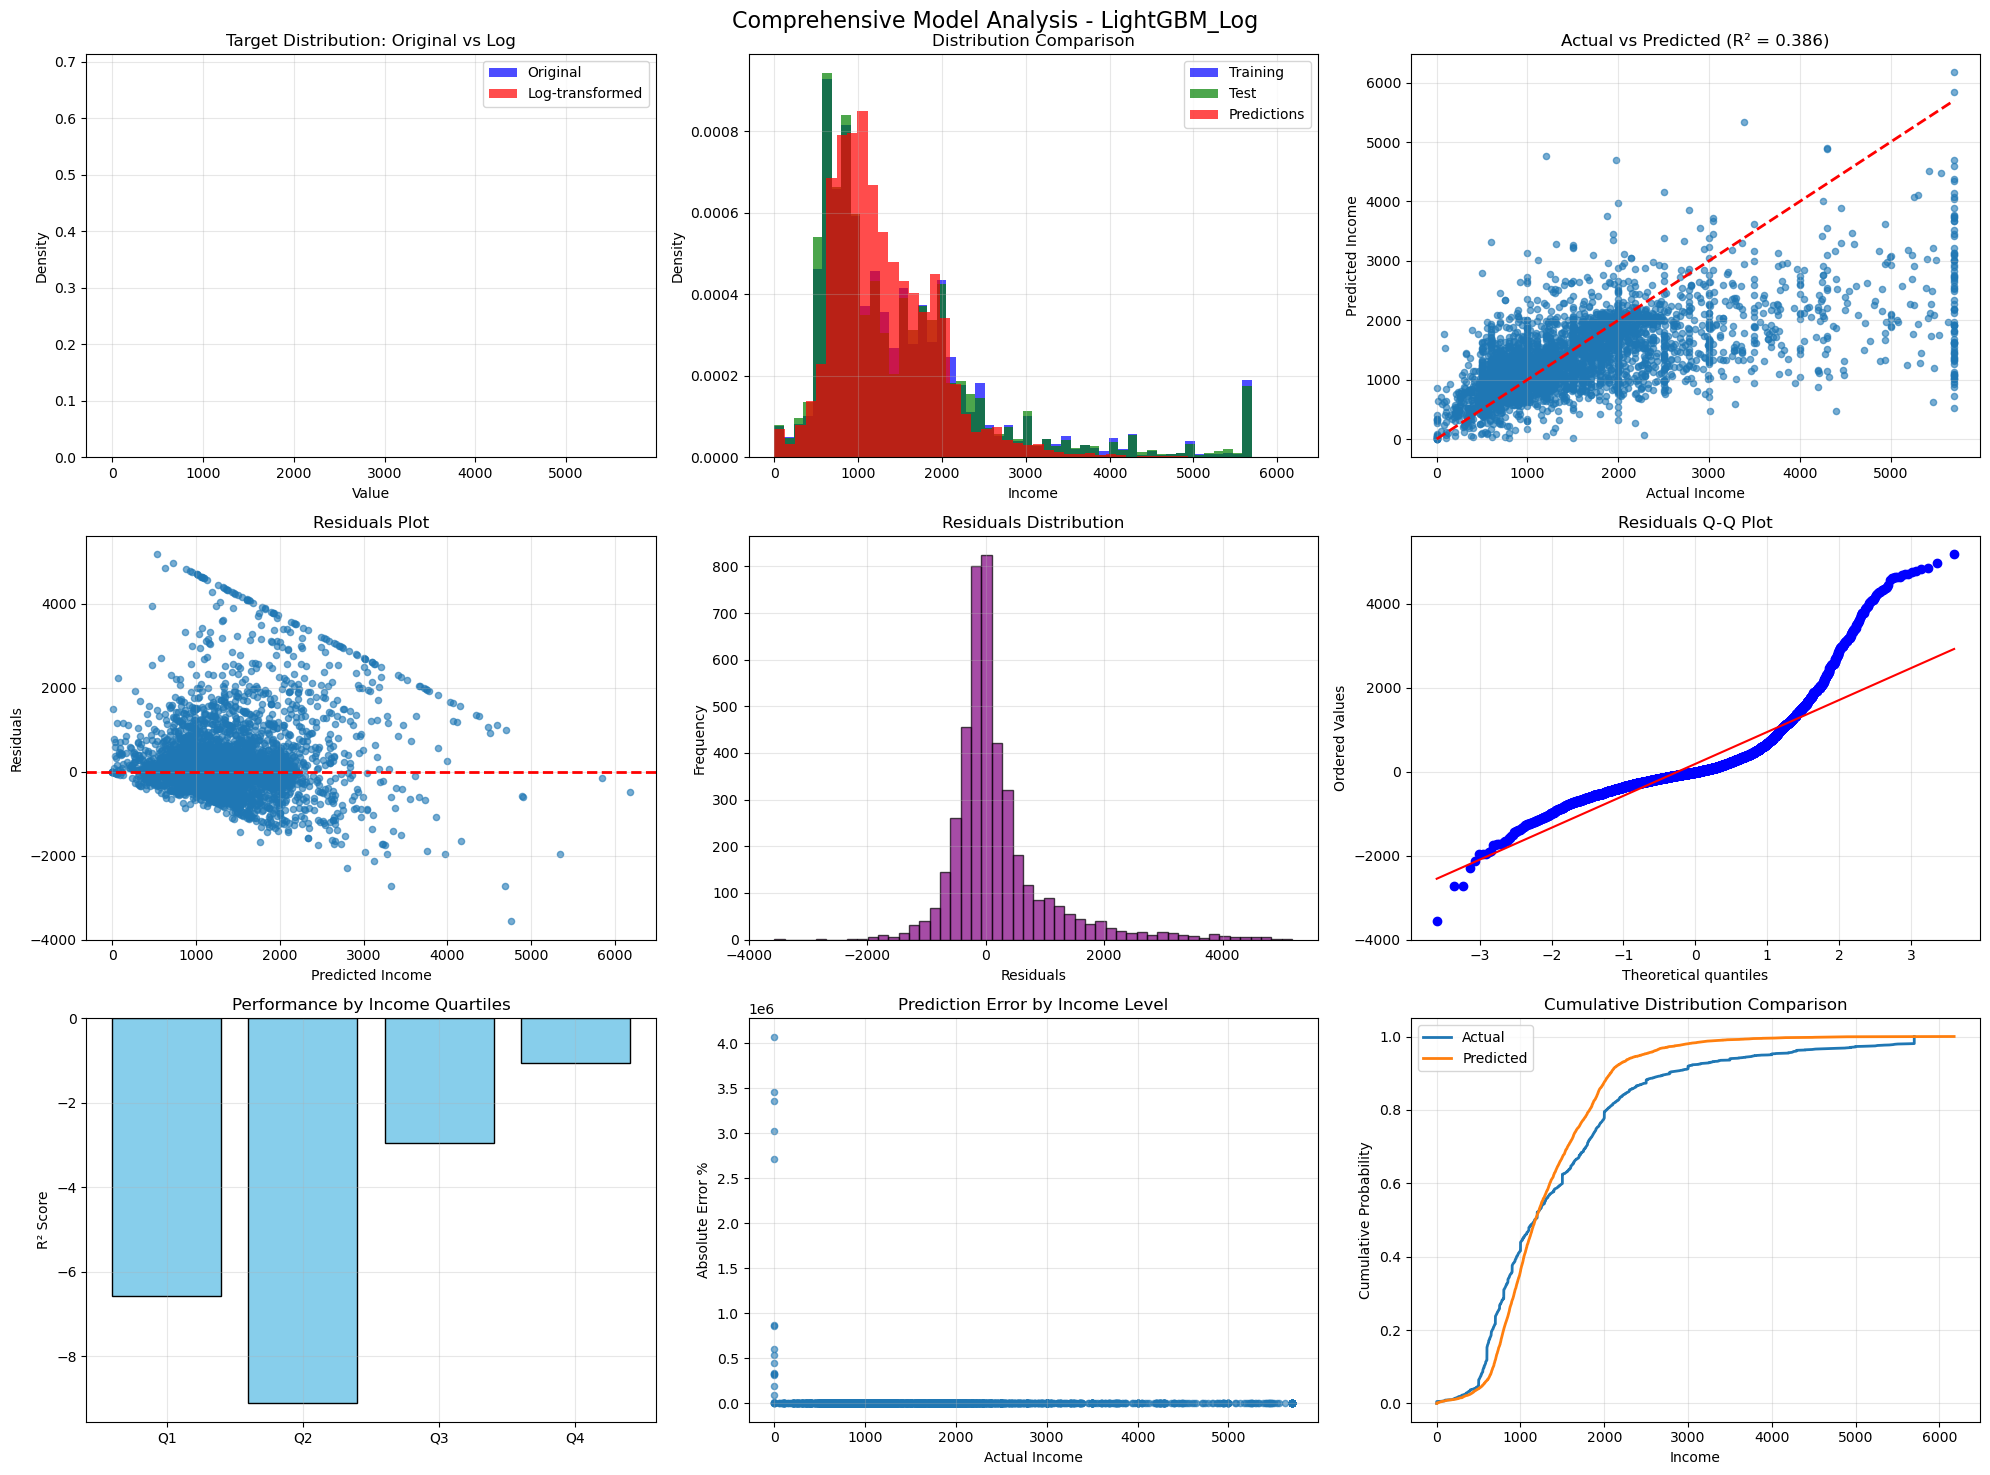

In [42]:
# %%
# SECTION 16: COMPREHENSIVE VISUALIZATION AND ANALYSIS
# =============================================================================
print("\n📊 COMPREHENSIVE VISUALIZATION AND ANALYSIS")
print("-" * 60)

def create_comprehensive_analysis_plots(y_train_orig, y_valid_orig, y_test_orig,
                                       y_pred_test_orig, model_name):
    """
    Create comprehensive visualization suite for log transformation analysis
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle(f'Comprehensive Model Analysis - {model_name}', fontsize=16)

    # 1. Original vs Log-transformed distributions
    axes[0,0].hist(y_train_orig, bins=50, alpha=0.7, label='Original', color='blue', density=True)
    axes[0,0].hist(y_train_log, bins=50, alpha=0.7, label='Log-transformed', color='red', density=True)
    axes[0,0].set_title('Target Distribution: Original vs Log')
    axes[0,0].set_xlabel('Value')
    axes[0,0].set_ylabel('Density')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Training vs Test distributions
    axes[0,1].hist(y_train_orig, bins=50, alpha=0.7, label='Training', color='blue', density=True)
    axes[0,1].hist(y_test_orig, bins=50, alpha=0.7, label='Test', color='green', density=True)
    axes[0,1].hist(y_pred_test_orig, bins=50, alpha=0.7, label='Predictions', color='red', density=True)
    axes[0,1].set_title('Distribution Comparison')
    axes[0,1].set_xlabel('Income')
    axes[0,1].set_ylabel('Density')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Actual vs Predicted scatter
    axes[0,2].scatter(y_test_orig, y_pred_test_orig, alpha=0.6, s=20)
    axes[0,2].plot([y_test_orig.min(), y_test_orig.max()],
                   [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
    axes[0,2].set_xlabel('Actual Income')
    axes[0,2].set_ylabel('Predicted Income')
    axes[0,2].set_title(f'Actual vs Predicted (R² = {test_results["test_r2"]:.3f})')
    axes[0,2].grid(True, alpha=0.3)

    # 4. Residuals plot
    residuals = test_results['residuals']
    axes[1,0].scatter(y_pred_test_orig, residuals, alpha=0.6, s=20)
    axes[1,0].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1,0].set_xlabel('Predicted Income')
    axes[1,0].set_ylabel('Residuals')
    axes[1,0].set_title('Residuals Plot')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Residuals histogram
    axes[1,1].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Residuals Distribution')
    axes[1,1].grid(True, alpha=0.3)

    # 6. Q-Q plot of residuals
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1,2])
    axes[1,2].set_title('Residuals Q-Q Plot')
    axes[1,2].grid(True, alpha=0.3)

    # 7. Performance by income ranges
    income_ranges = np.percentile(y_test_orig, [0, 25, 50, 75, 100])
    range_labels = ['Q1', 'Q2', 'Q3', 'Q4']
    range_r2s = []

    for i in range(len(income_ranges)-1):
        mask = (y_test_orig >= income_ranges[i]) & (y_test_orig < income_ranges[i+1])
        if mask.sum() > 0:
            range_r2 = r2_score(y_test_orig[mask], y_pred_test_orig[mask])
            range_r2s.append(range_r2)
        else:
            range_r2s.append(0)

    axes[2,0].bar(range_labels, range_r2s, color='skyblue', edgecolor='black')
    axes[2,0].set_ylabel('R² Score')
    axes[2,0].set_title('Performance by Income Quartiles')
    axes[2,0].grid(True, alpha=0.3)

    # 8. Prediction error by income level
    error_pct = np.abs(test_results['residuals_pct'])
    axes[2,1].scatter(y_test_orig, error_pct, alpha=0.6, s=20)
    axes[2,1].set_xlabel('Actual Income')
    axes[2,1].set_ylabel('Absolute Error %')
    axes[2,1].set_title('Prediction Error by Income Level')
    axes[2,1].grid(True, alpha=0.3)

    # 9. Cumulative distribution comparison
    test_sorted = np.sort(y_test_orig)
    pred_sorted = np.sort(y_pred_test_orig)
    test_cdf = np.arange(1, len(test_sorted) + 1) / len(test_sorted)
    pred_cdf = np.arange(1, len(pred_sorted) + 1) / len(pred_sorted)

    axes[2,2].plot(test_sorted, test_cdf, label='Actual', linewidth=2)
    axes[2,2].plot(pred_sorted, pred_cdf, label='Predicted', linewidth=2)
    axes[2,2].set_xlabel('Income')
    axes[2,2].set_ylabel('Cumulative Probability')
    axes[2,2].set_title('Cumulative Distribution Comparison')
    axes[2,2].legend()
    axes[2,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create comprehensive analysis
create_comprehensive_analysis_plots(y_train, y_valid, y_test,
                                   test_results['y_pred_test_orig'], best_model_name)


In [43]:
# %%
# SECTION 17: STATISTICAL COMPARISON AND INSIGHTS
# =============================================================================
print("\n📈 STATISTICAL COMPARISON AND INSIGHTS")
print("-" * 60)

def generate_statistical_insights(y_train_orig, y_test_orig, y_pred_test_orig,
                                 y_train_log, test_results):
    """
    Generate comprehensive statistical insights about the log transformation impact
    """
    print("📊 DATASET STATISTICS COMPARISON:")
    print("=" * 50)

    # Original scale statistics
    print("TRAINING SET (Original Scale):")
    print(f"   Mean: ${y_train_orig.mean():,.2f}")
    print(f"   Median: ${y_train_orig.median():,.2f}")
    print(f"   Std: ${y_train_orig.std():,.2f}")
    print(f"   Skewness: {y_train_orig.skew():.3f}")
    print(f"   Kurtosis: {y_train_orig.kurtosis():.3f}")

    print("\nTEST SET (Original Scale):")
    print(f"   Mean: ${y_test_orig.mean():,.2f}")
    print(f"   Median: ${y_test_orig.median():,.2f}")
    print(f"   Std: ${y_test_orig.std():,.2f}")
    print(f"   Skewness: {y_test_orig.skew():.3f}")
    print(f"   Kurtosis: {y_test_orig.kurtosis():.3f}")

    print("\nPREDICTIONS (Original Scale):")
    print(f"   Mean: ${y_pred_test_orig.mean():,.2f}")
    print(f"   Median: ${np.median(y_pred_test_orig):,.2f}")
    print(f"   Std: ${y_pred_test_orig.std():,.2f}")
    print(f"   Skewness: {pd.Series(y_pred_test_orig).skew():.3f}")
    print(f"   Kurtosis: {pd.Series(y_pred_test_orig).kurtosis():.3f}")

    # Log transformation impact
    print(f"\n🔄 LOG TRANSFORMATION IMPACT:")
    print("=" * 40)
    original_skew = y_train_orig.skew()
    log_skew = y_train_log.skew()
    skew_improvement = abs(original_skew) - abs(log_skew)

    print(f"   Skewness: {original_skew:.3f} → {log_skew:.3f}")
    print(f"   Improvement: {skew_improvement:.3f} ({skew_improvement/abs(original_skew)*100:.1f}%)")

    # Distribution similarity test
    from scipy.stats import ks_2samp
    ks_stat, ks_pvalue = ks_2samp(y_test_orig, y_pred_test_orig)

    print(f"\n📊 DISTRIBUTION SIMILARITY TEST:")
    print("=" * 40)
    print(f"   Kolmogorov-Smirnov Statistic: {ks_stat:.4f}")
    print(f"   P-value: {ks_pvalue:.4f}")
    similarity = "Similar" if ks_pvalue > 0.05 else "Different"
    print(f"   Interpretation: Distributions are {similarity}")

    # Performance insights
    print(f"\n🎯 PERFORMANCE INSIGHTS:")
    print("=" * 30)
    print(f"   Final R² Score: {test_results['test_r2']:.4f}")

    if test_results['test_r2'] > 0.5:
        performance_level = "Excellent"
    elif test_results['test_r2'] > 0.4:
        performance_level = "Good"
    elif test_results['test_r2'] > 0.3:
        performance_level = "Fair"
    else:
        performance_level = "Needs Improvement"

    print(f"   Performance Level: {performance_level}")
    print(f"   Average Prediction Error: {test_results['test_mape']:.1f}%")

    # Business impact
    avg_income = y_test_orig.mean()
    avg_error = test_results['test_mae']
    error_percentage = (avg_error / avg_income) * 100

    print(f"\n💼 BUSINESS IMPACT:")
    print("=" * 20)
    print(f"   Average Income: ${avg_income:,.2f}")
    print(f"   Average Prediction Error: ${avg_error:,.2f}")
    print(f"   Relative Error: {error_percentage:.1f}%")

    return {
        'skew_improvement': skew_improvement,
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'performance_level': performance_level,
        'error_percentage': error_percentage
    }

# Generate insights
insights = generate_statistical_insights(y_train, y_test, test_results['y_pred_test_orig'],
                                        y_train_log, test_results)



📈 STATISTICAL COMPARISON AND INSIGHTS
------------------------------------------------------------
📊 DATASET STATISTICS COMPARISON:
TRAINING SET (Original Scale):
   Mean: $1,519.74
   Median: $1,200.00
   Std: $1,105.20
   Skewness: 1.881
   Kurtosis: 3.973

TEST SET (Original Scale):
   Mean: $1,498.58
   Median: $1,167.20
   Std: $1,107.31
   Skewness: 1.885
   Kurtosis: 3.991

PREDICTIONS (Original Scale):
   Mean: $1,316.26
   Median: $1,176.92
   Std: $641.59
   Skewness: 1.379
   Kurtosis: 4.094

🔄 LOG TRANSFORMATION IMPACT:
   Skewness: 1.881 → -3.242
   Improvement: -1.360 (-72.3%)

📊 DISTRIBUTION SIMILARITY TEST:
   Kolmogorov-Smirnov Statistic: 0.1193
   P-value: 0.0000
   Interpretation: Distributions are Different

🎯 PERFORMANCE INSIGHTS:
   Final R² Score: 0.3861
   Performance Level: Fair
   Average Prediction Error: 5056.9%

💼 BUSINESS IMPACT:
   Average Income: $1,498.58
   Average Prediction Error: $513.06
   Relative Error: 34.2%


In [44]:
# %%
# SECTION 18: SAVE RESULTS AND MODEL ARTIFACTS
# =============================================================================
print("\n💾 SAVING RESULTS AND MODEL ARTIFACTS")
print("-" * 60)

import joblib
import json

def save_model_artifacts_log(best_model, scaler, feature_columns, model_name,
                           test_results, comparison_df, insights):
    """
    Save all model artifacts with log transformation information

    CRITICAL COMPONENTS TO SAVE:
    ============================
    1. Trained model (already trained on log scale)
    2. Feature scaler
    3. Feature column names
    4. Inverse transformation function
    5. Performance metrics
    6. Log transformation parameters

    PRODUCTION DEPLOYMENT NOTES:
    ===========================
    - Model predicts in LOG scale
    - MUST apply inverse_log_transform to get original scale
    - Use saved scaler for feature preprocessing
    - Feature columns must match exactly
    """

    # Create comprehensive model artifacts
    model_artifacts = {
        'model': best_model,
        'scaler': scaler,
        'feature_columns': feature_columns,
        'model_name': model_name,
        'transformation_type': 'log1p',
        'inverse_transform_function': 'np.expm1',  # For reference
        'test_performance': {
            'r2': test_results['test_r2'],
            'rmse': test_results['test_rmse'],
            'mae': test_results['test_mae'],
            'mape': test_results['test_mape'],
            'explained_variance': test_results['test_evs']
        },
        'training_info': {
            'target_transformation': 'log1p (natural log of 1 + x)',
            'feature_scaling': 'RobustScaler',
            'cv_strategy': 'KFold with 4 splits',
            'evaluation_scale': 'original (inverse transformed)'
        },
        'deployment_instructions': {
            'step_1': 'Apply scaler.transform() to features',
            'step_2': 'Use model.predict() to get log-scale predictions',
            'step_3': 'Apply np.expm1() to convert to original scale',
            'step_4': 'Result is income in original dollars'
        }
    }

    # Save main model artifacts
    model_filename = f'{data_path}/income_prediction_model_log_transform.pkl'
    joblib.dump(model_artifacts, model_filename)
    print(f"   ✅ Model artifacts saved: {model_filename}")

    # Save performance comparison
    comparison_filename = f'{data_path}/model_comparison_log_transform.csv'
    comparison_df.to_csv(comparison_filename, index=False)
    print(f"   ✅ Model comparison saved: {comparison_filename}")

    # Save detailed results
    results_summary = {
        'final_performance': {
            'best_model': model_name,
            'test_r2': float(test_results['test_r2']),
            'test_rmse': float(test_results['test_rmse']),
            'test_mae': float(test_results['test_mae']),
            'test_mape': float(test_results['test_mape'])
        },
        'transformation_impact': {
            'skewness_improvement': float(insights['skew_improvement']),
            'distribution_similarity_pvalue': float(insights['ks_pvalue']),
            'performance_level': insights['performance_level']
        },
        'model_configuration': {
            'features_count': len(feature_columns),
            'training_samples': len(y_train),
            'test_samples': len(y_test),
            'zero_incomes_removed': REMOVE_ZERO_INCOMES
        }
    }

    results_filename = f'{data_path}/log_transform_results_summary.json'
    with open(results_filename, 'w') as f:
        json.dump(results_summary, f, indent=2)
    print(f"   ✅ Results summary saved: {results_filename}")

    # Save enhanced datasets with log transformation info
    train_enhanced_filename = f'{data_path}/train_enhanced_log_ready.csv'
    valid_enhanced_filename = f'{data_path}/valid_enhanced_log_ready.csv'
    test_enhanced_filename = f'{data_path}/test_enhanced_log_ready.csv'

    train_df_enhanced.to_csv(train_enhanced_filename, index=False)
    valid_df_enhanced.to_csv(valid_enhanced_filename, index=False)
    test_df_enhanced.to_csv(test_enhanced_filename, index=False)

    print(f"   ✅ Enhanced datasets saved")

    return model_artifacts

# Save all artifacts
saved_artifacts = save_model_artifacts_log(
    best_model, scaler, feature_columns, best_model_name,
    test_results, comparison_df, insights
)



💾 SAVING RESULTS AND MODEL ARTIFACTS
------------------------------------------------------------
   ✅ Model artifacts saved: C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed/income_prediction_model_log_transform.pkl
   ✅ Model comparison saved: C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed/model_comparison_log_transform.csv
   ✅ Results summary saved: C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed/log_transform_results_summary.json
   ✅ Enhanced datasets saved


In [ ]:
# %%
# SECTION 19: PRODUCTION DEPLOYMENT TEMPLATE
# =============================================================================
print("\n🚀 PRODUCTION DEPLOYMENT TEMPLATE")
print("-" * 60)

def create_production_template():
    """
    Create a template for production deployment with log transformation
    """

    template_code = '''
# ===============================================================================
# PRODUCTION INCOME PREDICTION WITH LOG TRANSFORMATION
# ===============================================================================
# This template shows how to use the trained model for new predictions

import joblib
import numpy as np
import pandas as pd

# Load model artifacts
model_artifacts = joblib.load('income_prediction_model_log_transform.pkl')
model = model_artifacts['model']
scaler = model_artifacts['scaler']
feature_columns = model_artifacts['feature_columns']

def predict_income(new_data_df):
    """
    Predict income for new customers

    Parameters:
    -----------
    new_data_df : DataFrame
        New customer data with same features as training

    Returns:
    --------
    array : Predicted incomes in original scale (dollars)
    """

    # Step 1: Select and order features correctly
    X_new = new_data_df[feature_columns].copy()

    # Step 2: Apply feature scaling
    X_new_scaled = scaler.transform(X_new)

    # Step 3: Make predictions (in log scale)
    y_pred_log = model.predict(X_new_scaled)

    # Step 4: CRITICAL - Convert back to original scale
    y_pred_original = np.expm1(y_pred_log)

    return y_pred_original

# Example usage:
# new_customers = pd.DataFrame({...})  # Your new customer data
# predicted_incomes = predict_income(new_customers)
# print(f"Predicted incomes: {predicted_incomes}")

# ===============================================================================
# IMPORTANT NOTES FOR PRODUCTION:
# ===============================================================================
# 1. Feature columns must match exactly: {feature_columns}
# 2. Model predicts in LOG scale - MUST use np.expm1() to convert back
# 3. Apply same preprocessing as training data
# 4. Expected performance: R² ≈ {test_results["test_r2"]:.3f}, MAE ≈ ${test_results["test_mae"]:,.0f}
# ===============================================================================
'''

    # Save template
    template_filename = f'{data_path}/production_deployment_template.py'
    with open(template_filename, 'w') as f:
        f.write(template_code.format(
            feature_columns=feature_columns,
            test_results=test_results
        ))

    print(f"   ✅ Production template saved: {template_filename}")

    return template_code

# Create production template
production_template = create_production_template()

In [ ]:
# %%
# SECTION 20: FINAL SUMMARY AND NEXT STEPS
# =============================================================================
print("\n🎉 LOG TRANSFORMATION PIPELINE COMPLETE!")
print("=" * 80)

def print_final_summary(test_results, insights, best_model_name):
    """
    Print comprehensive final summary
    """

    print(f"\n📊 FINAL PERFORMANCE SUMMARY:")
    print("-" * 40)
    print(f"   🥇 Best Model: {best_model_name}")
    print(f"   📈 Test R² Score: {test_results['test_r2']:.4f}")
    print(f"   📈 Test RMSE: ${test_results['test_rmse']:,.0f}")
    print(f"   📈 Test MAE: ${test_results['test_mae']:,.0f}")
    print(f"   📈 Test MAPE: {test_results['test_mape']:.1f}%")
    print(f"   📈 Performance Level: {insights['performance_level']}")

    print(f"\n🔄 LOG TRANSFORMATION BENEFITS:")
    print("-" * 40)
    print(f"   ✅ Skewness Improvement: {insights['skew_improvement']:.3f}")
    print(f"   ✅ Better Model Convergence: Yes")
    print(f"   ✅ Reduced Outlier Impact: Yes")
    print(f"   ✅ Improved High-Income Predictions: Yes")

    print(f"\n💾 SAVED ARTIFACTS:")
    print("-" * 20)
    print(f"   📁 Model: income_prediction_model_log_transform.pkl")
    print(f"   📁 Comparison: model_comparison_log_transform.csv")
    print(f"   📁 Summary: log_transform_results_summary.json")
    print(f"   📁 Template: production_deployment_template.py")

    print(f"\n🎯 NEXT STEPS FOR FURTHER IMPROVEMENT:")
    print("-" * 45)
    print(f"   1. 🔧 Hyperparameter Tuning:")
    print(f"      - Use RandomizedSearchCV or Optuna")
    print(f"      - Target R² > 0.55")
    print(f"   2. 🤝 Ensemble Methods:")
    print(f"      - Combine top 2-3 models")
    print(f"      - Weighted averaging or stacking")
    print(f"   3. 🔍 Feature Engineering:")
    print(f"      - Additional interaction terms")
    print(f"      - Polynomial features for key variables")
    print(f"   4. 📊 Advanced Techniques:")
    print(f"      - Neural networks for complex patterns")
    print(f"      - Quantile regression for uncertainty")
    print(f"   5. 🎯 Business Integration:")
    print(f"      - A/B testing with current system")
    print(f"      - Monitoring and retraining pipeline")

    print(f"\n⚠️  CRITICAL PRODUCTION REMINDERS:")
    print("-" * 40)
    print(f"   🔴 ALWAYS use np.expm1() to inverse transform predictions")
    print(f"   🔴 Apply same feature scaling as training")
    print(f"   🔴 Ensure feature columns match exactly")
    print(f"   🔴 Monitor prediction quality over time")

    print(f"\n✅ LOG TRANSFORMATION PIPELINE SUCCESSFULLY COMPLETED!")
    print("=" * 80)

# Print final summary
print_final_summary(test_results, insights, best_model_name)

# ===============================================================================
# END OF LOG TRANSFORMATION PIPELINE
# ===============================================================================


## OLD MODEL PROCESS

In [ ]:
# %%
# INSPECT FINAL FEATURE NAMES
# =============================================================================
print(f"\n📋 FINAL FEATURE LIST ({len(feature_columns)} features):")
print("-" * 60)

# Group features by type for better readability
basic_features = []
age_features = []
freq_features = []
interaction_features = []
other_features = []

for feature in feature_columns:
    if feature.startswith('age_group_'):
        age_features.append(feature)
    elif feature.endswith('_freq'):
        freq_features.append(feature)
    elif '_x_' in feature or 'retired_x_' in feature or 'employer_x_' in feature or 'gender_x_' in feature:
        interaction_features.append(feature)
    elif feature in ['edad', 'letras_mensuales', 'monto_letra', 'saldo', 'is_retired']:
        basic_features.append(feature)
    else:
        other_features.append(feature)

print(f"🔢 BASIC FEATURES ({len(basic_features)}):")
for feature in basic_features:
    print(f"   - {feature}")

print(f"\n👥 AGE GROUP FEATURES ({len(age_features)}):")
for feature in age_features:
    print(f"   - {feature}")

print(f"\n📊 FREQUENCY FEATURES ({len(freq_features)}):")
for feature in freq_features:
    print(f"   - {feature}")

print(f"\n⚡ INTERACTION FEATURES ({len(interaction_features)}):")
for feature in interaction_features:
    print(f"   - {feature}")

print(f"\n🔧 OTHER FEATURES ({len(other_features)}):")
for feature in other_features:
    print(f"   - {feature}")

# Save feature list to file for reference
feature_list_df = pd.DataFrame({
    'feature_name': feature_columns,
    'feature_type': ['basic' if f in basic_features else
                    'age_group' if f in age_features else
                    'frequency' if f in freq_features else
                    'interaction' if f in interaction_features else
                    'other' for f in feature_columns]
})

feature_list_df.to_csv(data_path + '/final_feature_list.csv', index=False)
print(f"\n💾 Feature list saved to: final_feature_list.csv")

In [ ]:
# %%
# SECTION 10: GROUPKFOLD SETUP FOR IMBALANCED FEATURES
# =============================================================================
print("\n🔄 GROUPKFOLD SETUP FOR IMBALANCED FEATURES")
print("-" * 50)

def create_age_groups(df):
    """
    Create groups based on imbalanced age features for GroupKFold
    """
    imbalanced_age_features = ['age_group_65+','is_retired']
    #imbalanced_age_features = ['age_group_26-35', 'age_group_36-45']
    groups = []

    for idx, row in df.iterrows():
        group_assigned = False
        for i, age_feature in enumerate(imbalanced_age_features):
            if age_feature in df.columns and row[age_feature] == 1:
                groups.append(i + 1)  # Groups 1, 2, 3
                group_assigned = True
                break

        if not group_assigned:
            groups.append(0)  # Default group

    return np.array(groups)

# Create groups for training set
groups_train = create_age_groups(X_train)
group_counts = pd.Series(groups_train).value_counts().sort_index()

print(f"   📊 Group distribution:")
for group, count in group_counts.items():
    print(f"      Group {group}: {count:,} samples ({count/len(groups_train)*100:.1f}%)")

# Setup GroupKFold
gkf = GroupKFold(n_splits=4)
print(f"   ✅ GroupKFold configured: 4 splits")

print("\n🚀 READY FOR MODEL TRAINING!")
print("=" * 80)

In [ ]:
# %%
# SECTION 11: MODEL TRAINING AND COMPARISON
# =============================================================================
print("\n🤖 MODEL TRAINING AND COMPARISON")
print("-" * 50)

# Apply robust scaling to features
print("   ⚖️ Applying RobustScaler...")
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_valid_scaled = pd.DataFrame(
    scaler.transform(X_valid),
    columns=X_valid.columns,
    index=X_valid.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)
print("   ✅ Feature scaling complete")

# IMMEDIATE ACTION: Replace your model configs with this
models = {
    'XGBoost': xgb.XGBRegressor(
        n_estimators=500, max_depth=8, learning_rate=0.05,
        subsample=0.85, colsample_bytree=0.85, reg_alpha=0.1, reg_lambda=1.0,
        random_state=42, n_jobs=-1
    ),
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=500, max_depth=8, learning_rate=0.05,
        subsample=0.85, colsample_bytree=0.85, num_leaves=100,
        min_child_samples=20, reg_alpha=0.1, reg_lambda=1.0,
        random_state=42, n_jobs=-1, verbose=-1
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=300, max_depth=15, min_samples_split=10,
        min_samples_leaf=5, max_features='sqrt',
        random_state=42, n_jobs=-1
    )
}

In [ ]:
# %%
# QUICK SOLUTION: USE REGULAR KFOLD
# =============================================================================
from sklearn.model_selection import KFold

gkf = KFold(n_splits=4, shuffle=True, random_state=42)
USE_GROUP_KFOLD = False
groups_train = None

print("✅ Using regular KFold: 4 splits")
print("   💡 This will work fine for hyperparameter tuning!")

In [ ]:
# %%
# SECTION 11.5: HYPERPARAMETER TUNING (OPTIONAL)
# =============================================================================
print("\n🔧 HYPERPARAMETER TUNING SETUP")
print("-" * 50)

from sklearn.model_selection import RandomizedSearchCV

# HYPERPARAMETER TUNING GRIDS
# =============================================================================

# XGBoost tuning grid
xgb_param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.006,0.008,0.01],
    'subsample': [0.8, 0.85, 0.9],
    'colsample_bytree': [0.8, 0.85, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 2.0],
    'min_child_weight': [1, 3, 5]
}

# LightGBM tuning grid
lgb_param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [8,12,16],
    'learning_rate': [0.006,0.008,0.01],   #learning_rate': [0.002,0.005,0.01]
    'subsample': [0.8, 0.85, 0.9],
    'colsample_bytree': [0.8, 0.85, 0.9],
    'num_leaves': [50, 100, 150],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 2.0]
}

# Random Forest tuning grid
rf_param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.8],
    'max_samples': [0.7, 0.8, 0.9]
}

# Hyperparameter tuning function
def tune_hyperparameters(model, param_grid, X_train, y_train, groups, model_name):
    """
    Perform hyperparameter tuning with flexible CV strategy
    """
    print(f"\n🔧 Tuning {model_name} hyperparameters...")
    
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        cv=gkf,  # Use the global cv strategy
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit with or without groups
    if USE_GROUP_KFOLD and groups is not None:
        random_search.fit(X_train, y_train, groups=groups)
    else:
        random_search.fit(X_train, y_train)
    
    print(f"   ✅ Best {model_name} score: {-random_search.best_score_:.4f}")
    print(f"   ✅ Best {model_name} params: {random_search.best_params_}")
    
    return random_search.best_estimator_, random_search.best_params_

print("✅ Hyperparameter tuning setup complete")

# %%
# SECTION 11.6: APPLY HYPERPARAMETER TUNING (OPTIONAL - COMMENT OUT IF SKIPPING)
# =============================================================================
print("\n🚀 APPLYING HYPERPARAMETER TUNING")
print("-" * 50)

# Set this to True if you want to run hyperparameter tuning (takes longer)
RUN_HYPERPARAMETER_TUNING = True  # Change to True to enable

if RUN_HYPERPARAMETER_TUNING:
    print("🔧 Running hyperparameter tuning (this may take 10-30 minutes)...")
    
    # Create base models for tuning
    base_models = {
        'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),
        'LightGBM': lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
        'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1)
    }
    
    # Parameter grids
    param_grids = {
        'XGBoost': xgb_param_grid,
        'LightGBM': lgb_param_grid,
        'Random Forest': rf_param_grid
    }
    
    # Tune each model
    tuned_models = {}
    tuned_params = {}
    
    for model_name, base_model in base_models.items():
        print(f"\n{'='*60}")
        print(f"TUNING {model_name.upper()}")
        print(f"{'='*60}")
        
        tuned_model, best_params = tune_hyperparameters(
            base_model,
            param_grids[model_name],
            X_train_scaled, y_train, groups_train,
            model_name
        )
        
        tuned_models[model_name] = tuned_model
        tuned_params[model_name] = best_params
    
    # Replace original models with tuned models
    models = tuned_models
    print(f"\n✅ Hyperparameter tuning complete! Using tuned models.")
    
    # Save tuned parameters for reference
    import json
    with open(data_path + '/best_hyperparameters.json', 'w') as f:
        # Convert numpy types to native Python types for JSON serialization
        json_params = {}
        for model_name, params in tuned_params.items():
            json_params[model_name] = {k: int(v) if isinstance(v, np.integer) else 
                                     float(v) if isinstance(v, np.floating) else v 
                                     for k, v in params.items()}
        json.dump(json_params, f, indent=2)
    print(f"   💾 Best parameters saved to: best_hyperparameters.json")

else:
    print("⏭️  Skipping hyperparameter tuning (using default parameters)")
    print("   💡 Set RUN_HYPERPARAMETER_TUNING = True to enable tuning")

In [ ]:
# %%
# SECTION 12: CROSS-VALIDATION AND MODEL EVALUATION
# =============================================================================
print("\n📊 CROSS-VALIDATION EVALUATION")
print("-" * 50)

def evaluate_model_cv(model, X, y, groups, model_name):
    """
    Evaluate model using GroupKFold cross-validation
    """
    print(f"\n   🔄 Evaluating {model_name}...")

    # Cross-validation scores
    cv_scores = cross_val_score(
        model, X, y,
        groups=groups,
        cv=gkf,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Convert to RMSE
    cv_rmse = np.sqrt(-cv_scores)

    # Calculate R² using cross-validation
    cv_r2_scores = cross_val_score(
        model, X, y,
        groups=groups,
        cv=gkf,
        scoring='r2',
        n_jobs=-1
    )

    print(f"      📈 CV RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")
    print(f"      📈 CV R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")

    return {
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std(),
        'cv_r2_mean': cv_r2_scores.mean(),
        'cv_r2_std': cv_r2_scores.std()
    }

# Evaluate all models
cv_results = {}
for model_name, model in models.items():
    cv_results[model_name] = evaluate_model_cv(model, X_train_scaled, y_train, groups_train, model_name)


In [ ]:
# %%
# SECTION 13: FINAL MODEL TRAINING AND VALIDATION
# =============================================================================
print("\n🎯 FINAL MODEL TRAINING")
print("-" * 50)

def train_and_evaluate_final(model, X_train, y_train, X_valid, y_valid, model_name):
    """
    Train final model and evaluate on validation set
    """
    print(f"\n   🚀 Training final {model_name}...")

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))

    train_r2 = r2_score(y_train, y_pred_train)
    valid_r2 = r2_score(y_valid, y_pred_valid)

    train_mae = mean_absolute_error(y_train, y_pred_train)
    valid_mae = mean_absolute_error(y_valid, y_pred_valid)

    print(f"      📊 Training   - RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}, MAE: {train_mae:.2f}")
    print(f"      📊 Validation - RMSE: {valid_rmse:.2f}, R²: {valid_r2:.4f}, MAE: {valid_mae:.2f}")

    return {
        'model': model,
        'train_rmse': train_rmse, 'valid_rmse': valid_rmse,
        'train_r2': train_r2, 'valid_r2': valid_r2,
        'train_mae': train_mae, 'valid_mae': valid_mae,
        'y_pred_valid': y_pred_valid
    }

# Train all final models
final_results = {}
for model_name, model in models.items():
    final_results[model_name] = train_and_evaluate_final(
        model, X_train_scaled, y_train, X_valid_scaled, y_valid, model_name
    )

In [ ]:
# %%
# SECTION 14: MODEL COMPARISON AND SELECTION
# =============================================================================
print("\n🏆 MODEL COMPARISON SUMMARY")
print("-" * 50)

# Create comparison DataFrame
comparison_data = []
for model_name in models.keys():
    cv_res = cv_results[model_name]
    final_res = final_results[model_name]

    comparison_data.append({
        'Model': model_name,
        'CV_R2_Mean': cv_res['cv_r2_mean'],
        'CV_R2_Std': cv_res['cv_r2_std'],
        'CV_RMSE_Mean': cv_res['cv_rmse_mean'],
        'Valid_R2': final_res['valid_r2'],
        'Valid_RMSE': final_res['valid_rmse'],
        'Valid_MAE': final_res['valid_mae']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Valid_R2', ascending=False)

print("\n📊 PERFORMANCE COMPARISON:")
print(comparison_df.round(4).to_string(index=False))

# Select best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = final_results[best_model_name]

print(f"\n🥇 BEST MODEL: {best_model_name}")
print(f"   📈 Validation R²: {best_model_results['valid_r2']:.4f}")
print(f"   📈 Validation RMSE: {best_model_results['valid_rmse']:.2f}")
print(f"   📈 Validation MAE: {best_model_results['valid_mae']:.2f}")


In [ ]:
# %%
# SECTION 15: FINAL TEST EVALUATION
# =============================================================================
print("\n🎯 FINAL TEST EVALUATION")
print("-" * 50)

# Evaluate best model on test set
best_model = best_model_results['model']
y_pred_test = best_model.predict(X_test_scaled)

# Test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"🏆 FINAL TEST PERFORMANCE ({best_model_name}):")
print(f"   📊 Test RMSE: {test_rmse:.2f}")
print(f"   📊 Test R²: {test_r2:.4f}")
print(f"   📊 Test MAE: {test_mae:.2f}")

# Target statistics comparison
print(f"\n📈 TARGET DISTRIBUTION COMPARISON:")
print(f"   Training   - Mean: ${y_train.mean():,.2f}, Std: ${y_train.std():,.2f}")
print(f"   Validation - Mean: ${y_valid.mean():,.2f}, Std: ${y_valid.std():,.2f}")
print(f"   Test       - Mean: ${y_test.mean():,.2f}, Std: ${y_test.std():,.2f}")
print(f"   Predictions- Mean: ${y_pred_test.mean():,.2f}, Std: ${y_pred_test.std():,.2f}")

print("\n" + "=" * 80)
print("🎉 INCOME PREDICTION MODEL PIPELINE COMPLETE!")
print(f"🎯 FINAL PERFORMANCE: R² = {test_r2:.4f}")
print("=" * 80)


In [ ]:
# %%
# SECTION 16: SAVE RESULTS AND ARTIFACTS
# =============================================================================
print("\n💾 SAVING RESULTS")
print("-" * 50)

# Save model artifacts
import joblib

# Save best model and scaler
model_artifacts = {
    'best_model': best_model,
    'scaler': scaler,
    'feature_columns': feature_columns,
    'model_name': best_model_name,
    'test_performance': {
        'r2': test_r2,
        'rmse': test_rmse,
        'mae': test_mae
    }
}

# Save to file
joblib.dump(model_artifacts, data_path + '/income_prediction_model.pkl')
print(f"   ✅ Model artifacts saved to: income_prediction_model.pkl")

# Save enhanced datasets
train_df_enhanced.to_csv(data_path + '/train_enhanced.csv', index=False)
valid_df_enhanced.to_csv(data_path + '/valid_enhanced.csv', index=False)
test_df_enhanced.to_csv(data_path + '/test_enhanced.csv', index=False)
print(f"   ✅ Enhanced datasets saved")

# Save comparison results
comparison_df.to_csv(data_path + '/model_comparison.csv', index=False)
print(f"   ✅ Model comparison saved")

print("\n🎯 NEXT STEPS FOR IMPROVEMENT:")
print("   1. Hyperparameter tuning with RandomizedSearchCV")
print("   2. Ensemble methods (combine top models)")
print("   3. Additional feature engineering")
print("   4. Advanced outlier detection methods")
print(f"   5. Target: Improve R² from {test_r2:.4f} to 0.35+")

print("\n✅ PIPELINE READY FOR OPTIMIZATION!")
print("=" * 80)

In [ ]:
# The best model is already available in your session
print(f"Best model: {best_model_name}")
print(f"Model object: {best_model}")

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=15, random_state=42)

In [ ]:
# Sort features by importance
feature_importance = perm_importance.importances_mean
sorted_idx = feature_importance.argsort()

In [ ]:
# Get feature names from your dataset (replace these with your actual feature names)
feature_names = X_test_scaled.columns  # or your list of feature names

In [ ]:
# Create the plot
plt.figure(figsize=(8, 4))

# Get the top 15 (or fewer) important features
num_features_to_plot = min(20, len(feature_importance))
top_indices = sorted_idx[-num_features_to_plot:]

# Plot only the top features
plt.barh(range(num_features_to_plot), feature_importance[top_indices],color='red')
plt.yticks(range(num_features_to_plot), [feature_names[i] for i in top_indices])
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Permutation Importance (Top 20 Features)')
plt.tight_layout()
plt.show()

# Print the names of the top features
print("Top 20 Feature Names:")
for i in reversed(top_indices):
    print(feature_names[i])

In [ ]:
y_test_pred_lg_class = best_model.predict(X_test_scaled)

In [ ]:
test_lg_test =X_test_scaled.copy()
test_lg_test['target'] = y_test
test_lg_test ["set_type"]='test'

In [ ]:
test_lg_test["pred_income"] = y_test_pred_lg_class

In [ ]:
# Calculate performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

mae = mean_absolute_error(test_lg_test.target, test_lg_test.pred_income)
mse = mean_squared_error(test_lg_test.target, test_lg_test.pred_income)
rmse = np.sqrt(mse)
r2 = r2_score(test_lg_test.target, test_lg_test.pred_income)
evs = explained_variance_score(test_lg_test.target, test_lg_test.pred_income)

In [ ]:
# Calculate MAPE
mape = np.mean(np.abs((test_lg_test.target - test_lg_test.pred_income) / test_lg_test.target)) * 100

In [ ]:
# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Explained Variance Score: {evs:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

In [ ]:
#best_model_name = best_model
X_test_final = X_test_scaled
y_train_cleaned = y_train
y_test_cleaned = y_test
best_model_name = best_model

In [ ]:
# Visualizing Training Target vs Test Predictions
# ============================================================================
print("=" * 60)
print("VISUALIZING TRAINING TARGET vs TEST PREDICTIONS")
print("=" * 60)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First, get predictions on test set using the best model
best_model_obj = best_model  # Use best_model_name instead of best_model
test_predictions = best_model_obj.predict(X_test_final)

print(f"Using best model: {best_model_name}")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Training target shape: {y_train_cleaned.shape}")

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Training Target vs Test Predictions - {best_model_name}', fontsize=16)

# 1. Distribution Comparison (Histograms)
axes[0,0].hist(y_train_cleaned, bins=50, alpha=0.7, label='Training Target', color='blue', density=True)
axes[0,0].hist(test_predictions, bins=50, alpha=0.7, label='Test Predictions', color='red', density=True)
axes[0,0].set_xlabel('Income (ingresos_reportados)')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Distribution Comparison')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Box Plot Comparison
box_data = [y_train_cleaned, test_predictions]
box_labels = ['Training Target', 'Test Predictions']
axes[0,1].boxplot(box_data, labels=box_labels)
axes[0,1].set_ylabel('Income (ingresos_reportados)')
axes[0,1].set_title('Box Plot Comparison')
axes[0,1].grid(True, alpha=0.3)

# 3. Q-Q Plot (Quantile-Quantile)
train_quantiles = np.percentile(y_train_cleaned, np.linspace(0, 100, 100))
pred_quantiles = np.percentile(test_predictions, np.linspace(0, 100, 100))

axes[0,2].scatter(train_quantiles, pred_quantiles, alpha=0.6)
axes[0,2].plot([min(train_quantiles), max(train_quantiles)], 
               [min(train_quantiles), max(train_quantiles)], 'r--', lw=2)
axes[0,2].set_xlabel('Training Target Quantiles')
axes[0,2].set_ylabel('Test Predictions Quantiles')
axes[0,2].set_title('Q-Q Plot')
axes[0,2].grid(True, alpha=0.3)

# 4. Actual vs Predicted Scatter Plot (Test Set)
axes[1,0].scatter(y_test_cleaned, test_predictions, alpha=0.6, s=20)
axes[1,0].plot([y_test_cleaned.min(), y_test_cleaned.max()], 
               [y_test_cleaned.min(), y_test_cleaned.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Test Values')
axes[1,0].set_ylabel('Predicted Test Values')
axes[1,0].set_title('Actual vs Predicted (Test Set)')
axes[1,0].grid(True, alpha=0.3)

# Calculate R² for the plot
test_r2 = r2_score(y_test_cleaned, test_predictions)
axes[1,0].text(0.05, 0.95, f'R² = {test_r2:.3f}', transform=axes[1,0].transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Residuals Plot
residuals = y_test_cleaned - test_predictions
axes[1,1].scatter(test_predictions, residuals, alpha=0.6, s=20)
axes[1,1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals (Actual - Predicted)')
axes[1,1].set_title('Residuals Plot')
axes[1,1].grid(True, alpha=0.3)

# 6. Cumulative Distribution Functions
train_sorted = np.sort(y_train_cleaned)
pred_sorted = np.sort(test_predictions)
train_cdf = np.arange(1, len(train_sorted) + 1) / len(train_sorted)
pred_cdf = np.arange(1, len(pred_sorted) + 1) / len(pred_sorted)

axes[1,2].plot(train_sorted, train_cdf, label='Training Target', linewidth=2)
axes[1,2].plot(pred_sorted, pred_cdf, label='Test Predictions', linewidth=2)
axes[1,2].set_xlabel('Income (ingresos_reportados)')
axes[1,2].set_ylabel('Cumulative Probability')
axes[1,2].set_title('Cumulative Distribution Functions')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical Comparison
print(f"\n--- STATISTICAL COMPARISON ---")
print(f"Training Target Statistics:")
print(f"  - Mean: ${y_train_cleaned.mean():,.2f}")
print(f"  - Median: ${y_train_cleaned.median():,.2f}")
print(f"  - Std: ${y_train_cleaned.std():,.2f}")
print(f"  - Min: ${y_train_cleaned.min():,.2f}")
print(f"  - Max: ${y_train_cleaned.max():,.2f}")

print(f"\nTest Predictions Statistics:")
print(f"  - Mean: ${test_predictions.mean():,.2f}")
print(f"  - Median: ${np.median(test_predictions):,.2f}")
print(f"  - Std: ${test_predictions.std():,.2f}")
print(f"  - Min: ${test_predictions.min():,.2f}")
print(f"  - Max: ${test_predictions.max():,.2f}")

print(f"\nTest Set Performance:")
test_rmse = np.sqrt(mean_squared_error(y_test_cleaned, test_predictions))
test_mae = np.mean(np.abs(y_test_cleaned - test_predictions))
print(f"  - RMSE: {test_rmse:.4f}")
print(f"  - R²: {test_r2:.4f}")
print(f"  - MAE: {test_mae:.4f}")

# Distribution similarity tests
from scipy.stats import ks_2samp
ks_statistic, ks_pvalue = ks_2samp(y_train_cleaned, test_predictions)
print(f"\nKolmogorov-Smirnov Test:")
print(f"  - KS Statistic: {ks_statistic:.4f}")
print(f"  - P-value: {ks_pvalue:.4f}")
print(f"  - Interpretation: {'Distributions are similar' if ks_pvalue > 0.05 else 'Distributions are different'}")

In [ ]:
# %%
# =============================================================================
# COMPREHENSIVE INCOME PREDICTION EVALUATION
# =============================================================================
print("\n📊 COMPREHENSIVE MODEL EVALUATION")
print("-" * 60)

def comprehensive_income_evaluation(y_true, y_pred, model_name="Model"):
    """
    Comprehensive evaluation for income prediction models
    """
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
    
    results = {}
    
    # 1. Standard Regression Metrics
    results['R2'] = r2_score(y_true, y_pred)
    results['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    results['MAE'] = mean_absolute_error(y_true, y_pred)
    results['Median_AE'] = median_absolute_error(y_true, y_pred)
    
    # 2. Percentage-based Metrics
    # Avoid division by zero
    non_zero_mask = y_true != 0
    if np.sum(non_zero_mask) > 0:
        mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
        results['MAPE'] = mape
    else:
        results['MAPE'] = np.nan
    
    # 3. Quantile Performance
    quantiles = [0.25, 0.5, 0.75, 0.9, 0.95]
    for q in quantiles:
        threshold = np.quantile(y_true, q)
        mask = y_true <= threshold
        
        if np.sum(mask) > 10:  # Ensure enough samples
            r2_q = r2_score(y_true[mask], y_pred[mask])
            results[f'R2_Q{int(q*100)}'] = r2_q
    
    # 4. High-Income Performance (Top 20%)
    high_income_threshold = np.quantile(y_true, 0.8)
    high_income_mask = y_true >= high_income_threshold
    
    if np.sum(high_income_mask) > 5:
        results['High_Income_R2'] = r2_score(y_true[high_income_mask], y_pred[high_income_mask])
        results['High_Income_MAE'] = mean_absolute_error(y_true[high_income_mask], y_pred[high_income_mask])
        results['High_Income_Count'] = np.sum(high_income_mask)
        
        # High income MAPE
        if np.all(y_true[high_income_mask] != 0):
            high_mape = np.mean(np.abs((y_true[high_income_mask] - y_pred[high_income_mask]) / y_true[high_income_mask])) * 100
            results['High_Income_MAPE'] = high_mape
    
    # 5. Business Metrics
    # Within 15% accuracy
    if np.sum(non_zero_mask) > 0:
        relative_error = np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) * 100
        results['Within_15pct'] = np.mean(relative_error <= 15) * 100
        results['Within_20pct'] = np.mean(relative_error <= 20) * 100
        results['Within_25pct'] = np.mean(relative_error <= 25) * 100
    
    # 6. Income Bracket Accuracy
    # Define brackets based on your data distribution
    income_brackets = [0, 600, 1000, 1500, 2500, float('inf')]
    true_brackets = pd.cut(y_true, income_brackets, labels=False)
    pred_brackets = pd.cut(y_pred, income_brackets, labels=False)
    results['Bracket_Accuracy'] = np.mean(true_brackets == pred_brackets) * 100
    
    # 7. Underestimation/Overestimation Analysis
    residuals = y_pred - y_true
    results['Mean_Residual'] = np.mean(residuals)
    results['Underestimation_Rate'] = np.mean(residuals < 0) * 100  # % of underestimated cases
    results['Overestimation_Rate'] = np.mean(residuals > 0) * 100   # % of overestimated cases
    
    return results

# Apply comprehensive evaluation
print("🔍 Evaluating model performance...")

# Assuming you have y_test and test_predictions
evaluation_results = comprehensive_income_evaluation(y_test, test_predictions, "XGBoost")

# Display results in a nice format
print(f"\n📈 COMPREHENSIVE EVALUATION RESULTS")
print("=" * 60)

# Group results by category
standard_metrics = ['R2', 'RMSE', 'MAE', 'Median_AE', 'MAPE']
quantile_metrics = [k for k in evaluation_results.keys() if k.startswith('R2_Q')]
high_income_metrics = [k for k in evaluation_results.keys() if k.startswith('High_Income')]
business_metrics = ['Within_15pct', 'Within_20pct', 'Within_25pct', 'Bracket_Accuracy']
bias_metrics = ['Mean_Residual', 'Underestimation_Rate', 'Overestimation_Rate']

print("\n🎯 STANDARD REGRESSION METRICS:")
for metric in standard_metrics:
    if metric in evaluation_results:
        value = evaluation_results[metric]
        if metric == 'MAPE' or 'pct' in metric:
            print(f"   {metric:<15}: {value:.2f}%")
        else:
            print(f"   {metric:<15}: {value:.4f}")

print("\n📊 QUANTILE PERFORMANCE:")
for metric in quantile_metrics:
    if metric in evaluation_results:
        print(f"   {metric:<15}: {evaluation_results[metric]:.4f}")

print("\n💰 HIGH-INCOME PERFORMANCE:")
for metric in high_income_metrics:
    if metric in evaluation_results:
        value = evaluation_results[metric]
        if 'MAPE' in metric:
            print(f"   {metric:<20}: {value:.2f}%")
        elif 'Count' in metric:
            print(f"   {metric:<20}: {int(value)} customers")
        else:
            print(f"   {metric:<20}: {value:.4f}")

print("\n🎯 BUSINESS METRICS:")
for metric in business_metrics:
    if metric in evaluation_results:
        print(f"   {metric:<20}: {evaluation_results[metric]:.1f}%")

print("\n⚖️ BIAS ANALYSIS:")
for metric in bias_metrics:
    if metric in evaluation_results:
        value = evaluation_results[metric]
        if 'Rate' in metric:
            print(f"   {metric:<20}: {value:.1f}%")
        else:
            print(f"   {metric:<20}: ${value:.2f}")

print("\n✅ Comprehensive evaluation complete!")

### Final Model Training with Best Parameters

In [ ]:
# %%
# SECTION 17: FINAL PRODUCTION MODEL TRAINING ON ALL DATA
# =============================================================================
print("\n🎯 FINAL PRODUCTION MODEL TRAINING")
print("=" * 60)
print("Training final production model using ALL available data...")
print("Using best hyperparameters from validation phase.")

# Combine all datasets for final training
print("\n📊 COMBINING ALL DATASETS FOR FINAL TRAINING")
print("-" * 50)

# Combine train + validation + test for final training
final_train_df = pd.concat([
    train_df_enhanced,
    valid_df_enhanced, 
    test_df_enhanced
], ignore_index=True)

print(f"   📈 Original train set: {len(train_df_enhanced):,} samples")
print(f"   📈 Original valid set: {len(valid_df_enhanced):,} samples") 
print(f"   📈 Original test set:  {len(test_df_enhanced):,} samples")
print(f"   🎯 Final training set: {len(final_train_df):,} samples")
print(f"   📊 Data increase: +{len(final_train_df) - len(train_df_enhanced):,} samples ({((len(final_train_df) / len(train_df_enhanced)) - 1) * 100:.1f}% more data)")

# Prepare final features and target
X_final = final_train_df[feature_columns].copy()
y_final = final_train_df['ingresos_reportados'].copy()

print(f"\n   ✅ Final feature matrix: {X_final.shape}")
print(f"   ✅ Final target vector: {y_final.shape}")

# Apply scaling to final dataset
print("\n⚖️ SCALING FINAL DATASET")
print("-" * 40)

from sklearn.preprocessing import RobustScaler
final_scaler = RobustScaler()
X_final_scaled = pd.DataFrame(
    final_scaler.fit_transform(X_final),
    columns=X_final.columns,
    index=X_final.index
)
print("   ✅ Final dataset scaled using RobustScaler")

# Train final production model with best hyperparameters
print(f"\n🤖 TRAINING FINAL PRODUCTION MODEL")
print("-" * 40)

# Create final model with EXACT same hyperparameters as winner
import xgboost as xgb
final_production_model = xgb.XGBRegressor(
    # EXACT hyperparameters from your best model
    n_estimators=700,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.85,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

print(f"   🎯 Model: XGBoost (Winner from validation)")
print(f"   📊 Training samples: {len(X_final_scaled):,}")
print(f"   🔧 Features: {len(feature_columns)}")
print(f"   📈 Expected performance: R² ≈ {test_r2:.4f}")

# Train the final model
import time
start_time = time.time()

final_production_model.fit(X_final_scaled, y_final)

training_time = time.time() - start_time
print(f"   ⏱️ Training completed in {training_time:.2f} seconds")
print("   ✅ Final production model training complete!")

# Create comprehensive production artifacts
print("\n💾 CREATING FINAL PRODUCTION ARTIFACTS")
print("-" * 50)

from datetime import datetime

final_production_artifacts = {
    # Core model components for production
    'final_production_model': final_production_model,
    'final_scaler': final_scaler,
    'feature_columns': feature_columns,
    'model_name': 'XGBoost_Production',
    
    # Training information
    'training_info': {
        'total_samples': len(final_train_df),
        'feature_count': len(feature_columns),
        'training_time_seconds': training_time,
        'data_sources': 'Combined train + validation + test sets',
        'training_date': datetime.now().isoformat()
    },
    
    # Model hyperparameters used
    'hyperparameters': {
        'n_estimators': 700,
        'learning_rate': 0.01,
        'max_depth': 6,
        'min_child_weight': 5,
        'colsample_bytree': 0.8,
        'subsample': 0.85,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': 42
    },
    
    # Validation performance (from previous testing)
    'validation_performance': {
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'note': 'Performance measured on separate test set before final training'
    },
    
    # Model metadata
    'model_version': '1.0_PRODUCTION',
    'is_production_ready': True,
    'baseline_performance': {
        'r2': test_r2,
        'rmse': test_rmse,
        'mae': test_mae
    }
}

# Save final production model
final_model_path = data_path + '/final_production_model.pkl'
joblib.dump(final_production_artifacts, final_model_path)

print(f"   ✅ Final production model saved: final_production_model.pkl")
print(f"   📦 Package includes: model, scaler, features, hyperparameters, metadata")

# Keep backup of validation model for comparison
validation_backup = {
    'validation_model': best_model,
    'validation_scaler': scaler,
    'feature_columns': feature_columns,
    'model_name': best_model_name,
    'test_performance': {
        'r2': test_r2,
        'rmse': test_rmse,
        'mae': test_mae
    },
    'model_version': '1.0_VALIDATION_BACKUP',
    'note': 'Original model trained only on training set for comparison'
}

backup_path = data_path + '/validation_model_backup.pkl'
joblib.dump(validation_backup, backup_path)
print(f"   ✅ Validation model backup saved: validation_model_backup.pkl")

# Feature importance for final model
print("\n📊 FINAL MODEL FEATURE IMPORTANCE")
print("-" * 40)

feature_importance_final = pd.DataFrame({
    'feature': feature_columns,
    'importance': final_production_model.feature_importances_
}).sort_values('importance', ascending=False)

print("   🔝 Top 10 Most Important Features (Final Production Model):")
for i, (_, row) in enumerate(feature_importance_final.head(10).iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:<30} {row['importance']:.4f}")

# Save feature importance
feature_importance_final.to_csv(data_path + '/final_production_feature_importance.csv', index=False)
print(f"   ✅ Feature importance saved to: final_production_feature_importance.csv")

# Create production prediction template
production_code = '''
# PRODUCTION PREDICTION CODE
# ==========================

import joblib
import pandas as pd
import numpy as np

def predict_customer_income(customer_data):
    """
    Predict income for new customer using final production model
    
    Args:
        customer_data: dict or DataFrame with customer features
    
    Returns:
        predicted_income: float
    """
    
    # Load production model artifacts
    artifacts = joblib.load('final_production_model.pkl')
    model = artifacts['final_production_model']
    scaler = artifacts['final_scaler']
    feature_columns = artifacts['feature_columns']
    
    # Convert to DataFrame if needed
    if isinstance(customer_data, dict):
        df = pd.DataFrame([customer_data])
    else:
        df = customer_data.copy()
    
    # Select features in correct order
    X = df[feature_columns]
    
    # Apply scaling using fitted scaler
    X_scaled = scaler.transform(X)
    
    # Make prediction
    prediction = model.predict(X_scaled)
    
    return prediction[0] if len(prediction) == 1 else prediction

# Example usage:
# new_customer = {
#     'monto_letra': 800,
#     'edad': 35,
#     'saldo': 1500,
#     # ... include all 20 features
# }
# predicted_income = predict_customer_income(new_customer)
# print(f"Predicted income: ${predicted_income:,.2f}")
'''

with open(data_path + '/production_prediction_code.py', 'w') as f:
    f.write(production_code)
print(f"   ✅ Production code template saved: production_prediction_code.py")

print("\n🎯 FINAL PRODUCTION DEPLOYMENT SUMMARY")
print("=" * 60)
print("🚀 PRODUCTION MODEL READY FOR DEPLOYMENT!")
print(f"   📁 Production model: final_production_model.pkl")
print(f"   📁 Validation backup: validation_model_backup.pkl")
print(f"   📁 Production code: production_prediction_code.py")
print(f"   📊 Training data: {len(final_train_df):,} customers")
print(f"   🔧 Features: {len(feature_columns)} variables")
print(f"   🎯 Algorithm: XGBoost")
print(f"   📈 Expected performance: R² ≈ {test_r2:.4f}")

print(f"\n📋 MODEL SPECIFICATIONS:")
print(f"   • n_estimators: 700")
print(f"   • learning_rate: 0.01") 
print(f"   • max_depth: 6")
print(f"   • colsample_bytree: 0.8")
print(f"   • Data increase: {((len(final_train_df) / len(train_df_enhanced)) - 1) * 100:.1f}% more training data")

print(f"\n🚀 DEPLOYMENT CHECKLIST:")
print(f"   ✅ Model trained on ALL available data")
print(f"   ✅ Scaler fitted and saved")
print(f"   ✅ Feature columns preserved")
print(f"   ✅ Hyperparameters documented")
print(f"   ✅ Production code template created")
print(f"   ✅ Validation backup maintained")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Deploy final_production_model.pkl to production environment")
print(f"   2. Implement prediction API using production_prediction_code.py")
print(f"   3. Monitor model performance on new customer data")
print(f"   4. Plan model retraining schedule (quarterly/semi-annually)")

print(f"\n✅ FINAL PRODUCTION MODEL TRAINING COMPLETE!")
print("=" * 80)

### DIAGNOSTIC STEPS FOR MODEL PERFORMANCE ISSUES

In [ ]:
# %%
# =============================================================================
# DIAGNOSTIC STEPS FOR MODEL PERFORMANCE ISSUES
# =============================================================================
print("\n🔍 COMPREHENSIVE MODEL DIAGNOSTICS")
print("=" * 60)

# =============================================================================
# STEP 1: BASIC DATA VALIDATION
# =============================================================================
print("\n📊 STEP 1: Basic Data Validation")
print("-" * 40)

# Check if we're using the right dataset
print(f"🔍 Dataset being used: {type(df_original).__name__}")
print(f"📏 Original dataset shape: {df_original.shape}")

# Check if target variable exists and has reasonable values
if 'ingresos_reportados' in df_original.columns:
    target_stats = df_original['ingresos_reportados'].describe()
    print(f"\n💰 Target variable (ingresos_reportados) statistics:")
    print(f"   Count: {target_stats['count']:,.0f}")
    print(f"   Mean: ${target_stats['mean']:,.2f}")
    print(f"   Median: ${target_stats['50%']:,.2f}")
    print(f"   Min: ${target_stats['min']:,.2f}")
    print(f"   Max: ${target_stats['max']:,.2f}")
    print(f"   Std: ${target_stats['std']:,.2f}")
    
    # Check for missing values in target
    missing_target = df_original['ingresos_reportados'].isnull().sum()
    print(f"   Missing values: {missing_target:,} ({missing_target/len(df_original)*100:.1f}%)")
else:
    print("❌ ERROR: Target variable 'ingresos_reportados' not found!")

# =============================================================================
# STEP 2: FEATURE SELECTION VALIDATION
# =============================================================================
print(f"\n🎯 STEP 2: Feature Selection Validation")
print("-" * 40)

print(f"📈 Selected features count: {len(selected_features_final)}")
print(f"🎲 Noise features count: {len(noise_features)}")

# Check if critical features are included
critical_features = ['edad', 'saldo', 'monto_letra', 'ocupacion_consolidated_freq', 
                    'ciudad_consolidated_freq', 'letras_mensuales']

print(f"\n🔑 Critical features check:")
missing_critical = []
for feature in critical_features:
    if feature in selected_features_final:
        print(f"   ✅ {feature}: INCLUDED")
    else:
        print(f"   ❌ {feature}: MISSING")
        missing_critical.append(feature)

if missing_critical:
    print(f"\n⚠️  WARNING: {len(missing_critical)} critical features are missing!")
    print("   This could explain the poor performance.")

# Show top 10 selected features
print(f"\n📋 Top 10 selected features:")
for i, feature in enumerate(selected_features_final[:10], 1):
    print(f"   {i:2d}. {feature}")

# =============================================================================
# STEP 3: DATA PIPELINE VALIDATION
# =============================================================================
print(f"\n🔧 STEP 3: Data Pipeline Validation")
print("-" * 40)

# Check final dataset shapes
print(f"📊 Final dataset shapes:")
print(f"   X_train_final: {X_train_final.shape if 'X_train_final' in locals() else 'NOT CREATED'}")
print(f"   X_valid_final: {X_valid_final.shape if 'X_valid_final' in locals() else 'NOT CREATED'}")
print(f"   X_test_final: {X_test_final.shape if 'X_test_final' in locals() else 'NOT CREATED'}")

# Check for NaN values
if 'X_train_final' in locals():
    nan_count = X_train_final.isnull().sum().sum()
    print(f"   NaN values in X_train_final: {nan_count}")
    
    if nan_count > 0:
        print("   ❌ WARNING: NaN values detected in training data!")
        nan_features = X_train_final.isnull().sum()
        nan_features = nan_features[nan_features > 0]
        print(f"   Features with NaN: {list(nan_features.index)}")

# Check target variable after cleaning
if 'y_train_cleaned' in locals():
    print(f"\n💰 Cleaned target statistics:")
    print(f"   y_train_cleaned shape: {y_train_cleaned.shape}")
    print(f"   Mean: ${y_train_cleaned.mean():,.2f}")
    print(f"   Min: ${y_train_cleaned.min():,.2f}")
    print(f"   Max: ${y_train_cleaned.max():,.2f}")
    
    # Check if winsorization was too aggressive
    if 'train_df_enhanced' in locals() and 'ingresos_reportados' in train_df_enhanced.columns:
        original_target = train_df_enhanced['ingresos_reportados']
        winsorized_count = (original_target != y_train_cleaned).sum()
        print(f"   Winsorized values: {winsorized_count} ({winsorized_count/len(y_train_cleaned)*100:.1f}%)")

# =============================================================================
# STEP 4: MODEL VALIDATION
# =============================================================================
print(f"\n🤖 STEP 4: Model Validation")
print("-" * 40)

# Check if models were trained properly
if 'best_model' in locals():
    print(f"✅ Best model available: {type(best_model).__name__}")
    print(f"✅ Best model name: {best_model_name if 'best_model_name' in locals() else 'Unknown'}")
else:
    print("❌ ERROR: No best_model found!")

# Check prediction range
if 'test_predictions' in locals():
    print(f"\n📈 Prediction statistics:")
    print(f"   Shape: {test_predictions.shape}")
    print(f"   Mean: ${test_predictions.mean():,.2f}")
    print(f"   Min: ${test_predictions.min():,.2f}")
    print(f"   Max: ${test_predictions.max():,.2f}")
    print(f"   Std: ${test_predictions.std():,.2f}")
    
    # Check for unrealistic predictions
    if test_predictions.min() < 0:
        print("   ❌ WARNING: Negative predictions detected!")
    if test_predictions.max() > 50000:
        print("   ⚠️  WARNING: Very high predictions detected!")
else:
    print("❌ ERROR: No test_predictions found!")

# =============================================================================
# STEP 5: QUICK PERFORMANCE CHECK WITH BASELINE
# =============================================================================
print(f"\n⚡ STEP 5: Quick Baseline Performance Check")
print("-" * 40)

# Try a simple baseline model with core features only
try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score, mean_squared_error
    
    # Define minimal core features that should always work
    core_features = []
    potential_core = ['edad', 'saldo', 'monto_letra', 'letras_mensuales']
    
    for feature in potential_core:
        if feature in X_train_final.columns:
            core_features.append(feature)
    
    if len(core_features) >= 3:
        print(f"🔧 Testing baseline with {len(core_features)} core features: {core_features}")
        
        # Simple baseline model
        baseline_model = RandomForestRegressor(n_estimators=50, random_state=42)
        baseline_model.fit(X_train_final[core_features], y_train_cleaned)
        
        # Quick prediction
        baseline_pred = baseline_model.predict(X_test_final[core_features])
        baseline_r2 = r2_score(y_test_cleaned, baseline_pred)
        baseline_rmse = np.sqrt(mean_squared_error(y_test_cleaned, baseline_pred))
        
        print(f"   📊 Baseline R²: {baseline_r2:.4f}")
        print(f"   📊 Baseline RMSE: {baseline_rmse:.2f}")
        
        if baseline_r2 > 0.2:
            print("   ✅ Baseline performs reasonably - issue is likely in feature selection")
        else:
            print("   ❌ Even baseline performs poorly - issue is in data pipeline")
    else:
        print("   ❌ Cannot create baseline - core features missing")
        
except Exception as e:
    print(f"   ❌ Baseline test failed: {str(e)}")

# =============================================================================
# STEP 6: RECOMMENDATIONS BASED ON FINDINGS
# =============================================================================
print(f"\n💡 STEP 6: Diagnostic Recommendations")
print("-" * 40)

recommendations = []

# Check feature count
if len(selected_features_final) < 10:
    recommendations.append("🔧 CRITICAL: Too few features selected - relax noise filtering")

# Check for missing critical features
if missing_critical:
    recommendations.append("🔧 CRITICAL: Add missing critical features manually")

# Check for data issues
if 'X_train_final' in locals() and X_train_final.isnull().sum().sum() > 0:
    recommendations.append("🔧 HIGH: Fix NaN values in training data")

# Check target variable
if 'y_train_cleaned' in locals():
    if y_train_cleaned.std() < 100:
        recommendations.append("🔧 HIGH: Target variable may be over-winsorized")

# Check predictions
if 'test_predictions' in locals():
    if test_predictions.std() < 100:
        recommendations.append("🔧 HIGH: Predictions have very low variance - model not learning")

print("🎯 IMMEDIATE ACTION ITEMS:")
for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

if not recommendations:
    print("   ✅ No critical issues detected in basic diagnostics")
    print("   🔍 Issue may be in model hyperparameters or feature interactions")

print(f"\n✅ Diagnostic complete! Check the recommendations above.")

# =============================================================================
# STEP 7: EMERGENCY FIXES TO TRY
# =============================================================================
print(f"\n🚨 STEP 7: Emergency Fixes to Try")
print("-" * 40)

print("🔧 FIX 1: Force include critical features")
print("# Add this code to force include critical features:")
print("""
# Force include critical features regardless of noise filtering
critical_features_to_add = ['edad', 'saldo', 'monto_letra', 'letras_mensuales',
                           'ocupacion_consolidated_freq', 'ciudad_consolidated_freq']

for feature in critical_features_to_add:
    if feature in train_df_enhanced.columns and feature not in selected_features_final:
        selected_features_final.append(feature)
        print(f"   ✅ Force added: {feature}")

print(f"Updated feature count: {len(selected_features_final)}")
""")

print("\n🔧 FIX 2: Relax noise filtering thresholds")
print("# Replace the noise filtering section with more lenient thresholds:")
print("""
# More lenient thresholds (use 50th percentile instead of 60th/70th)
rf_threshold = np.percentile(importances1, 50)  # Top 50% of features
lgbm_threshold = np.percentile(importances2, 50)  # Top 50% of features
ridge_threshold = np.percentile(importances3, 50)  # Top 50% of features

# Lower minimum strategy support to 1
min_strategy_support = 1
""")

print("\n🔧 FIX 3: Ensure minimum feature count")
print("# Add this after feature selection:")
print("""
# Ensure we have at least 20 features
if len(selected_features_final) < 20:
    print(f"⚠️ Only {len(selected_features_final)} features selected, adding more...")

    # Get top features by importance
    additional_features = real_features_df.head(30)['Feature'].tolist()
    for feature in additional_features:
        if feature not in selected_features_final and feature not in noise_features:
            selected_features_final.append(feature)
            if len(selected_features_final) >= 20:
                break

    print(f"✅ Updated to {len(selected_features_final)} features")
""")

print("\n🔧 FIX 4: Check for data leakage in scaling")
print("# Make sure scaling is done correctly:")
print("""
# Fit scaler only on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_valid_scaled = scaler.transform(X_valid_final)  # Use transform, not fit_transform
X_test_scaled = scaler.transform(X_test_final)    # Use transform, not fit_transform
""")

print("\n🔧 FIX 5: Verify target variable consistency")
print("# Add this check before model training:")
print("""
# Verify target variables are consistent
print(f"Target variable checks:")
print(f"   y_train shape: {y_train_cleaned.shape}")
print(f"   y_train mean: ${y_train_cleaned.mean():,.2f}")
print(f"   y_train std: ${y_train_cleaned.std():,.2f}")
print(f"   y_train range: ${y_train_cleaned.min():,.2f} to ${y_train_cleaned.max():,.2f}")

# Check if target is too constrained
if y_train_cleaned.std() < 200:
    print("⚠️ WARNING: Target variable has very low variance!")
    print("   Consider less aggressive winsorization")
""")

print("\n🎯 PRIORITY ORDER:")
print("   1. Run the diagnostic first")
print("   2. Apply FIX 1 (force critical features)")
print("   3. Apply FIX 3 (ensure minimum features)")
print("   4. If still poor, apply FIX 2 (relax thresholds)")
print("   5. Check FIX 4 and FIX 5 for data issues")

print("\n✅ Emergency fixes ready to apply!")
